In [1]:
%matplotlib inline

from ipywidgets import interact, widgets
from IPython.display import display

import glob
import os
import warnings
import re
import joblib

import numpy as np
import scipy as sp
import dask
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import matplotlib.patches as patches
import matplotlib.collections as collections
import matplotlib.gridspec as gridspec
import mpl_toolkits.axes_grid1 as axtk
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
from matplotlib.ticker import FuncFormatter
from matplotlib.colors import LightSource
import matplotlib
import matplotlib.colors
# import sklearn
# from sklearn.linear_model import LinearRegression
import skimage
import skimage.morphology as morphology
import pymc as pm
import arviz as az
import xarray as xr
import string
import pandas as pd
from tqdm.notebook import tqdm

import deltametrics as dm
import pyDeltaRCM
from pyDeltaRCM.shared_tools import scale_model_time


In [2]:
%load_ext autoreload

In [3]:
%autoreload 1

In [4]:
%aimport CraterModel

In [5]:
import craterstats as cst

# Parameters for processing and plotting

In [6]:
# figure settings
DPI = 90
matplotlib.rcParams['agg.path.chunksize'] = 1000000

# provide the colormaps
data_cm = matplotlib.colormaps['copper'].resampled(5)
error_alpha = 0.3

# provide a consistent setting for background on plots
bg_color = '0.9'
_contour_color = '0.4'
_contour_color_2 = '0.7'

# provide a consistent mapping for the elevation colorbar axis on all plots
elevation_lims = (0, 40)
carto_cm_h, carto_cm_n = 75, 225
If = (3 / 365.25)
_SF = scale_model_time(1, If, 'years')   # scale factor for seconds to years

# consistent annotations
arrowpropsdict = dict(arrowstyle='-', shrinkA=0, edgecolor=_contour_color, facecolor=_contour_color)

_tick_fontsize = 7
_label_fontsize = 8
_panel_letter_fontsize = 10
_colorbar_tick_fontsize = 6
_colorbar_label_fontsize = 8

# consistent file output location
figure_root = './figures/'

In [7]:
# set up marsh accretion with a green colormap
cratered = dm.plot.VariableInfo('cratered', cmap='Greens', label='accretion')
varset = dm.plot.VariableSet({'cratered': cratered})

# adjust the styling for values below 0, marsh==-1
varset['sandfrac'].cmap.set_under('gray')

In [8]:
def _panel_labeler(idx, axi, x=0.9, y=0.80, color='k', **kwargs):
    axi.text(
        x, y, f'{chr(idx + 97)})', transform=axi.transAxes, color=color, fontsize=_panel_letter_fontsize, **kwargs)

# Data Processing


In [9]:
CSFD_MODEL_SET = '/scratch/crater_csfd_matrix/'
csfd_matrix_path = os.path.join(CSFD_MODEL_SET)
csfd_matrix_fldrs = [f.path for f in os.scandir(csfd_matrix_path) if f.is_dir()]
csfd_matrix_fldrs.sort()

UNIFORM_MODEL_SET = '/scratch/crater_uniform_matrix/'
uniform_matrix_path = os.path.join(UNIFORM_MODEL_SET)
uniform_matrix_fldrs = [f.path for f in os.scandir(uniform_matrix_path) if f.is_dir()]
uniform_matrix_fldrs.sort()

In [10]:
# prepare the cube data as a sample for demonstrative figure or data exploration
csfd_sample_folder = csfd_matrix_fldrs[21]  # 5 for 1 Ma, 14 for 100 Ma
csfd_cube = dm.cube.DataCube(os.path.join(csfd_sample_folder, 'pyDeltaRCM_output.nc'), varset=varset)
csfd_strat = dm.cube.StratigraphyCube.from_DataCube(csfd_cube, z=np.arange(-10, 15, step=0.1))

uniform_sample_folder = uniform_matrix_fldrs[14]
uniform_cube = dm.cube.DataCube(os.path.join(uniform_sample_folder, 'pyDeltaRCM_output.nc'), varset=varset)
uniform_strat = dm.cube.StratigraphyCube.from_DataCube(uniform_cube, z=np.arange(-10, 15, step=0.1))

In [11]:
csfd_sample_folder
# SHOULD ALWAYS BE: job_007

'/scratch/crater_csfd_matrix/job_007'

In [12]:
len(csfd_matrix_fldrs)

27

We also define an intermittency factor, which is the value used in scaling the model outputs

# Processing code common to csfd and uniform simulations

In [13]:
# load the crater information to loop over
def read_log(folder):

    pattern = os.path.join(folder, 'pyDeltaRCM_*.log')

    match = list(glob.glob(pattern))
    if len(match) > 1:
        raise RuntimeError
    else:
        logfile = match[0]

    with open(logfile) as f:
        lines = f.readlines()
    return lines


def _find_config_variable_in_log(log_lines, config_variable, datatype='float'):
    """find the configuration variable in the list of lines.
    
    This is pretty slow bc we loop the lines for each variable.
    Probably can be optimized...although it only runs until found.
    """
    for l, line in enumerate(log_lines):
        _match = re.search(f'Configuration variable `{config_variable}`: (\\S+)', line)
        if bool(_match):
            variable_extract = _match.group(1)
            if datatype == 'float':
                variable_value = float(variable_extract)
            elif datatype == 'string':
                variable_value = str(variable_extract)
            return variable_value
            

def process_log(log_lines, log_ID=None):
    """Process the log file.
    
    We read configuration variable here too.
    The right way to do this would be saving as metadata from the model directly...
    """
    # find the needed configuration variable values from the log
    dx = _find_config_variable_in_log(log_lines, 'dx')
    p_slr = _find_config_variable_in_log(log_lines, 'SLR')
    p_f_bedload = _find_config_variable_in_log(log_lines, 'f_bedload')
    p_crater_accumulation_duration = _find_config_variable_in_log(log_lines, 'p_crater_accumulation_duration')
    p_crater_accumulation_number = _find_config_variable_in_log(log_lines, 'p_crater_accumulation_number')
    p_crater_size = _find_config_variable_in_log(log_lines, 'p_crater_size', datatype='string')
    
    # recode crater size parameter, csfd as -1, uniform as -2, or float of numeric if fixed size
    if (p_crater_size == 'sfd'):
        p_crater_size = -1
    elif (p_crater_size == 'uniform'):
        p_crater_size = -2
    else:
        p_crater_size = float(p_crater_size)  
    
    # loop the lines to find crater info
    log_infolist = []
    cidx = int(0)  # crater index
    for l, line in enumerate(log_lines):
            
        # look for a crater match and grab variables
        match = bool(re.search('.*Applied crater.*', line))
        if match:
            # grab all the info from the log
            cidx += 1  # crater number
            # find the most recent timestep recorded
            lminusidx = 1 # line index back from l
            timestep_match = None
            while (timestep_match is None):
                timestep_match = re.search(r'timestep: (\S+)', log_lines[l-lminusidx])
                time_match = re.search(r'Time: (\S+);', log_lines[l-lminusidx])
                lminusidx += 1
                if lminusidx > 100:
                    raise RuntimeError('More than 100 lines between timestep printouts; debug or increase threshold.')
            
            # process the found information
            timestep = timestep_match.group(1)
            time = time_match.group(1)
            size_match = re.search(r'size (\S+)', line)
            diameter = size_match.group(1)
            ref_elev_match = re.search(r'ref elevation (\S+)\.', line)  # ref eleva from the record (UPDATE SOURCING STRING?!)
            ref_elev = ref_elev_match.group(1)
            locy_match = re.search(r'crater at \((\S+),', line)
            locy = float(locy_match.group(1)) + (dx/2)
            locx_match = re.search(r', (\S+)\)', line)
            locx = float(locx_match.group(1)) + (dx/2)
            
            # do some math for addtl fields
            # tidx = np.argmin(float(time) > np.array(cube.t))  # KEEP THIS ONE OR NO??

            log_infolist.append(
                [int(timestep), float(time), int(cidx),
                 float(diameter), float(ref_elev),
                 locx, locy])

    ## make dataframe
    df_log = pd.DataFrame(
        np.array(log_infolist), 
        columns=['timestep', 'time', 'crateridx',
                 'diameter', 'ref_elev',
                 'location_x', 'location_y'])
    # adjust dtypes
    df_log['timestep'] = df_log['timestep'].astype(int)
    df_log['crateridx'] = df_log['crateridx'].astype(int)
    # add columns
    df_log['p_SLR'] = p_slr * np.ones((len(df_log),))
    df_log['p_f_bedload'] = p_f_bedload * np.ones((len(df_log),))
    df_log['p_crater_accumulation_duration'] = p_crater_accumulation_duration * np.ones((len(df_log),))
    df_log['p_crater_accumulation_number'] = p_crater_accumulation_number * np.ones((len(df_log),))
    df_log['p_crater_size'] = p_crater_size * np.ones((len(df_log),))
    
    if not (log_ID is None):
        df_log['log_ID'] = np.tile(log_ID, len(df_log),)    

    return df_log


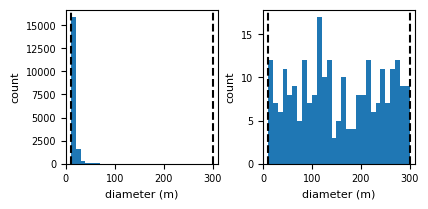

,timestep,time,crateridx,diameter,ref_elev,location_x,location_y,p_SLR,p_f_bedload,p_crater_accumulation_duration,p_crater_accumulation_number,p_crater_size,log_ID
0,40,426666.7,1,109.7,-6.0,9330.0,2390.0,1.000000e-08,0.5,1.0,250.0,-2.0,0
1,75,800000.0,2,118.5,-6.0,11490.0,270.0,1.000000e-08,0.5,1.0,250.0,-2.0,0
2,116,1237333.3,3,148.0,-6.0,10750.0,3670.0,1.000000e-08,0.5,1.0,250.0,-2.0,0
3,168,1792000.0,4,233.0,-6.0,10430.0,1870.0,1.000000e-08,0.5,1.0,250.0,-2.0,0
4,168,1792000.0,5,264.0,-6.0,4970.0,4770.0,1.000000e-08,0.5,1.0,250.0,-2.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
245,5954,63509333.3,246,161.4,-3.4,7350.0,4130.0,1.000000e-08,0.5,1.0,250.0,-2.0,0
246,5969,63669333.3,247,89.8,-5.0,2610.0,570.0,1.000000e-08,0.5,1.0,250.0,-2.0,0
247,5988,63872000.0,248,161.5,14.4,7810.0,1250.0,1.000000e-08,0.5,1.0,250.0,-2.0,0
248,5991,63904000.0,249,104.9,1.3,470.0,4650.0,1.000000e-08,0.5,1.0,250.0,-2.0,0


In [14]:
# test the log reader for the csfd case
_lines = read_log(csfd_sample_folder)
df_log_csfd = process_log(_lines, log_ID='0')

# test the log reader for the uniform case
_lines = read_log(uniform_sample_folder)
df_log_uniform = process_log(_lines, log_ID='0')

fig, ax = plt.subplots(
    1, 2,
    figsize=(4.5, 2), gridspec_kw=dict(wspace=0.3))
# ax.hist(pcks, bins=np.arange(0, 250, step=10), density=True)
ax[0].hist(df_log_csfd['diameter'], bins=np.arange(10, 310, step=10), density=False)
ax[1].hist(df_log_uniform['diameter'], bins=np.arange(10, 310, step=10), density=False)
for axi in ax.ravel():
    axi.axvline(10, color='k', ls='--')
    axi.axvline(300, c='k', ls='--')
    axi.set_xlim(0, 310)
    axi.set_ylabel('count', fontsize=_label_fontsize)
    axi.set_xlabel('diameter (m)', fontsize=_label_fontsize)
    axi.tick_params(labelsize=_tick_fontsize)

fig.set_facecolor('none')
plt.show()

df_log_uniform

In [15]:
# work out a custom colormap for crater IDs
def _make_crateridx_cmap(N):
    greens = matplotlib.colormaps['viridis'].resampled(64)
    combined = np.vstack(([0.8, 0.8, 0.8, 1],
                          greens(np.linspace(0, 1, N))))
    delta = matplotlib.colors.ListedColormap(combined, name='delta')
    bounds = np.hstack(
        (1,
         np.linspace(1, N, N)))
    norm = matplotlib.colors.BoundaryNorm(bounds, len(bounds)-1)
    return delta, norm

def determine_variable_at_surface(cube, variable, surface_idx, include_stasis=True, N_mean=0, **kwargs):
    """helper function to determine the values of a variable on the surface"""
    # determine which depositional spacetime makes up the current surface deposit
    sfc_date = dm.plan.compute_surface_deposit_time(cube, surface_idx, **kwargs)

    # data need to be a numpy array and not xarray...
    cube_data = np.array(cube[variable])

    # then extract the data from the underlying data
    sfc_data = np.take_along_axis(cube_data, sfc_date[np.newaxis], axis=0).squeeze()
    
    if N_mean > 0:
        # if we should take a few samples down and average?
        arr = np.zeros((N_mean+1, *cube_data.shape[1:]))
        for i in range(N_mean):
            sfc_date_i = sfc_date - i
            arr[i, :, :] = np.take_along_axis(cube_data, sfc_date_i[np.newaxis], axis=0).squeeze()
        arr[N_mean, :, :] = sfc_data
        sfc_data = np.mean(arr, axis=0)

    return sfc_data

In [16]:
def _distance_from_inlet(location_x, location_y, inlet_x, inlet_y):
    dist = np.sqrt((location_x-inlet_x)**2 + (location_y-inlet_y)**2)
    return dist

# @njit
def count_number_consecutive(present_sequence):
    # repeat sequence twice so can wrap
    # sequence_rep = np.tile(present_sequence, (1, 2)).flatten()
    sequence_rep = np.repeat(present_sequence, 2).reshape(-1, 2).T.flatten()
    
    # now count
    seq_flag = False
    seq_count = 1
    max_count = 0
    for i in range(len(sequence_rep)-1):
        if sequence_rep[i] == sequence_rep[i+1] == 1:
            seq_count += 1
            if max_count < seq_count: max_count = seq_count
            seq_flag = True
        else:
            seq_flag = False
            seq_count = 1
    return max_count

def compute_degrees_covered(center, where_preserved, coverage_bins, dx):
    """Compute the covered degress for a set of points.
    """
    n_coverage_bins = len(coverage_bins)-1
    # compute the vector to each point as parts
    delta_0 = (dx*where_preserved[0]) - center[0]
    delta_1 = (dx*where_preserved[1]) - center[1]
    # convert to degrees
    degs = np.rad2deg(np.arctan2(delta_0, delta_1))
    # bin to see where is covered
    counts, _ = np.histogram(degs+180, bins=coverage_bins)
    any_in_bin = (counts > 0)
    fracbinscov = np.sum(any_in_bin) / n_coverage_bins
    # find where it is consecutive, ie where mappable
    numcon = count_number_consecutive(any_in_bin)
    degconsec = np.clip(numcon, 0, n_coverage_bins)*(360/n_coverage_bins)
    
    return fracbinscov, degconsec

In [17]:
# loop over each item in the df, and search for it!

def compute_preservation_from_df_cubes(df_log, cube, strat):
    
    # convert cube data to exported array for speed
    _eta_spacetime = np.array(cube.export_frozen_variable('eta'))
    _rim_spacetime = np.array(cube.export_frozen_variable('crater_rim'))
    _rim_strat = np.array(strat.export_frozen_variable('crater_rim'))
    _ejecta_spacetime = np.array(cube.export_frozen_variable('crater_ejecta'))
    _ejecta_strat = np.array(strat.export_frozen_variable('crater_ejecta'))
    
    # set fixed thresholding and binning parameters
    n_coverage_bins_max = 7

    # precompute the fixed attributes for this cube/strat pair
    sfc_date_1 = dm.plan.compute_surface_deposit_time(_eta_spacetime, -1, stasis_tol=1)
    sfc_date_001 = dm.plan.compute_surface_deposit_time(_eta_spacetime, -1, stasis_tol=0.001)
    sfc_data = np.take_along_axis(_rim_spacetime, sfc_date_1[np.newaxis], axis=0).squeeze()

    # make deposit mask
    _approx_sediments = np.any(
        np.array(strat.export_frozen_variable('sandfrac'))>0,
        axis=0)  # wherever there is some sand (a first guess)
    _approx_sediments = morphology.remove_small_holes(_approx_sediments.astype(bool), 32)  # fill the gaps
    _approx_sediments = morphology.remove_small_objects(_approx_sediments.astype(bool), 10)  # remvoe points outside large blob
    deposit_mask = dm.mask.DepositMask.from_array(_approx_sediments)  # make mask

    # preallocate recorded statistics
    _distance_inlet = np.zeros(len(df_log))
    _interbedded = np.zeros(len(df_log), dtype=bool)
    _rim_frac = np.full(len(df_log), np.nan)
    _ejecta_frac = np.full(len(df_log), np.nan)
    _rim_frac_sfc = np.full(len(df_log), np.nan)
    _rim_degree_cov = np.full(len(df_log), np.nan)
    _rim_degree_consec = np.full(len(df_log), np.nan)
    _rim_degree_consec_top = np.full(len(df_log), np.nan)
    _rim_degree_consec_aboveref = np.full(len(df_log), np.nan)

    # inlet coords
    inlet_y = float(cube.meta['dx'] * cube.meta['L0'])
    inlet_x = float(cube.meta['dx'] * cube.meta['CTR'])
    dx = float(cube.meta['dx'].data)

    # time var
    cube_time = cube.t.data
    
    df_stats = df_log.copy()
    for c, crater_instance in tqdm(df_log.iterrows(), total=df_log.shape[0]):

        # calcuate the distance from the inlet
        _distance_inlet[c] = _distance_from_inlet(
            crater_instance['location_x'], crater_instance['location_y'],
            inlet_x, inlet_y)
        center = (crater_instance['location_y'], crater_instance['location_x'])
        
        # calculate the time index to look for pixels colored
        cidx = int(crater_instance['crateridx'])    # integer stored in the rim dataset
        tidx = np.argmin(crater_instance['time'] > cube_time)  # which save interval time is saved in
        tidx_rec = max(1, tidx)
        
        # determine if crater is interbedded
        initial_rim_bool = (_rim_spacetime[tidx_rec, :, :] == cidx)
        initial_ejecta_bool = (_ejecta_spacetime[tidx_rec, :, :] == cidx)
        surface_time = np.take(cube_time, sfc_date_001)
        __is_above_bottom = (crater_instance['ref_elev'] > -5)
        __is_revisited = np.any((surface_time[initial_rim_bool]) > cube_time[tidx])  # needs to be older than the interval it was saved into
        __is_in_deposit = np.any(np.logical_and(initial_rim_bool, deposit_mask.mask.data))
        if __is_above_bottom and __is_revisited and __is_in_deposit:
            _interbedded[c] = True

        # calculate some reference points in the cubes to search for deposit
        # count_z_idx = (np.sum(_rim_strat == cidx, axis=(1, 2)) > 0)
        strat_cols_rim_bool = (_rim_strat[:, initial_rim_bool] == cidx) # z x n_initial_cells array of strat
        strat_cols_ejecta_bool = (_ejecta_strat[:, initial_ejecta_bool] == cidx) # z x n_initial_cells array of strat
        count_z_idx = np.any(strat_cols_rim_bool, axis=1)
        top_z_idx = len(count_z_idx) - np.argmax(count_z_idx[::-1]) - 1 # highest z with any observation
        ref_elev_idx = np.argmin(crater_instance['ref_elev'] > np.array(strat.z))  # reference elevation before crater (*one idx above*)
        
        # -- methods based on total fractions of area -- #
        # count the initial pixels that were tagged rim
        initial_rim_count = np.sum(initial_rim_bool)
        initial_ejecta_count = np.sum(initial_ejecta_bool)

        # count the pixels where a voxel is tagged matches
        strat_cols_rim_cols_bool = np.any(strat_cols_rim_bool, axis=0)  # bool of which strat columns have cidx preserved
        strat_rim_count = np.sum(strat_cols_rim_cols_bool)  # count of columns that have preserved
        strat_ejecta_count = np.sum(np.any(strat_cols_ejecta_bool, axis=0))

        # count the pixels where the rim is expressed at the surface (ignoring deposition up to 1m after event)
        sfc_rim_bool = (sfc_data == cidx)
        sfc_rim_count = np.sum(sfc_rim_bool)

        # calculate fractions
        if initial_rim_count > 0:
            _rim_frac[c] = strat_rim_count / initial_rim_count
            _rim_frac_sfc[c] = sfc_rim_count / initial_rim_count
        if initial_ejecta_count > 0:
            _ejecta_frac[c] = strat_ejecta_count / initial_ejecta_count

        # -- methods using angles of coverage for mappability -- #
        # search anywhere within the column of stratigraphy
        n_coverage_bins_max = int(np.ceil(360 /  np.rad2deg(dx / (crater_instance['diameter']/2))))  # rounded up number of bins that matches the pixel width at the diameter of the crater
        n_coverage_bins = np.maximum(4, np.minimum(n_coverage_bins_max-1, initial_rim_count-1))  # between 1 and N bins
        coverage_bins = np.linspace(0, 360, num=n_coverage_bins, endpoint=True)

        # # compute for preserved anywhere in stratigraphy
        initial_rim_whr = np.where(initial_rim_bool)
        strat_rim_whr = initial_rim_whr[0][strat_cols_rim_cols_bool], initial_rim_whr[1][strat_cols_rim_cols_bool]    
        
        if (crater_instance['diameter'] < (np.sqrt(2)*dx*2)): # note <57 works
            
            # this will only occupy one ring at the diameter
            # use the consec checker directly
            if len(strat_cols_rim_cols_bool) > 8:
                raise RuntimeError('Too many idxs taken!')
            
            # add offsets to account for the padding
            i, j = int(center[0]/dx)+1, int(center[1]/dx)+1
            dim0, dim1 = cube.shape[1:]
            dim0 += 2
            dim1 += 2
            ij = np.ravel_multi_index((np.array([i]), np.array([j])), (dim0, dim1))

            expected_neighbors_idxs = [ij-dim1-1, ij-dim1, ij-dim1+1, ij+1, ij+dim1+1, ij+dim1, ij+dim1-1, ij-1] # the eight neighbors that would be there
            initial_rim_bool_pad = np.pad(initial_rim_bool, 1, mode='constant', constant_values=0)
            initial_neighbors_bool = initial_rim_bool_pad.flat[expected_neighbors_idxs].flatten()
            default_idx_order = np.array([0, 1, 2, 4, 7, 6, 5, 3])   # order of neighbors if all 8 initial and preserved
            initial_neighbors_idx_order = default_idx_order[initial_neighbors_bool]  # order of neighbors only those initial
            
            nghbrs_sorted_bool = np.zeros((8,), dtype=bool)
            nghbrs_sorted_bool[initial_neighbors_idx_order] = strat_cols_rim_cols_bool

            numcon = count_number_consecutive(nghbrs_sorted_bool)
            degconsec = np.clip(float(numcon), 0, 8) * float(360/8)
            _rim_degree_consec[c] = degconsec
            
        else:
            _rim_degree_cov[c], _rim_degree_consec[c] = compute_degrees_covered(center, strat_rim_whr, coverage_bins, dx)
        
        # compute for preserved anywhere above reference height
        strat_cols_rim_cols_aboveref_bool = np.any(strat_cols_rim_bool[ref_elev_idx:, :], axis=0)
        strat_rim_aboveref_whr = initial_rim_whr[0][strat_cols_rim_cols_aboveref_bool], initial_rim_whr[1][strat_cols_rim_cols_aboveref_bool]
        _, _rim_degree_consec_aboveref[c] = compute_degrees_covered(center, strat_rim_aboveref_whr, coverage_bins, dx)

    df_stats['distance_inlet'] = _distance_inlet
    df_stats['interbedded'] = _interbedded
    df_stats['rim_frac'] = _rim_frac
    df_stats['ejecta_frac'] = _ejecta_frac
    df_stats['rim_frac_sfc'] = _rim_frac_sfc
    df_stats['rim_degree_cov'] = _rim_degree_cov        # degree bin fraction covered
    df_stats['rim_degree_consec'] = _rim_degree_consec  # consecutive degrees covered (i.e., mappable)
    df_stats['rim_degree_consec_aboveref'] = _rim_degree_consec_aboveref  # consecutive degrees covered (i.e., mappable)
    df_stats['rim_degree_consec_top'] = _rim_degree_consec_top  # consecutive degrees covered (i.e., mappable)
    
    return df_stats


In [18]:
# test with a single csfd
df_stats_single_csfd = compute_preservation_from_df_cubes(df_log_csfd, cube=csfd_cube, strat=csfd_strat)
df_stats_single_csfd.to_csv('./crater_data/csfd_preserved_metrics_single.csv', index=False)

# test with a single uniform
df_stats_single_uniform = compute_preservation_from_df_cubes(df_log_uniform, cube=uniform_cube, strat=uniform_strat)
df_stats_single_uniform.to_csv('./crater_data/uniform_preserved_metrics_single.csv', index=False)

  0%|          | 0/18064 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

# Introduction figure(s)

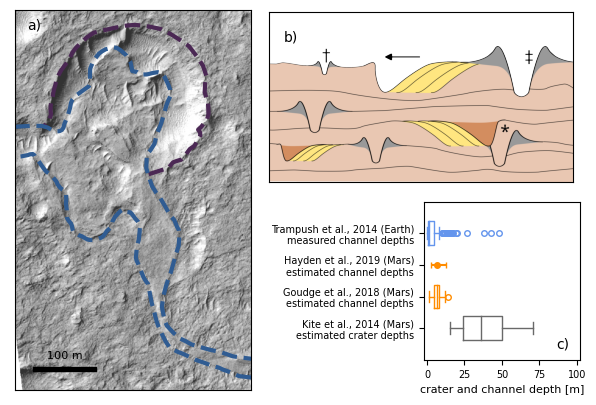

In [19]:
# make the introduction figure
def _crater_depth_rim_height(diameter):
    """get dims.
    
    Helper for intro plot, using Howard 2007 equations to
    determine the crater depth and rim height for a given diameter.
    
    note diameter is in m! heights are returned in meters.
    """
    diameter = diameter
    radius = diameter / 2
    H1 = 2.54 * diameter**0.67
    H2 = 1.93 * diameter**0.52
    H2H1 = H2 - H1
    m = 0.73 * diameter**0.113  # value: 2 to 3
    n = 3
    Ii = 0.9  # rim follows slope
    Er = 0
    Ei = 0
    
    inDeltaH = H2H1 + H1 * (0 / radius) ** m
    inDeltaE = inDeltaH + (Er - Ei) * (1 - (Ii * (0 / radius) ** 2))
    
    outDeltaH = H2 * ((2 * (radius)) / (diameter)) ** -n
    G = np.minimum((1 - Ii), (outDeltaH / H2))
    outDeltaE = outDeltaH + G * (Er - Ei)
    
    return np.abs(inDeltaE), outDeltaE
    
# load / set up the data
img = skimage.io.imread('./figures/introduction_figure_inputs/kite_example_6_238.png')

fig = plt.figure(figsize=(6, 4))

goudge_sm1 = pd.read_csv('./figures/introduction_figure_inputs/Goudge_Jezero_Delta_Paleohydrology_Icarus_2018_Table_SM1.csv', header=0)
kite_example_lines = pd.read_csv('./figures/introduction_figure_inputs/example_interbedded_crater_lines.csv', header=0)

ax0 = fig.add_axes([0.01, 0.025, 0.45, 0.95])
ax0.imshow(img, extent=[0, 1335, 1000, 0])
rect = patches.Rectangle(
    (0, 0), 1, 1,
    facecolor='white', alpha=0.2, transform=ax0.transAxes)
ax0.add_patch(rect)
ax0.plot(kite_example_lines['crater_rim_x'], kite_example_lines['crater_rim_y'], lw=3, ls='--', color=np.array([75, 40, 84])/255)
ax0.plot(kite_example_lines['channel_upper_x'], kite_example_lines['channel_upper_y'], lw=3, ls='--', color=np.array([48, 92, 146])/255)
ax0.plot(kite_example_lines['channel_lower_x'], kite_example_lines['channel_lower_y'], lw=3, ls='--', color=np.array([48, 92, 146])/255)

scalebar = AnchoredSizeBar(
    ax0.transData,
    370/238*100, '100 m', 'lower left', 
    bbox_to_anchor=(0.075, 0.05),
    bbox_transform=ax0.transAxes,
    pad=0,
    sep=5,
    borderpad=0,
    color='k',
    frameon=False,
    size_vertical=8, label_top=True,
    fontproperties=dict(size=_label_fontsize)
)
ax0.add_artist(scalebar)

ax0.set_xlim(50, 625)
ax0.set_ylim(950, 25)
ax0.set_xticks([])
ax0.set_yticks([])
ax0.text(0.05, 0.95, 'a)', transform=ax0.transAxes, fontsize=_panel_letter_fontsize)

# data plot(s)!
ax1 = fig.add_axes([0.72, 0.1, 0.26, 0.395])
ax2 = fig.add_axes([0.45, 0.545, 0.53, 0.425])

# goudge 2018 Icarus paper of jezero measurements
goudge_sm1 = pd.read_csv('./figures/introduction_figure_inputs/Goudge_Jezero_Delta_Paleohydrology_Icarus_2018_Table_SM1.csv', header=0)
goudge_sm2 = pd.read_csv('./figures/introduction_figure_inputs/Goudge_Jezero_Delta_Paleohydrology_Icarus_2018_Table_SM2.csv', header=0)
goudge_point_bar_height = goudge_sm1['Point Bar Height (m)']
goudge_estimated_channel_depth = goudge_point_bar_height / 3
goudge_estimated_channel_body_width = goudge_sm2['Channel Body Width (m)']

# crate geometry of fresh craters
golombek_catalog = pd.read_csv('./figures/introduction_figure_inputs/golombek_fresh_crater_data.csv', header=0)
golombek_crater_depth_category1to3_diam0to300m = golombek_catalog[(
    (golombek_catalog['diameter (m)'] <= 300) &
    (golombek_catalog['diameter (m)'] >= 10) &
    (golombek_catalog['morphologic class'] <= 3))]['depth (m)'].dropna()

# earth channel depths
trampush_data = pd.read_csv('./figures/introduction_figure_inputs/ShieldsJHRData.csv', header=0)
trampush_channel_depth = trampush_data['Hbf.m']
# earth channel widths
trampush_channel_width = trampush_data['Bbf.m']
# mars channel depths from Hayden
hayden_estimated_channel_depth = dict(estimate=6.7, low=3, high=13) # note: could get distributions by going to the DiBiase 2013 original data, but these are not public 
# mars channel widths from Hayden
hayden_estimated_channel_width = dict(estimate=120, low=49, high=230)  # note: could get distributions by going to the DiBiase 2013 original data, but these are not public

# load kite data
filtered_ecdf = pd.read_csv('./crater_data/kite_filtered_ecdf.csv')
kite_ecdf = pd.read_csv('./crater_data/kite_measured_ecdf.csv')
kite_model_depths, _ = _crater_depth_rim_height(kite_ecdf['diameter [m]'])
kite_inferred_missing_depths, _ = _crater_depth_rim_height(50)

mars_props = dict(color='darkorange', markersize=4, markeredgecolor='darkorange')
earth_props = dict(color='cornflowerblue', markersize=4, markeredgecolor='cornflowerblue')
crater_props = dict(color='dimgray', markersize=4, markeredgecolor='dimgray')

# plot the channel and crater depth data
ax1.boxplot(
    kite_model_depths,
    positions=[0.1], vert=False,
    labels=['Kite et al., 2014 (Mars)\nestimated crater depths'],
    boxprops=crater_props, medianprops=crater_props, whiskerprops=crater_props, 
    capprops=crater_props, flierprops=crater_props)

ax1.boxplot(
    goudge_estimated_channel_depth,
    positions=[0.3], vert=False,
    labels=['Goudge et al., 2018 (Mars)\nestimated channel depths'],
    boxprops=mars_props, medianprops=mars_props, whiskerprops=mars_props, 
    capprops=mars_props, flierprops=mars_props)
ax1.boxplot(  # PLACEHOLDER FOR LABEL ON AXIS
    [np.nan],
    positions=[0.5], vert=False,
    labels=['Hayden et al., 2019 (Mars)\nestimated channel depths'],
    boxprops=mars_props, medianprops=mars_props, whiskerprops=mars_props, 
    capprops=mars_props, flierprops=mars_props)
ax1.errorbar(
    hayden_estimated_channel_depth['estimate'], 0.5,
    yerr=None, xerr=np.array([[hayden_estimated_channel_depth['estimate']-hayden_estimated_channel_depth['low']], [hayden_estimated_channel_depth['high']-hayden_estimated_channel_depth['estimate']]]),
    marker='o', color=mars_props['color'], markersize=mars_props['markersize'], capsize=2
)

ax1.boxplot(
    trampush_channel_depth,
    positions=[0.7], vert=False,
    labels=['Trampush et al., 2014 (Earth)\nmeasured channel depths'],
    boxprops=earth_props, medianprops=earth_props, whiskerprops=earth_props, 
    capprops=earth_props, flierprops=earth_props)

ax1.set_xlabel('crater and channel depth [m]', fontsize=_label_fontsize)
ax1.set_ylim(-0.1, 0.9)
ax1.set_xlim(-2, 102)

# load up a high res png of the schematic I want to use showing a migrating river and crater deposit
im = plt.imread('intro_schematic.png')
ax2.imshow(im)
ax2.set_ylim(im.shape[0], -(im.shape[0]/4))
ax2.set_xticks([])
ax2.set_yticks([])

ax1.text(0.85, 0.075, 'c)', transform=ax1.transAxes, fontsize=_panel_letter_fontsize)
ax2.text(0.05, 0.825, 'b)', transform=ax2.transAxes, fontsize=_panel_letter_fontsize)

for axi in [ax0, ax1, ax2]:
    axi.tick_params(labelsize=_tick_fontsize)

fig.set_facecolor('none')

plt.savefig(os.path.join(figure_root, 'introduction_figure.png'), dpi=600)
plt.savefig(os.path.join(figure_root, 'introduction_figure.pdf'), dpi=300)
plt.show()

In [20]:
# check median and mean of Mars observations (Hayden + Goudge) vs IQR of Earth (Trampush)
trampush_25th_75th = np.percentile(trampush_channel_depth, [25, 75])
trampush_iqr = np.subtract(*np.flip(trampush_25th_75th))
matplotlib_whisker_factor = 1.5
trampush_whiskers = (trampush_25th_75th[0] - (matplotlib_whisker_factor*trampush_iqr), trampush_25th_75th[1] + (matplotlib_whisker_factor*trampush_iqr))
print(f"Trampush 25th and 75th percentiles: {trampush_25th_75th:} m")
print(f"Trampush IQR: {trampush_iqr:} m")
print(f"Trampush whiskers (Q3 + 1.5*IQR): {trampush_whiskers:} m")
print(f"Hayden estimate: {hayden_estimated_channel_depth['estimate']:}")
print(f"Goudge estimate: {np.median(goudge_estimated_channel_depth):}")
# trampush_iqr}

Trampush 25th and 75th percentiles: [0.94488 4.3825 ] m
Trampush IQR: 3.4376200000000003 m
Trampush whiskers (Q3 + 1.5*IQR): (-4.21155, 9.53893) m
Hayden estimate: 6.7
Goudge estimate: 6.666666666666667


# Introduction figures with examples of each 1, 10, 100

figure with crater distributions and figure with crater examples and metrics

In [21]:
# make the core assumptions for all of the plots and analysis
functions_path = os.path.join(cst.PATH, "config/functions.txt")
craterstats_functions = cst.gm.read_textstructure(functions_path)

# production and chronology functions
production_function = cst.Productionfn(craterstats_functions, 'Mars, Ivanov (2001)')
chronology_function = cst.Chronologyfn(craterstats_functions, 'Mars, Hartmann & Neukum (2001)')

# helper to plot isochrons
def plot_isochrons(
    isochrons,
    production_function,
    chronology_function,
    equilibrium_function=None,
    presentation='differential',
    ax=None,
    range=None,
    rotation=-45,
    sx=0.006,
    **kwargs):
    
    if ax is None:
        fig, ax = plt.subplots()
    
    # default style options
    color = kwargs.pop('color', '0.8')
    size = kwargs.pop('fontsize', 10)
    
    # loop each
    for t in isochrons:
        a0 = chronology_function.a0(t)
        iso = production_function.getisochron(
            presentation, a0, equilibrium_function, range=range)
        
        # plot the isochron
        ax.plot(iso["d"], iso["y"], color=color, lw=0.5)
        
        # figure out where to label it
        sx = sx  # HARDCODED X LOCATION -- NEED TO FIX THIS!
        rotation = rotation # HARDCODED
        sy = production_function.evaluate(presentation, sx, a0)
        sy -= 0.5 * 10**np.floor(np.log10(sy))  # offset by 4/10 of an order of magnitude
        ax.text(
            sx, sy, cst.str_age(t, simple=True),
            color=color, size=size,
            rotation=rotation,
            rotation_mode="anchor",
            verticalalignment="top",
            horizontalalignment="left",
            # transform=ax.transAxes,
            bbox=dict(
                facecolor="none", edgecolor="none", boxstyle="square,pad=0.5"
            ),
        )
        

def fit_poisson_model(cratercount, production_function, chronology_function, fit_range=[-np.inf, np.inf]):
    """Wraps certain objects to fit the poisson model
    """
    # perform the fit
    poisson_pdf = cst.Craterpdf(
        production_function, chronology_function, cratercount, fit_range, bcc=False
    )
    
    # median/1-sigma gaussian-equivalent percentiles
    t = poisson_pdf.t([0.50, 0.16, 0.84])

    a0 = chronology_function.a0(t)
    n = poisson_pdf.k
    n_event = n
    _ref_diameter = 1  # ??????????
    n_d = production_function.evaluate("cumulative", _ref_diameter, a0[0])

    return dict(
        pdf=poisson_pdf,
        a0=a0,
        t=t
    )

def show_pdf(mdl, xy=None, ax=None, fig=None, show_distribution=True, **kwargs):
    
    sig_figs = kwargs.pop('sig_figs', 3)
    mu = kwargs.pop('mu', False)
    
    if (xy is None):
        # solve for an xy position
        raise NotImplementedError()  # todo
        
    if (fig is None):
        fig =  plt.gcf()
        
    if (ax is None):
        ax =  plt.gca()
        
    _fontsize = kwargs.pop('fontsize', _label_fontsize)
    
    suffix = kwargs.pop('suffix', 'a')
    st = cst.str_age(
        mdl['t'][0],
        mdl['t'][2] - mdl['t'][0],
        mdl['t'][0] - mdl['t'][1],
        sf=sig_figs,
        mu=mu, suffix=suffix
    )
    # define a new axes there
    pdfax = fig.add_axes([xy[0], xy[1], 0.1, 0.05])
    if show_distribution:
        mdl['pdf'].plot(
            pdfax, **kwargs
        )
    else:
        pdfax.axis('off')
    # add the test
    pdfax.text(-1.65, 0.25, st, transform=pdfax.transAxes, fontsize=_fontsize, **kwargs)
        
crater_range_interest = [0.01, 0.300]  # kilometers [10m to 300m]
expansion = np.array([0.95, 1.05])

three_colorset = matplotlib.colors.ListedColormap(
    matplotlib.colormaps['viridis'].resampled(4)(np.arange(1, 3)))
_show_distribution = False

isochrons_years = np.array([1000, 10000, 1e5, 1e6, 1e7, 1e8, 1e9]) # needs to be in in billion years 
isochrons_Ga = isochrons_years / 1e9

In [22]:
from CraterModel import CraterModel

param_dict = {
        "Length": 6000.0,
        "Width": 12000.0,
        "dx": 20,
        "verbose": 1,
        "N0_meters": 150,
        "L0_meters": 75,
        "Np_water": 1500,  # 1000
        "Np_sed": 300,  # 125
        "u0": 1.5,
        "h0": 6,
        'SLR': 5e-8,
        'f_bedload': 0.7,
        'itermax': 1,
        'clobber_netcdf': True,
        'out_dir': './crater_test_subgrid_display_3',
        'save_dt': 250000,
        'add_craters': True}

# make lpsc figure
accumulation_durations = 1, 10, 100
accumulations = []

for i, dur in enumerate(accumulation_durations):
    
    param_dict["p_timesteps"] = 10000 # 6000 for uniform
    param_dict["p_crater_size"] = "sfd" # "uniform"
    param_dict["p_crater_accumulation_duration"] = dur  # Myr
    param_dict["p_sfd_range"] = [10, 300]

    cratermodel = CraterModel(input_file=None, **param_dict);
    cratermodel.finalize()
    
    # get a sorted copy (for some reason the loader wants sorted data)
    diameters = np.sort(cratermodel.crater_schedule['diameter'])
    accumulations.append(diameters)
  

/mass/Dropbox/research/mars/cratering_pyDeltaRCM/CraterModel.py:103: UserWarning: Crater range of interest was outside of production functions's defined range. Extrapolating.
  warnings.warn(


Time: 0.0; timestep: 0


/mass/Dropbox/research/mars/cratering_pyDeltaRCM/CraterModel.py:103: UserWarning: Crater range of interest was outside of production functions's defined range. Extrapolating.
  warnings.warn(


Time: 0.0; timestep: 0
Time: 0.0; timestep: 0


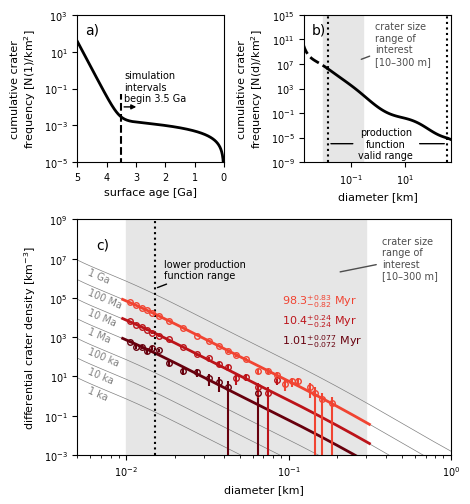

In [23]:
# Introduction with examples of CSFDs
lpsc_colorset = matplotlib.colors.ListedColormap(
    matplotlib.colormaps['Reds_r'].resampled(6)(np.arange(0, 3)))

fig = plt.figure(
    figsize=(4.5, 5))

# set up the gridspec
gs = gridspec.GridSpec(ncols=2, nrows=2, figure=fig, left=0.15, right=0.98, bottom=0.1, top=0.98, wspace=0.55, hspace=0.3, height_ratios=[1, 1.6])
topleft = fig.add_subplot(gs[0, 0])
topright = fig.add_subplot(gs[0, 1])
bottom = fig.add_subplot(gs[1, :])

plot_isochrons(
    isochrons_Ga,
    production_function,
    chronology_function,
    ax=bottom,
    color='0.5',
    fontsize=_tick_fontsize,
    range=[0.005, 1],
    rotation=-23,
    sx=0.006
)

# top figures with production function and chronology function

xrange = np.log10(production_function.range)
# xrange = np.log10([1/1000, 1000])
x0 = np.linspace(xrange[0], xrange[1], 100) # reverse order because np.interp() requires increasing 'x-values'
y0 = np.log10(production_function.evaluate("cumulative", 10.** x0))
xrange_low = np.log10([1/1000, production_function.range[0]])
xrange_high = np.log10([production_function.range[1], 1000])
x0_low = np.linspace(xrange_low[0], xrange_low[1], 20)
y0_low = np.log10(production_function.evaluate("cumulative", 10.** x0_low))
x0_high = np.linspace(xrange_high[0], xrange_high[1], 20)
y0_high = np.log10(production_function.evaluate("cumulative", 10.** x0_high))
topright.plot(10**x0, 10**y0, color='0', linewidth=2)
topright.plot(10**x0_low, 10**y0_low, color='0', ls='--', linewidth=2)
topright.plot(10**x0_high, 10**y0_high, color='0', ls='--', linewidth=2)
# topright.axvline(x=np.log10(production_function.range[0]), c='k', ls='--')
# topright.axvline(x=np.log10(production_function.range[1]), c='k', ls='--')
topright.set_xscale('log')
topright.set_yscale('log')
# topright.axvline(x=crater_range_interest[0], c='0.8', ls='--')  # range of interest lower
# topright.axvline(x=crater_range_interest[1], c='0.8', ls='--') # range of interest lower
topright.axvline(x=production_function.range[0], c='0', ls=':')# range of production function lower
topright.axvline(x=production_function.range[1], c='0', ls=':')# range of production function lower
topright.set_ylabel('cumulative crater\nfrequency [N(d)/km$^2$]', fontsize=_label_fontsize)
topright.set_xlabel('diameter [km]', fontsize=_label_fontsize)
# topleft.set_xlim(5e-3, 1e2)
topright.tick_params(labelsize=_tick_fontsize) 
topright.fill_between(crater_range_interest, 1e-10, 1e20, color='0.9')
topright.set_ylim(1e-9, 1e15)
topright.set_xlim(2e-3, 5e2)
topright.text(0.05, 0.875, 'b)', transform=topright.transAxes, fontsize=_panel_letter_fontsize)

topleft.plot(chronology_function.ts, chronology_function.n1s, color='0', linewidth=2)
topleft.set_yscale('log')
topleft.set_xlim(5, 0)
topleft.set_xlabel('surface age [Ga]', fontsize=_label_fontsize)
topleft.set_ylabel('cumulative crater\nfrequency [N(1)/km$^2$]', fontsize=_label_fontsize)
topleft.tick_params(labelsize=_tick_fontsize)
topleft.text(0.05, 0.875, 'a)', transform=topleft.transAxes, fontsize=_panel_letter_fontsize)

for i, dur in enumerate(accumulation_durations):
    
    # make a crater count dataset from the synthetic data
    cc = cst.Cratercount(filename='None')
    cc.area = 72
    cc.diam = (accumulations[i] / 1000 ).tolist()
    cc.fraction = np.ones(len(cc.diam)).tolist()
    cc.prebinned = 0

    plot = cc.getplotdata(
        'differential',
        binning='pseudo-log',
        range=crater_range_interest,
        resurfacing=None,
        pf=production_function,
    )

    mdl = fit_poisson_model(
        cc,
        production_function,
        chronology_function,
        fit_range=crater_range_interest)

    fit = production_function.getplotdata(
        'differential',
        mdl['a0'][0],
        range=crater_range_interest * expansion
    )
    
    bottom.errorbar(
        plot['d'], plot['y'], plot['err'],
        marker='o', mfc='none', c=lpsc_colorset(i), linestyle='none', ms=4)
    bottom.plot(
        (fit["d"]),
        fit["y"],
        label="fit",
        color=lpsc_colorset(i),
        lw=2,
    )
    show_pdf(
        mdl,
        xy=(0.77, 0.31+(0.04*i)),
        fig=fig,
        color=lpsc_colorset(i),
        fontsize=_label_fontsize,
        show_distribution=_show_distribution,
        suffix='yr')


# adjust style
bottom.set_xscale('log')
bottom.set_yscale('log')
bottom.set_ylim(1e-3, 1e9)
bottom.set_xlim(5e-3, 1e0)
bottom.set_xlabel('diameter [km]', fontsize=_label_fontsize)
bottom.set_ylabel('differential crater density [km$^{-3}$]', fontsize=_label_fontsize)
bottom.tick_params(labelsize=_tick_fontsize)
bottom.text(0.05, 0.875, 'c)', transform=bottom.transAxes, fontsize=_panel_letter_fontsize)

# add vlines
bottom.axvline(x=production_function.range[0], c='0', ls=':')# range of production function lower
bottom.axvline(x=production_function.range[1], c='0', ls=':')# range of production function lower
bottom.fill_between(crater_range_interest, 1e-6, 1e16, color='0.9')
bottom.annotate(
    'lower production\nfunction range',
    xy=(production_function.range[0], 3e5),
    xytext=(1.7e-2, 1e6),
    fontsize=_tick_fontsize,
    arrowprops=dict(arrowstyle='-'))
# bottom.text(
#     crater_range_interest[1]-0.02, 5e7,
#     'crater size range\nof interest\n[10–300 m]',
#     fontsize=_tick_fontsize, ha='right', va='top', color='0.3')
bottom.annotate(
    'crater size\nrange of\ninterest\n[10–300 m]',
    xy=(crater_range_interest[1]-0.1, 2e6),
    xytext=(3.75e-1, 1e6),
    fontsize=_tick_fontsize, ha='left', color='0.3',
    arrowprops=dict(arrowstyle='-', color='0.3'))

topleft.annotate(
    ' ',
    xy=(3.5, 1e-2),
    xytext=(2.8, 1e-2),
    fontsize=_tick_fontsize, va='center', color='k',
    arrowprops=dict(arrowstyle='<|-', color='k'))
topleft.text(
    3.4, 2e-2,
    'simulation\nintervals\nbegin 3.5 Ga',
    fontsize=_tick_fontsize, color='k')
topleft.plot([3.5, 3.5], [1e-7, 5e-2], 'k--')
topleft.set_ylim(1e-5, 1e3)


topright.annotate(
    'crater size\nrange of\ninterest\n[10–300 m]',
    xy=(crater_range_interest[1]-0.1, 4e7),
    xytext=(8e-1, 1e7),
    fontsize=_tick_fontsize, ha='left', color='0.3',
    arrowprops=dict(arrowstyle='-', color='0.3'))
topright.annotate(
    'production\nfunction\nvalid range',
    xy=(production_function.range[0], 1e-6),
    xytext=(2e0, 1e-6),
    fontsize=_tick_fontsize, ha='center', va='center', color='k',
    arrowprops=dict(arrowstyle='-', color='k'))
topright.annotate(
    '                          ',
    xy=(production_function.range[1], 1e-6),
    xytext=(7e-1, 1e-6),
    fontsize=_tick_fontsize, ha='center', va='center', color='k',
    arrowprops=dict(arrowstyle='-', color='k'))

fig.savefig(os.path.join(figure_root, 'chronology_production_function_examples.png'), dpi=300, transparent=False, facecolor='none')
fig.savefig(os.path.join(figure_root, 'chronology_production_function_examples.pdf'), dpi=300, transparent=False, facecolor='none')

plt.show()

/mass/Dropbox/research/mars/cratering_pyDeltaRCM/CraterModel.py:103: UserWarning: Crater range of interest was outside of production functions's defined range. Extrapolating.
  warnings.warn(


  0%|          | 0/171 [00:00<?, ?it/s]

  0%|          | 0/1794 [00:00<?, ?it/s]

  0%|          | 0/18059 [00:00<?, ?it/s]

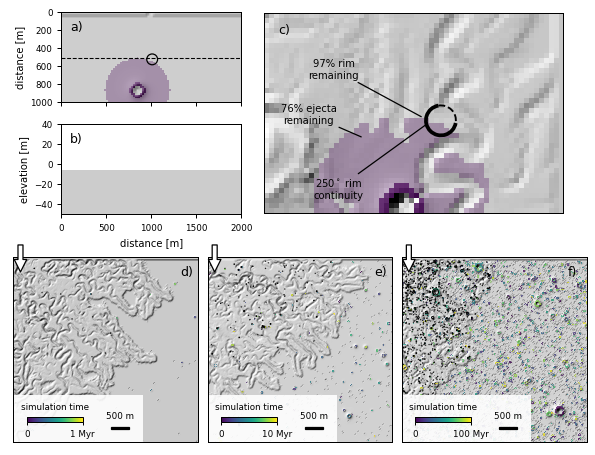

In [24]:
# Introduction figure with one example of 1, 10, 100 Ma

# make the list of cubes to loop through
timescales_examples_list = [csfd_matrix_fldrs[i] for i in [0, 9, 23]]  # 0 for 1 Ma, 6 for 10 Ma, 14 for 100 Ma

fig = plt.figure(
    figsize=(6.5, 5), dpi=90
)
top_gs = fig.add_gridspec(2, 2, left=0.075, right=0.95, bottom=0.53, top=0.98, wspace=0.05, hspace=0.25, width_ratios=(1, 1.5))
topleft_axs = [fig.add_subplot(top_gs[i, 0]) for i in range(2)]
topright_ax = fig.add_subplot(top_gs[:, 1])
bot_gs = fig.add_gridspec(1, 3, left=0.01, right=0.99, bottom=0.01, top=0.45, wspace=0.05)
ax = [fig.add_subplot(bot_gs[i]) for i in range(3)]

# PROCESS IMAGES INTO UPPER GRIDSPEC
# left side is the two craters with cross section
from CraterModel import CraterModel

stratigraphy_demo_param_dict = {
        'Length': 1000.,
        'Width': 2000.,
        'dx': 20,
        'N0_meters': 50,
        'L0_meters': 50,
        'h0': 6,
        'itermax': 1,
        'clobber_netcdf': True,
        'save_dt': 250000,
        'add_craters': True}
stratigraphy_demo_param_dict['seed'] = int(23)

with pyDeltaRCM.shared_tools._docs_temp_directory() as output_dir:
    mdl = CraterModel(
        input_file=None,
        out_dir=output_dir,
        **stratigraphy_demo_param_dict)

    _eta = np.zeros((3, *mdl.eta.shape))
    _rim = np.zeros((3, *mdl.eta.shape))
    _ejecta = np.zeros((3, *mdl.eta.shape))
    _eta[0, ...] = mdl.eta
    for idx in range(1):
        mdl._crater_surface(120)
    mdl.finalize()

    _eta[1, ...] = mdl.eta
    _rim[1, ...] = mdl.cratered_rim_sincesave
    _ejecta[1, ...] = mdl.cratered_ejecta_sincesave
    
    # manual modification
    eta_init = mdl.eta.copy()
    eta_modified = np.zeros(eta_init.shape)
    eta_channel = uniform_cube['eta'][-1].data[10:80, 150:200].T.copy()
    i0, j0 = 0, 3
    eta_channel_full = np.zeros(eta_init.shape)
    eta_channel_full[i0:i0+eta_channel.shape[0], j0:j0+eta_channel.shape[1]] += eta_channel
    eta_modified += eta_init
    eta_modified += eta_channel_full
    eta_modified[eta_channel_full < -1] = eta_channel_full[eta_channel_full < -1] - 6
    _eta[2, :] = eta_modified

    egcube = dm.cube.DataCube({'eta': _eta[:2], 'crater_rim': _rim[:2], 'crater_ejecta': _ejecta[:2]})
    egstrat = dm.cube.StratigraphyCube.from_DataCube(egcube, z=np.arange(-50, 30, step=0.1))
    
    egcube_modified = dm.cube.DataCube({'eta': _eta, 'crater_rim': _rim, 'crater_ejecta': _ejecta})
    egstrat_modified = dm.cube.StratigraphyCube.from_DataCube(egcube_modified, z=np.arange(-50, 30, step=0.1))

# make the figure elements
ls = LightSource(azdeg=315, altdeg=45)
hs = ls.hillshade(mdl.eta, vert_exag=8, dx=20, dy=20)

_cidx_cmap, _cidx_norm = _make_crateridx_cmap(9)
topleft_axs[0].imshow(
    hs, cmap='gray', extent=[i*mdl.dx for i in egcube.extent],)
im = topleft_axs[0].imshow(
    egcube['crater_rim'][-1], extent=[i*mdl.dx for i in egcube.extent],
    cmap=_cidx_cmap, norm=_cidx_norm, interpolation='none', alpha=0.6)
_data = egcube['crater_ejecta'][-1].data.astype(float)
_data[_data == 0] = np.nan
im = topleft_axs[0].imshow(
    _data, extent=[i*mdl.dx for i in egcube.extent],
    cmap=_cidx_cmap, norm=_cidx_norm, interpolation='none', alpha=0.3)
_xsect_idx = 26
topleft_axs[0].plot([0, 2000], [20*_xsect_idx, 20*_xsect_idx], 'k--', lw=0.85)

topleft_axs[1].imshow(
    egstrat['crater_rim'][:, _xsect_idx, :],
    cmap=_cidx_cmap, norm=_cidx_norm, extent=[0, egcube.extent[1]*mdl.dx, egstrat.z[0], egstrat.z[-1]],
    interpolation='none', aspect='auto', origin='lower')
_data = egstrat['crater_ejecta'][:, _xsect_idx, :].data
_data[_data == 0] = np.nan
topleft_axs[1].imshow(
    _data,
    cmap=_cidx_cmap, norm=_cidx_norm, extent=[0, egcube.extent[1]*mdl.dx, egstrat.z[0], egstrat.z[-1]],
    alpha=0.5, interpolation='none', aspect='auto', origin='lower')
topleft_axs[1].set_ylim(-50, 40)

topleft_axs[1].set_xlabel('distance [m]', fontsize=_label_fontsize)
topleft_axs[0].set_xticklabels([])
for axi in topleft_axs:
    axi.tick_params(labelsize=_tick_fontsize)
    
topleft_axs[0].set_ylabel('distance [m]', fontsize=_label_fontsize)
topleft_axs[1].set_ylabel('elevation [m]', fontsize=_label_fontsize)

asp = np.diff(topleft_axs[1].get_xlim())[0] / np.diff(topleft_axs[1].get_ylim())[0]
topleft_axs[1].set_aspect(0.5*asp)
# for axi in ax[:,1].ravel():
#     axi.set_yticklabels([])

hs = ls.hillshade(egcube_modified['eta'][-1].data, vert_exag=2, dx=20, dy=20)
topright_ax.imshow(
    hs, cmap='gray', extent=[i*mdl.dx for i in egcube.extent], interpolation='none')
topright_ax.set_xlim(300, 1500)
topright_ax.set_ylim(900, 100)
_any_rim = np.any(egstrat_modified['crater_rim'].data == 1, axis=0).astype(float)
_any_rim[_any_rim==0] = np.nan
_any_ejecta = np.any(egstrat_modified['crater_ejecta'].data == 1, axis=0).astype(float)
_any_ejecta[_any_ejecta==0] = np.nan
topright_ax.imshow(_any_rim, alpha=0.8, extent=[i*mdl.dx for i in egcube.extent], interpolation='none')
topright_ax.imshow(_any_ejecta, alpha=0.3, extent=[i*mdl.dx for i in egcube.extent], interpolation='none')
circ = patches.Circle(
    (1010, 530), radius=60,
    edgecolor='k', facecolor='none', linestyle='-')
topleft_axs[0].add_patch(circ)
circ = patches.Arc(
    (1010, 530), width=120, height=120, angle=0, theta1=10, theta2=260,
    edgecolor='k', facecolor='none', linestyle='-', lw=3)
circ2 = patches.Arc(
    (1010, 530), width=120, height=120, angle=0, theta1=260, theta2=10,
    edgecolor='k', facecolor='none', linestyle='--', lw=1.5)
topright_ax.add_patch(circ)
topright_ax.add_patch(circ2)

_rim_frac = np.nansum(_any_rim) / np.sum(egcube['crater_rim'][-1])
_ejecta_frac = np.nansum(_any_ejecta) / np.sum(egcube['crater_ejecta'][-1])
_rim_cont = 250 ## HARDCODED GUESSTIMATE

topright_ax.set_xticks([])
topright_ax.set_yticks([])

# PROCESS IMAGES INTO LOWER GRIDSPEC

for i, fldr in enumerate(timescales_examples_list[:]):
    # make cube
    _cube = dm.cube.DataCube(os.path.join(fldr, 'pyDeltaRCM_output.nc'), varset=varset)
    _strat = dm.cube.StratigraphyCube.from_DataCube(_cube, z=np.arange(-10, 15, step=0.1))

    # make surface data
    surface_cratered_final = determine_variable_at_surface(_cube, 'crater_rim', -1, stasis_tol=1)
    surface_cratered_final = surface_cratered_final.astype(float)
    surface_cratered_final[surface_cratered_final == 0] = np.nan
    
    # make hillshade
    ls = LightSource(azdeg=315, altdeg=45)
    hs = ls.hillshade(np.array(_cube['eta'][-1, :, :]).squeeze(), vert_exag=8, dx=20, dy=20)

    # load the log for this one
    _lines = read_log(fldr)
    _log = process_log(_lines, log_ID='0')
    
    # process
    _df_stats = compute_preservation_from_df_cubes(_log, cube=_cube, strat=_strat)
    _dur = _df_stats['p_crater_accumulation_duration'][0]
    
    # plot the images
    _cidx_cmap, _cidx_norm = _make_crateridx_cmap(len(_log))
    ax[i].imshow(hs, cmap='gray', extent=_cube.extent)
    im = ax[i].imshow(
        surface_cratered_final, cmap=_cidx_cmap, norm=_cidx_norm, interpolation='none', alpha=0.7,
        extent=_strat.extent)
    # add scalebars and labels
    sm = matplotlib.cm.ScalarMappable(cmap='viridis', norm=matplotlib.colors.Normalize(vmin=0, vmax=1))
    ovax = inset_axes(ax[i], width="30%", height="3%", bbox_to_anchor=(.04, .07, 1, 1), bbox_transform=ax[i].transAxes, loc=3)
    fmt = lambda x, pos: '{:g}'.format(x)
    cb = fig.colorbar(
        sm, cax=ovax, orientation='horizontal', format=FuncFormatter(fmt))
    ovax.set_xticks((0,1))
    ovax.set_xticklabels(('0', f'{_dur:g} Myr'))
    ovax.set_title('simulation time', fontsize=_tick_fontsize, pad=6)
    ovax.xaxis.set_tick_params(labelsize=_tick_fontsize, length=2)
    scalebar = AnchoredSizeBar(
        ax[i].transData,
        500, '500 m', 'lower left', 
        bbox_to_anchor=(0.5, 0.07),
        bbox_transform=ax[i].transAxes,
        pad=0,
        sep=5,
        borderpad=0,
        color='k',
        frameon=False,
        size_vertical=50, label_top=True,
        fontproperties=dict(size=_tick_fontsize)
    )
    ax[i].add_artist(scalebar)
    rect = patches.Rectangle(
        (0, 0), 0.7, 0.25,
        facecolor='white', alpha=0.9, transform=ax[i].transAxes)
    ax[i].add_patch(rect)
    # add circles for interbedded craters
    patch_list = []
    _circle_colors = np.zeros((len(_df_stats), 3))
    for index, row in _df_stats.iterrows():
        index -= _df_stats.index[0]  # adjust to zero-based  index
        _circle_colors[index, :] = (0. if row.interbedded else 1.)
        circ = patches.Circle(
            (row['location_x'], row['location_y']), radius=row['diameter']/2,
            edgecolor='k')
        if row.interbedded:
            patch_list.append(circ)
    p = collections.PatchCollection(
        patch_list, facecolor='none', edgecolor='0', linewidth=0.75, linestyle='-', zorder=0)  #np.array([[197, 0, 101]])/255
    ax[i].add_collection(p)

    arrow = matplotlib.patches.FancyArrowPatch(
        (6000, -400), (6000, 500),
        mutation_scale=20, facecolor='w', edgecolor='k', clip_on=False, zorder=5)
    ax[i].add_patch(arrow)

    ax[i].set_xlim(5800, 11000)
    ax[i].set_ylim(5200, 0)
    ax[i].set_xticks([])
    ax[i].set_yticks([])

for i, axi in enumerate(topleft_axs):
    _panel_labeler(i, axi, x=0.05, y=0.8, color='k')
_panel_labeler(2, topright_ax, x=0.05, y=0.9, color='k')
for i, axi in enumerate(ax):
    _panel_labeler(i+3, axi, x=0.9, y=0.9, color='k')

# RELOCATE THIS ONCE WORKED OUT
topright_ax.annotate(
    f'{_rim_frac*100:.0f}% rim\nremaining',
    xytext=(580, 360), xy=(940, 520),
    annotation_clip=False, fontsize=_label_fontsize, ha='center',
    arrowprops=dict(arrowpropsdict, edgecolor='k'))
topright_ax.annotate(
    f'{_ejecta_frac*100:.0f}% ejecta\nremaining',
    xytext=(480, 540), xy=(700, 600),
    annotation_clip=False, fontsize=_label_fontsize, ha='center',
    arrowprops=dict(arrowpropsdict, edgecolor='k'))
topright_ax.annotate(
    f'{_rim_cont}$^\\circ$ rim\ncontinuity',
    xytext=(600, 840), xy=(960, 540),
    annotation_clip=False, fontsize=_label_fontsize, ha='center',
    arrowprops=dict(arrowpropsdict, edgecolor='k'))
    
# plt.tight_layout()
fig.set_facecolor('none')

plt.savefig(os.path.join(figure_root, 'csfd_timescales_example.png'), dpi=300)
plt.savefig(os.path.join(figure_root, 'csfd_timescales_example.pdf'), dpi=300)
plt.show()

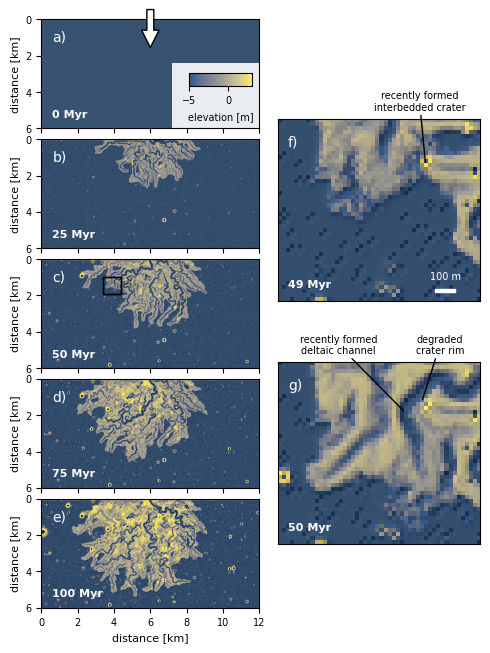

In [25]:
# make a timeseries for the LPSC poster / paper
fig, ax = plt.subplots(
    5, 1, figsize=(5, 6.5),
    sharey=True, sharex=True,
    gridspec_kw=dict(
        right=0.62, bottom=0.075, top=0.98, left=0.02, hspace=0.1, wspace=0.05))

# time_idxs = np.linspace(0, csfd_cube.shape[0]-1, num=5, endpoint=True, dtype=int)
time_idxs = [0, 50, 100, 150, 212]
for i, time_idx in enumerate(time_idxs):
    ls = LightSource(azdeg=315, altdeg=45)
    hs = ls.hillshade(
        np.array(csfd_cube['eta'][time_idx, :, :]).squeeze(),
        vert_exag=8, dx=20, dy=20)

    ax[i].imshow(hs, cmap='gray', extent=csfd_cube.extent)
    im = ax[i].imshow(
        csfd_cube['eta'][time_idx],
        extent=csfd_cube.extent,
        cmap='cividis', vmin=-5, vmax=3, alpha=0.75)
    
    ax[i].text(
        0.05, 0.1,
        f'{25*i} Myr',
        # f'{csfd_cube.t[time_idx]:.0f} Ma',
        color='white', fontsize=_label_fontsize,  weight='bold',
        transform=ax[i].transAxes)

axbounds = ax[0].get_position().bounds # colorbar for array in ax[0,0]
cbax = fig.add_axes([axbounds[0]+axbounds[2]-0.14, axbounds[1]+0.065, 0.125, 0.02])
cb = plt.colorbar(im, cax=cbax,orientation='horizontal',)
cb.ax.tick_params(labelsize=_tick_fontsize)
cb.set_label('elevation [m]', fontsize=_tick_fontsize)
cb.minorticks_off()
cb.ax.yaxis.offsetText.set_fontsize(_tick_fontsize-1)
rect = patches.Rectangle(
    (0.6, 0), 0.7, 0.6,
    facecolor='white', alpha=0.9, transform=ax[0].transAxes)
ax[0].add_patch(rect)

arrow = matplotlib.patches.FancyArrowPatch(
    (6000, -700), (6000, 1700),
    mutation_scale=25, facecolor='w', edgecolor='k', clip_on=False, zorder=5)
ax[0].add_patch(arrow)

for axi in ax.ravel():
    axi.tick_params(labelsize=_tick_fontsize)
    axi.set_ylabel('distance [km]', fontsize=_label_fontsize)
    dm.plot.style_axes_km(axi)

ax[-1].set_xlabel('distance [km]', fontsize=_label_fontsize)
ax[0].set_ylabel('distance [km]', fontsize=_label_fontsize)

gs2 = fig.add_gridspec(
    2, 1,
    right=0.98, bottom=0.15, top=0.85, left=0.575, hspace=0.15, wspace=0.05)
gs2_ax = []

time_idxs_zoom = [98, 100]
near_left_ax = 2
zoom_range = ((3400, 4400), (1000, 1900))
for i, time_idx in enumerate(time_idxs_zoom):
    ls = LightSource(azdeg=315, altdeg=45)
    hs = ls.hillshade(
        np.array(csfd_cube['eta'][time_idx, :, :]).squeeze(),
        vert_exag=8, dx=20, dy=20)

    axi = fig.add_subplot(gs2[i])
    axi.imshow(hs, cmap='gray', extent=csfd_cube.extent)
    im = axi.imshow(
        csfd_cube['eta'][time_idx],
        extent=csfd_cube.extent,
        cmap='cividis', vmin=-5, vmax=2, alpha=0.75)
    
    dt_interval = np.round((100 / csfd_cube.shape[0]), 1)
    axi.text(
        0.05, 0.075, f'{dt_interval*time_idx:.0f} Myr',
        color='white', fontsize=_label_fontsize, weight='bold',
        transform=axi.transAxes)
    
    zoom_rect = patches.Rectangle(
        (zoom_range[0][0], zoom_range[1][0]),
        (zoom_range[0][1] - zoom_range[0][0]),
        (zoom_range[1][1] - zoom_range[1][0]), edgecolor='k', facecolor='none')
    ax[near_left_ax].add_patch(zoom_rect)
    
    axi.tick_params(labelsize=_tick_fontsize)
    axi.set_xlim(zoom_range[0][0], zoom_range[0][1])
    axi.set_ylim(zoom_range[1][1], zoom_range[1][0])
    axi.set_xticks([])
    axi.set_yticks([])
    gs2_ax.append(axi)
    
scalebar = AnchoredSizeBar(
    gs2_ax[0].transData,
    100, '100 m', 'lower left', 
    bbox_to_anchor=(0.75, 0.05),
    bbox_transform=gs2_ax[0].transAxes,
    pad=0,
    sep=5,
    borderpad=0,
    color='w',
    frameon=False,
    size_vertical=15, label_top=True,
    fontproperties=dict(size=_tick_fontsize)
)
gs2_ax[0].add_artist(scalebar)

gs2_ax[0].annotate(
    'recently formed\ninterbedded crater',
    xytext=(4100, zoom_range[1][0]-40), xy=(4130, 1230),
    annotation_clip=False, fontsize=_tick_fontsize, ha='center',
    arrowprops=dict(arrowpropsdict, edgecolor='k'))
gs2_ax[1].annotate(
    'recently formed\ndeltaic channel',
    xytext=(3700, zoom_range[1][0]-40), xy=(4030, 1250),
    annotation_clip=False, fontsize=_tick_fontsize, ha='center',
    arrowprops=dict(arrowpropsdict, edgecolor='k'))
gs2_ax[1].annotate(
    'degraded\ncrater rim',
    xytext=(4200, zoom_range[1][0]-40), xy=(4110, 1200),
    annotation_clip=False, fontsize=_tick_fontsize, ha='center',
    arrowprops=dict(arrowpropsdict, edgecolor='k'))

    
for i, axi in enumerate(ax):
    _panel_labeler(i, axi, x=0.05, color='white')
for i, axi in enumerate(gs2_ax):
    _panel_labeler(i+5, axi, y=0.85, x=0.05, color='white')


# ax[-1].set_xlabel('distance [km]', fontsize=_label_fontsize)
# ax[0].set_ylabel('distance [km]', fontsize=_label_fontsize)

fig.set_facecolor('none')

plt.savefig(os.path.join(figure_root, 'simulation_csfd_100Ma_timeseries.png'), dpi=600)
plt.savefig(os.path.join(figure_root, 'simulation_csfd_100Ma_timeseries.pdf'), dpi=300)
plt.show()

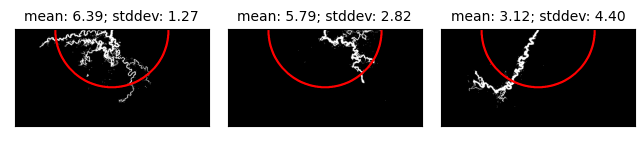

In [26]:
# look at channel widths, and make figure for supplement

fig, ax = plt.subplots(1, 3, figsize=(8,3), gridspec_kw={'wspace': 0.1})

proximal_widths_list = []
distal_widths_list = []
proximal_depths_list = []
distal_depths_list = []
for i, fldr in enumerate(timescales_examples_list[:]):
    # make cube
    _cube = dm.cube.DataCube(os.path.join(fldr, 'pyDeltaRCM_output.nc'), varset=varset)

    em = dm.mask.ElevationMask(
        _cube['eta'][-1],
        elevation_threshold=_cube.meta['H_SL'][-1])
    fm = dm.mask.FlowMask(
        _cube['velocity'][-1],
        flow_threshold=0.5)
    mp = dm.plan.MorphologicalPlanform(em, 10)
    cm = dm.mask.ChannelMask.from_Planform_and_FlowMask(
        mp, fm)
    
    proximal_widths_list_radii = []
    proximal_depths_list_radii = []
    radii = [1000, 1500]
    for j, radius in enumerate(radii):
        # compute the metric
        sec = dm.section.CircularSection(_cube, radius=radius)
        m, s, w = dm.plan.compute_channel_width(
            cm, section=sec, return_widths=True)
        proximal_widths_list_radii.append(w)
        m, s, d = dm.plan.compute_channel_depth(
            cm, (_cube['stage'][-1] - _cube['eta'][-1]), section=sec, return_depths=True)
        proximal_depths_list_radii.append(d)
        
    distal_widths_list_radii = []
    distal_depths_list_radii = []
    radii = [3000, 3500]
    for j, radius in enumerate(radii):
        # compute the metric
        sec = dm.section.CircularSection(_cube, radius=radius)
        m, s, w = dm.plan.compute_channel_width(
            cm, section=sec, return_widths=True)
        distal_widths_list_radii.append(w)
        m, s, d = dm.plan.compute_channel_depth(
            cm, (_cube['stage'][-1] - _cube['eta'][-1]), section=sec, return_depths=True)
        distal_depths_list_radii.append(d)
        
    proximal_widths_list.append(np.hstack(proximal_widths_list_radii))
    distal_widths_list.append(np.hstack(distal_widths_list_radii))
    proximal_depths_list.append(np.hstack(proximal_depths_list_radii))
    distal_depths_list.append(np.hstack(distal_depths_list_radii))
    
    cm.show(ax=ax[i], ticks=True)
    sec.show_trace('r-', ax=ax[i])
    ax[i].set_title(f'mean: {m:.2f}; stddev: {s:.2f}', fontsize=10)
    
for axi in ax.ravel():
    axi.tick_params(labelsize=_tick_fontsize)
    axi.set_xticks([])
    axi.set_yticks([])
    
plt.show()

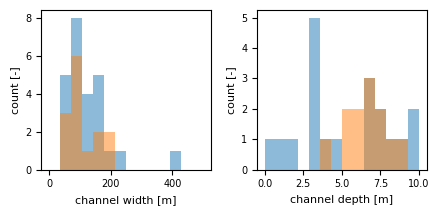

mean channel width is 118 +- 68
mean channel depth is 7 +- 3


In [27]:
# make arrays of both proximal and distal lists
proximal_widths = np.hstack(proximal_widths_list)
distal_widths = np.hstack(distal_widths_list)
proximal_depths = np.hstack(proximal_depths_list)
distal_depths = np.hstack(distal_depths_list)
# clean out 1 or 2 pixel matches
proximal_depths = proximal_depths[proximal_widths >= 40]  # use widths to drop
distal_depths = distal_depths[distal_widths >= 40]  # use widths to drop
proximal_widths = proximal_widths[proximal_widths >= 40]
distal_widths = distal_widths[distal_widths >= 40]

widths_bins = np.linspace(0, 500, num=15)
depths_bins = np.linspace(0, 10, num=15)

# figure
fig, ax =  plt.subplots(1, 2, figsize=(4.5, 2.25))
ax[0].hist(proximal_widths, widths_bins, alpha=0.5, label='proximal')
ax[0].hist(distal_widths, widths_bins, alpha=0.5, label='distal')
ax[0].set_xlabel('channel width [m]', fontsize=_label_fontsize)
ax[0].set_ylabel('count [-]', fontsize=_label_fontsize)

ax[1].hist(proximal_depths, depths_bins, alpha=0.5, label='proximal')
ax[1].hist(distal_depths, depths_bins, alpha=0.5, label='distal')
ax[1].set_xlabel('channel depth [m]', fontsize=_label_fontsize)
ax[1].set_ylabel('count [-]', fontsize=_label_fontsize)

for axi in ax.ravel():
    axi.tick_params(labelsize=_tick_fontsize)

plt.tight_layout()
plt.show()

# no difference between proximal and distal, so just provide a summary metric for the paper
print(f"mean channel width is {np.mean(np.hstack([proximal_widths, distal_widths])):.0f} +- {np.std(np.hstack([proximal_widths, distal_widths])):.0f}")
print(f"mean channel depth is {np.mean(np.hstack([proximal_depths, distal_depths])):.0f} +- {np.std(np.hstack([proximal_depths, distal_depths])):.0f}")

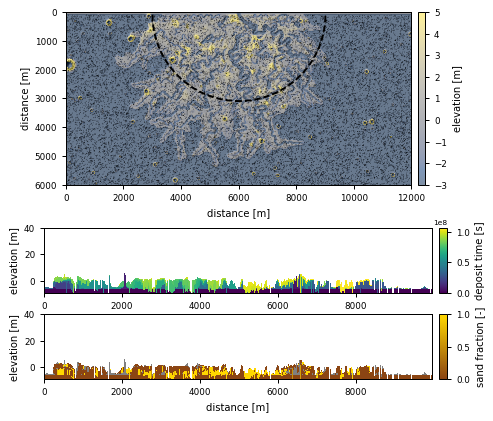

In [28]:
csfd_strat.register_section('strike', dm.section.StrikeSection(distance=180))
csfd_strat.register_section('circ', dm.section.CircularSection(radius=3000))
csfd_strat.register_section('bound', dm.section.CircularSection(radius=1400, origin_idx=(0, csfd_strat.shape[2]//2)))

ls = LightSource(azdeg=315, altdeg=45)
hs = ls.hillshade(np.array(csfd_cube['eta'][-1, :, :]).squeeze(), vert_exag=2, dx=10, dy=10)

fig = plt.figure(dpi=90)
ax0 = fig.add_axes([0.1, 0.55, 0.7, 0.4])
# cube.quick_show('eta', idx=-1, ticks=True, ax=ax0)
ax0.imshow(hs, cmap='gray', extent=csfd_cube.extent)
im = ax0.imshow(
    csfd_cube['eta'][-1],
    extent=csfd_cube.extent,
    cmap='cividis', vmin=-3, vmax=5, alpha=0.5)
cb = dm.plot.append_colorbar(im, ax=ax0)
cb.ax.tick_params(labelsize=_tick_fontsize)
cb.set_label('elevation [m]', fontsize=_label_fontsize)
cb.minorticks_off()
cb.ax.yaxis.offsetText.set_fontsize(_tick_fontsize-1)

csfd_strat.sections['circ'].show_trace('k--', ax=ax0)

patch_list = []
for index, row in df_log_csfd.iterrows():
    circ = patches.Circle(
        (row['location_x'], row['location_y']), radius=row['diameter']/2,
        edgecolor='k')
    patch_list.append(circ)
p = collections.PatchCollection(patch_list, facecolor='none', linewidth=0.2, linestyle='-')
ax0.add_collection(p)

ax1 = fig.add_axes([0.1, 0.3, 0.7, 0.15])
ax2 = fig.add_axes([0.1, 0.1, 0.7, 0.15])
csfd_strat.sections['circ'].show('time', ax=ax1)
cb = ax1.collections[-1].colorbar
cb.ax.tick_params(labelsize=_tick_fontsize)
cb.set_label('deposit time [s]', fontsize=_label_fontsize)
cb.ax.yaxis.offsetText.set_fontsize(_tick_fontsize-1)

csfd_strat.sections['circ'].show('sandfrac', ax=ax2)
cb = ax2.collections[-1].colorbar
cb.ax.tick_params(labelsize=_tick_fontsize)
cb.set_label('sand fraction [-]', fontsize=_label_fontsize)
cb.ax.yaxis.offsetText.set_fontsize(_tick_fontsize-1)

ax0.set_xlabel('distance [m]', fontsize=_label_fontsize)
ax0.set_ylabel('distance [m]', fontsize=_label_fontsize)
ax2.set_xlabel('distance [m]', fontsize=_label_fontsize)
ax1.set_ylabel('elevation [m]', fontsize=_label_fontsize)
ax2.set_ylabel('elevation [m]', fontsize=_label_fontsize)

fig.set_facecolor('none')

for axi in [ax1, ax2]:
    axi.set_ylim(-9, 40)
    
for axi in [ax0, ax1, ax2]:
    axi.tick_params(labelsize=_tick_fontsize)
    
fig.savefig(os.path.join(figure_root, 'supp_circular_section.png'), dpi=300, transparent=False, facecolor='none')
fig.savefig(os.path.join(figure_root, 'supp_circular_section.pdf'), dpi=300, transparent=False, facecolor='white')

fig.set_facecolor('none')

### interactive sliders

In [ ]:
%%capture
_frzn = csfd_strat.export_frozen_variable('crater_rim')

fig4, ax4 = plt.subplots(dpi=200)
ax4.imshow(hs, cmap='gray', extent=csfd_cube.extent)  # add the hillshade
_cidx_cmap, _cidx_norm = _make_crateridx_cmap(len(df_log_csfd))
im4 = ax4.imshow(
    csfd_strat['crater_rim'][-1, :, :], cmap=_cidx_cmap,   interpolation='none', alpha=1,
    extent=csfd_strat.extent, vmin=0, vmax=len(df_log_csfd))
dm.plot.append_colorbar(im4, ax4)

patch_list = []
for index, row in df_log_csfd.iterrows():
    circ = patches.Circle(
        (row['location_x'], row['location_y']), radius=row['diameter']/2,
        edgecolor='k', linestyle=':', linewidth=0.5)
    patch_list.append(circ)
p = collections.PatchCollection(patch_list, facecolor='none', linewidth=0.5)
ax4.add_collection(p)

ax4.set_title('stratigraphic slices of crater ID', fontsize=9)
ax4.tick_params(labelsize=7)

csfd_strat.sections['circ'].show_trace('r', ax=ax0)

ax4.set_xlim(2900, 4500)
ax4.set_ylim(1600, 0)

def _update_strat_slice2(idx):
    # slc = _frzn[idx, :, :]
    slc = _frzn[idx, :, :]
    im4.set_data(slc)
    fig4.canvas.draw()
    display(fig4)

In [ ]:
interact(_update_strat_slice2, idx=widgets.IntSlider(min=0, max=csfd_strat.shape[0]-1, step=1, value=0));

In [ ]:
%%capture
_frzn = csfd_strat.export_frozen_variable('sandfrac')

fig0, ax0 = plt.subplots(dpi=200)
ax0.set_title('stratigraphic slices of sand fraction', fontsize=9)
im0 = ax0.imshow(
    csfd_strat['sandfrac'][-1, :, :],
    extent=csfd_strat.extent, cmap=csfd_strat.varset['sandfrac'].cmap, norm=csfd_strat.varset['sandfrac'].norm, vmin=csfd_strat.varset['sandfrac'].vmin, vmax=1)
dm.plot.append_colorbar(im0, ax0)

patch_list = []
for index, row in df_log_csfd.iterrows():
    circ = patches.Circle(
        (row['location_x'], row['location_y']), radius=row['diameter']/2,
        edgecolor='k')
    patch_list.append(circ)
p = collections.PatchCollection(patch_list, facecolor='none', linewidth=0.5)
ax0.add_collection(p)

csfd_strat.sections['circ'].show_trace('r', ax=ax0)

ax0.tick_params(labelsize=7)


def _update_strat_slice(idx):
    slc = _frzn[idx, :, :]
    im0.set_data(slc)
    fig0.canvas.draw()
    display(fig0)

In [ ]:
interact(_update_strat_slice, idx=widgets.IntSlider(min=0, max=csfd_strat.shape[0]-1, step=1, value=0));

In [ ]:
%%capture

fig1, ax1 = plt.subplots(dpi=200)
ax1.set_title('timeseries of bed elevation', fontsize=9)
im1 = ax1.imshow(
    csfd_cube['eta'][0, :, :],
    extent=csfd_strat.extent, cmap=csfd_strat.varset['eta'].cmap, norm=csfd_strat.varset['eta'].norm, vmin=-1, vmax=1)
dm.plot.append_colorbar(im1, ax1)
# ax1.plot(d1*dx, d0*dx, 'ro', mfc='none')

patch_list = []
for index, row in df_log_csfd.iterrows():
    circ = patches.Circle(
        (row['location_x'], row['location_y']), radius=row['diameter']/2,
        edgecolor='k')
    patch_list.append(circ)
p = collections.PatchCollection(patch_list, facecolor='none', linewidth=0.5)
ax1.add_collection(p)

# strat.sections['circ'].show_trace('r', ax=ax1)

ax1.set_xlim(2900, 4500)
ax1.set_ylim(1600, 0)

def _update_data_slice(idx):
    slc = csfd_cube['eta'][idx, :, :]
    im1.set_data(slc)
    fig1.canvas.draw()
    display(fig1)


In [ ]:
interact(_update_data_slice, idx=widgets.IntSlider(min=0, max=csfd_cube.shape[0]-1, step=1, value=169));

# process the full csfd folder set
Loop through the full set of folders and make one long datatable

In [29]:
# parallel func
import time

def process_a_cube_to_df_stats(fldr, i):
    cube = dm.cube.DataCube(os.path.join(fldr, 'pyDeltaRCM_output.nc'), varset=varset)
    strat = dm.cube.StratigraphyCube.from_DataCube(cube, z=np.arange(-10, 15, step=0.1))
    strat.register_section('bound', dm.section.CircularSection(
        radius=1400, origin_idx=(0, cube.shape[2]//2))
        )

    lines = read_log(fldr)
    df_log = process_log(lines, log_ID=str(i))

    df_stats_i = compute_preservation_from_df_cubes(df_log, cube=cube, strat=strat)
    return df_stats_i

PROCESS_FLAG = False
PARALLEL_FLAG = True
if PROCESS_FLAG:
    if PARALLEL_FLAG:
        # process in parallel
        folders_to_process = csfd_matrix_fldrs
        list_df_stats = joblib.Parallel(
            n_jobs=3, backend='loky', prefer='processes',
            verbose=100)(
                joblib.delayed(process_a_cube_to_df_stats)(fldr, i) for fldr, i in zip(csfd_matrix_fldrs, range(len(folders_to_process))))
    else:
        list_df_stats = []
        for i, fldr in enumerate(csfd_matrix_fldrs):
            i_df_stats = process_a_cube_to_df_stats(fldr, i)
            list_df_stats.append(i_df_stats)
        
    csfd_df = pd.concat(list_df_stats, ignore_index=True)
    csfd_df.to_csv('./crater_data/csfd_preserved_metrics.csv', index=False)
else:
    # load the full df
    csfd_df = pd.read_csv('./crater_data/csfd_preserved_metrics.csv')

csfd_df

,timestep,time,crateridx,diameter,ref_elev,location_x,location_y,p_SLR,p_f_bedload,p_crater_accumulation_duration,...,log_ID,distance_inlet,interbedded,rim_frac,ejecta_frac,rim_frac_sfc,rim_degree_cov,rim_degree_consec,rim_degree_consec_aboveref,rim_degree_consec_top
0,91,970666.7,1,12.3,-6.0,8150.0,1190.0,1.000000e-08,0.5,1.0,...,0,2437.416665,False,1.0,NaN,0.0,NaN,360.0,360.0,NaN
1,111,1184000.0,2,14.9,-6.0,3990.0,4970.0,1.000000e-08,0.5,1.0,...,0,5279.412846,False,1.0,1.0,0.0,NaN,360.0,360.0,NaN
2,145,1546666.7,3,10.5,-6.0,4230.0,4250.0,1.000000e-08,0.5,1.0,...,0,4522.322412,False,1.0,NaN,0.0,NaN,360.0,360.0,NaN
3,149,1589333.3,4,11.4,-6.0,1810.0,5690.0,1.000000e-08,0.5,1.0,...,0,6990.064377,False,1.0,NaN,0.0,NaN,360.0,360.0,NaN
4,151,1610666.7,5,11.1,-6.0,10570.0,3090.0,1.000000e-08,0.5,1.0,...,0,5488.916104,False,1.0,NaN,0.0,NaN,360.0,360.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
180839,9996,106624000.0,18181,17.2,-6.6,1550.0,4290.0,1.000000e-08,0.5,100.0,...,26,6111.382822,False,NaN,NaN,NaN,NaN,0.0,0.0,NaN
180840,9999,106656000.0,18182,18.3,-7.6,10430.0,4150.0,1.000000e-08,0.5,100.0,...,26,6030.538948,False,NaN,NaN,NaN,NaN,0.0,0.0,NaN
180841,9999,106656000.0,18183,15.8,-4.2,10530.0,190.0,1.000000e-08,0.5,100.0,...,26,4551.329476,False,NaN,NaN,NaN,NaN,0.0,0.0,NaN
180842,9999,106656000.0,18184,28.7,-6.5,9910.0,4730.0,1.000000e-08,0.5,100.0,...,26,6088.300255,False,NaN,NaN,NaN,NaN,0.0,0.0,NaN


# examine the size-frequency distribution (csfd) model results

In [30]:
# filter out the sfd runs
csfd_interbedded = csfd_df[csfd_df['interbedded']]
csfd_interbedded

,timestep,time,crateridx,diameter,ref_elev,location_x,location_y,p_SLR,p_f_bedload,p_crater_accumulation_duration,...,log_ID,distance_inlet,interbedded,rim_frac,ejecta_frac,rim_frac_sfc,rim_degree_cov,rim_degree_consec,rim_degree_consec_aboveref,rim_degree_consec_top
39,2257,24074666.7,40,11.5,-1.1,5610.0,1970.0,1.000000e-08,0.5,1.0,...,0,1925.876424,True,1.000,NaN,0.000,NaN,360.0,240.0,NaN
59,3328,35498666.7,60,10.1,-0.7,6410.0,1590.0,1.000000e-08,0.5,1.0,...,0,1570.031847,True,0.000,NaN,0.000,NaN,0.0,0.0,NaN
63,3489,37216000.0,64,12.9,-0.7,4850.0,3090.0,1.000000e-08,0.5,1.0,...,0,3215.120527,True,0.000,NaN,0.125,NaN,0.0,0.0,NaN
69,3936,41984000.0,70,15.4,-1.2,7990.0,1050.0,1.000000e-08,0.5,1.0,...,0,2231.815405,True,1.000,0.916667,0.375,NaN,360.0,360.0,NaN
73,4031,42997333.3,74,30.9,-1.8,3570.0,450.0,1.000000e-08,0.5,1.0,...,0,2438.237068,True,0.125,0.300000,0.000,NaN,0.0,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
180553,9838,104938666.7,17895,15.6,-1.6,4750.0,990.0,1.000000e-08,0.5,100.0,...,26,1530.032679,True,0.000,0.250000,0.000,NaN,0.0,0.0,NaN
180559,9840,104960000.0,17901,13.0,-1.6,5390.0,430.0,1.000000e-08,0.5,100.0,...,26,686.002915,True,1.000,NaN,0.000,NaN,360.0,240.0,NaN
180560,9841,104970666.7,17902,11.2,-0.0,4530.0,890.0,1.000000e-08,0.5,100.0,...,26,1660.903369,True,0.875,NaN,0.000,NaN,315.0,360.0,NaN
180569,9845,105013333.3,17911,16.0,2.2,5270.0,1090.0,1.000000e-08,0.5,100.0,...,26,1234.584950,True,1.000,1.000000,0.000,NaN,360.0,360.0,NaN


In [31]:
# count how many interbedded craters are generated in each simulation, and grouped by duration
print("number of interbedded craters in each simulation duration:")
csfd_interbedded.groupby(['p_crater_accumulation_duration', 'log_ID'], as_index=False)['crateridx'].size().groupby('p_crater_accumulation_duration').agg({'size': [min, max, np.mean]})

number of interbedded craters in each simulation duration:


size                   
                                 min   max         mean
p_crater_accumulation_duration                         
1.0                               10    33    22.555556
10.0                             191   279   249.777778
100.0                           1625  2894  2695.333333

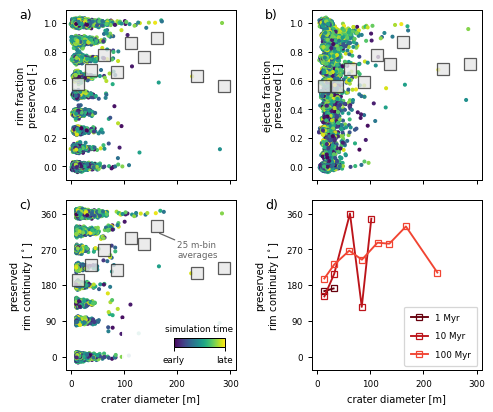

In [32]:
csfd_interbedded_shuffle = csfd_interbedded.sample(frac=1, random_state=1).reset_index()

fig, ax = plt.subplots(
    2, 2, figsize=(5.5, 4.5), dpi=90, sharex=True,
    gridspec_kw=dict(
        hspace=0.12, wspace=0.3,
        left=0.1, right=0.98, top=0.98, bottom=0.09))

y_noise = np.random.normal(0, 1 * 0.01, size=len(csfd_interbedded_shuffle))
x_noise = np.random.normal(0, 300 * 0.01, size=len(csfd_interbedded_shuffle))

groups = csfd_interbedded_shuffle.groupby(pd.cut(csfd_interbedded_shuffle.diameter, np.arange(0, 325, step=25)))
midpt = [(a.left + a.right)/2 for a in groups.mean().index]
mean_pts_kw = dict(mec='0.2', ls='none', mfc='0.9', marker='s', alpha=0.8, ms=10)

ax[0,0].scatter(
    csfd_interbedded_shuffle['diameter']+x_noise,
    csfd_interbedded_shuffle['rim_frac']+y_noise,
    c=csfd_interbedded_shuffle['crateridx'], marker='.', s=20, alpha=1)
ax[0,0].set_ylabel('rim fraction\npreserved [-]', fontsize=_label_fontsize)
# ax[0,0].set_xlabel('crater diameter [m]', fontsize=_label_fontsize)
ax[0,0].set_xlim(-10, 310)
ax[0,0].plot(
    midpt, groups.mean()['rim_frac'], **mean_pts_kw)

ax[0,1].scatter(
    csfd_interbedded_shuffle['diameter']+x_noise,
    csfd_interbedded_shuffle['ejecta_frac']+y_noise,
    c=csfd_interbedded_shuffle['crateridx'], s=20, marker='.')
ax[0,1].set_ylabel('ejecta fraction\npreserved [-]', fontsize=_label_fontsize)
# ax[0,1].set_xlabel('crater diameter [m]', fontsize=_label_fontsize)
ax[0,1].set_xlim(-10, 310)
ax[0,1].plot(
    midpt, groups.mean()['ejecta_frac'], **mean_pts_kw)

sc = ax[1,0].scatter(
    csfd_interbedded_shuffle['diameter'],
    csfd_interbedded_shuffle['rim_degree_consec']+y_noise*360,
    c=csfd_interbedded_shuffle['crateridx'], s=20, marker='.')
ax[1,0].set_ylabel('preserved\nrim continuity [$^\\circ$]', fontsize=_label_fontsize)
ax[1,0].set_xlabel('crater diameter [m]', fontsize=_label_fontsize)
ax[1,0].set_xlim(-10, 310)
ax[1,0].set_yticks(np.linspace(0, 360, endpoint=True, num=5))
ax[1,0].plot(
    midpt, groups.mean()['rim_degree_consec'],  **mean_pts_kw)

sm = matplotlib.cm.ScalarMappable(cmap='viridis', norm=matplotlib.colors.Normalize(vmin=0, vmax=1))
ovax = inset_axes(ax[1,0], width="30%", height="5%", bbox_to_anchor=(.6, .1, 1, 1), bbox_transform=ax[1,0].transAxes, loc=3)
fmt = lambda x, pos: '{:g}'.format(x)
cb = fig.colorbar(
    sm, cax=ovax, orientation='horizontal', format=FuncFormatter(fmt))
ovax.set_xticks((0,1))
ovax.set_xticklabels(('early', 'late'))
ovax.set_title('simulation time', fontsize=_tick_fontsize)
ovax.xaxis.set_tick_params(labelsize=_tick_fontsize)
rect = patches.Rectangle(
    (0.33, 0), 0.7, 0.3,
    facecolor='white', alpha=0.9, transform=ax[1,0].transAxes)
ax[1,0].add_patch(rect)
ax[1,0].annotate(
    '25 m-bin\naverages',
    xy=(midpt[6], groups.mean()['rim_degree_consec'][6]+120),
    xytext=(200, 250), fontsize=_tick_fontsize, color=arrowpropsdict['edgecolor'],
    arrowprops=arrowpropsdict, zorder=0)


# groupy presevration by flux rate and by size bins
sfd_stats = csfd_df[(csfd_df['p_crater_size'] == -1)]
csfd_interbedded = csfd_df[csfd_df['interbedded']]

groups = csfd_interbedded.groupby([csfd_interbedded['p_crater_accumulation_duration'], pd.cut(csfd_interbedded['diameter'], np.arange(0, 300, step=25))])
midpt = [(a.left + a.right)/2 for a in groups.mean(numeric_only=True).unstack(level=0).index]

cmap = matplotlib.colors.ListedColormap(
    matplotlib.colormaps['Reds_r'].resampled(6)(np.arange(0, 3))) # one color for each timescale
grp_mean = groups.mean(numeric_only=True).unstack()
grp_std = groups.std(numeric_only=True).unstack()
for i, flux_group in enumerate(grp_mean['rim_degree_consec'].index):
    
    idata = grp_mean.iloc[i] #[grp_mean.index == flux_group]
    idata_mask = np.isfinite(idata['rim_degree_consec'].values)
    
    idata_diameter = idata['diameter'][idata_mask].values
    idata_value = idata['rim_degree_consec'][idata_mask].values
    idata_std = grp_std.iloc[i]['rim_degree_consec'][idata_mask].values

    ax[1,1].plot(
        idata_diameter,
        idata_value,
        marker='s', mec=cmap(i), linestyle='-', mfc='none', ms=5, color=cmap(i),
        label=f'{flux_group:g} Myr')

ax[1,1].legend(fontsize=_tick_fontsize, loc='lower right', labelspacing=1.1, borderpad=0.75)
ax[1,1].tick_params(labelsize=_tick_fontsize)
ax[1,1].set_ylabel('preserved\nrim continuity [$^\\circ$]', fontsize=_label_fontsize)
ax[1,1].set_xlabel('crater diameter [m]', fontsize=_label_fontsize)
ax[1,1].set_yticks(np.linspace(0, 360, endpoint=True, num=5))
ax[1,1].set_ylim(ax[1,0].get_ylim())
ax[1,1].set_xlim(-10, 310)


for axi in ax.ravel():
    axi.tick_params(labelsize=_tick_fontsize)
    axi.set_aspect(1.0/axi.get_data_ratio())
for i, axi in enumerate(ax.ravel()):
    _panel_labeler(i, axi, x=-0.275, y=0.95, color='k')

fig.set_facecolor('none')

fig.savefig(os.path.join(figure_root, 'csfd_preserved_metrics.png'), dpi=300, transparent=False, facecolor='none')
fig.savefig(os.path.join(figure_root, 'csfd_preserved_metrics.pdf'), dpi=300, transparent=False, facecolor='white')

plt.show()

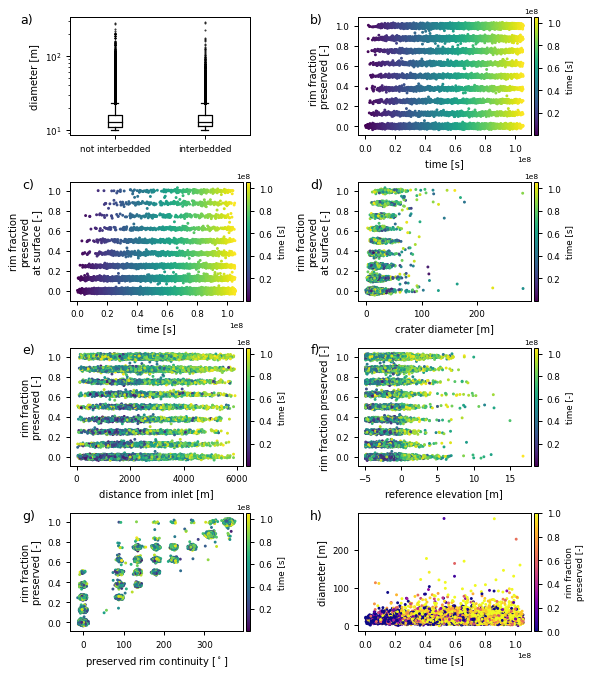

In [33]:
# make a single supplementary figure that ties together a bunch of the points we may want to show

fig, ax = plt.subplots(
    4, 2, figsize=(6.5, 7.5), dpi=90,
    gridspec_kw={
        'hspace': 0.4, 'wspace': 0.6,
        'left':0.1, 'right': 0.9,
        'bottom': 0.06, 'top': 0.97})

frac_noise = np.random.normal(0, 1 * 0.01, size=len(csfd_interbedded_shuffle))
consec_noise = np.random.normal(0, 360 * 0.01, size=len(csfd_interbedded_shuffle))
diam_noise = np.random.normal(0, 300 * 0.01, size=len(csfd_interbedded_shuffle))
time_noise = np.zeros(shape=len(csfd_interbedded_shuffle))
dist_noise = np.zeros(shape=len(csfd_interbedded_shuffle))

_fp = {'markersize': 1, 'marker': '.'}
_mp = {'color': 'k'}
ax[0,0].boxplot(csfd_df[~csfd_df['interbedded']].diameter, positions=[1], flierprops=_fp, medianprops=_mp)
ax[0,0].boxplot(csfd_df[csfd_df['interbedded']].diameter, positions=[2], flierprops=_fp, medianprops=_mp)
ax[0,0].set_yscale('log')
ax[0,0].set_xticklabels(['not interbedded', 'interbedded'], fontsize=_label_fontsize)
ax[0,0].set_ylabel('diameter [m]', fontsize=_label_fontsize)

sc = ax[0,1].scatter(
    csfd_interbedded_shuffle['time']+time_noise,
    csfd_interbedded_shuffle['rim_frac']+frac_noise,
    c=csfd_interbedded_shuffle['time'], marker='.', s=7)
ax[0,1].set_xlabel('time [s]', fontsize=_label_fontsize)
ax[0,1].set_ylabel('rim fraction\npreserved [-]', fontsize=_label_fontsize)
ax[0,1].xaxis.offsetText.set_fontsize(_tick_fontsize-1)
cb = dm.plot.append_colorbar(sc, ax=ax[0,1])
cb.ax.tick_params(labelsize=_tick_fontsize)
cb.ax.yaxis.offsetText.set(size=_tick_fontsize-1)
cb.set_label('time [s]', fontsize=_tick_fontsize)

sc = ax[1,0].scatter(
    csfd_interbedded_shuffle['time']+x_noise,
    csfd_interbedded_shuffle['rim_frac_sfc']+frac_noise,
    c=csfd_interbedded_shuffle['time'], marker='.', s=7)
ax[1,0].set_ylabel('rim fraction\npreserved\nat surface [-]', fontsize=_label_fontsize)
ax[1,0].set_xlabel('time [s]', fontsize=_label_fontsize)
ax[1,0].xaxis.offsetText.set_fontsize(_tick_fontsize-1)
cb = dm.plot.append_colorbar(sc, ax=ax[1,0])
cb.ax.tick_params(labelsize=_tick_fontsize)
cb.ax.yaxis.offsetText.set(size=_tick_fontsize-1)
cb.set_label('time [s]', fontsize=_tick_fontsize)

sc = ax[1,1].scatter(
    csfd_interbedded_shuffle['diameter']+diam_noise,
    csfd_interbedded_shuffle['rim_frac_sfc']+frac_noise,
    c=csfd_interbedded_shuffle['time'], marker='.', s=7)
ax[1,1].set_ylabel('rim fraction\npreserved\nat surface [-]', fontsize=_label_fontsize)
ax[1,1].set_xlabel('crater diameter [m]', fontsize=_label_fontsize)
ax[1,1].xaxis.offsetText.set_fontsize(_tick_fontsize-1)
cb = dm.plot.append_colorbar(sc, ax=ax[1,1])
cb.ax.tick_params(labelsize=_tick_fontsize)
cb.ax.yaxis.offsetText.set(size=_tick_fontsize-1)
cb.set_label('time [s]', fontsize=_tick_fontsize)

sc = ax[2,0].scatter(
    csfd_interbedded_shuffle['distance_inlet']+dist_noise,
    csfd_interbedded_shuffle['rim_frac']+frac_noise,
    c=csfd_interbedded_shuffle['time'],
    marker='.', s=7, cmap='viridis')
ax[2,0].set_ylabel('rim fraction\npreserved [-]', fontsize=_label_fontsize)
ax[2,0].set_xlabel('distance from inlet [m]', fontsize=_label_fontsize)
ax[2,0].tick_params(labelsize=_tick_fontsize)
ax[2,0].xaxis.offsetText.set_fontsize(_tick_fontsize-1)
cb = dm.plot.append_colorbar(sc, ax=ax[2,0])
cb.ax.tick_params(labelsize=_tick_fontsize)
cb.ax.yaxis.offsetText.set(size=_tick_fontsize-1)
cb.set_label('time [s]', fontsize=_tick_fontsize)

sc = ax[2,1].scatter(
    csfd_interbedded_shuffle['ref_elev'],
    csfd_interbedded_shuffle['rim_frac']+frac_noise,
    c=csfd_interbedded_shuffle['time'],
    marker='.', s=7, cmap='viridis')
ax[2,1].set_xlabel('reference elevation [m]', fontsize=_label_fontsize)
ax[2,1].set_ylabel('rim fraction preserved [-]', fontsize=_label_fontsize)
ax[2,1].tick_params(labelsize=_tick_fontsize)
ax[2,1].xaxis.offsetText.set_fontsize(_tick_fontsize-1)
cb = dm.plot.append_colorbar(sc, ax=ax[2,1])
cb.ax.tick_params(labelsize=_tick_fontsize)
cb.ax.yaxis.offsetText.set(size=_tick_fontsize-1)
cb.set_label('time [-]', fontsize=_tick_fontsize)


sc = ax[3,0].scatter(
    csfd_interbedded_shuffle['rim_degree_consec']+consec_noise,
    csfd_interbedded_shuffle['rim_frac']+frac_noise,
    c=csfd_interbedded_shuffle['time'],
    marker='.', s=7, cmap='viridis')
ax[3,0].set_xlabel('preserved rim continuity [$^\\circ$]', fontsize=_label_fontsize)
ax[3,0].set_ylabel('rim fraction\npreserved [-]', fontsize=_label_fontsize)
ax[3,0].tick_params(labelsize=_tick_fontsize)
ax[3,0].xaxis.offsetText.set_fontsize(_tick_fontsize-1)
cb = dm.plot.append_colorbar(sc, ax=ax[3,0])
cb.ax.tick_params(labelsize=_tick_fontsize)
cb.ax.yaxis.offsetText.set(size=_tick_fontsize-1)
cb.set_label('time [s]', fontsize=_tick_fontsize)


sc = ax[3,1].scatter(
    csfd_interbedded_shuffle['time']+time_noise,
    csfd_interbedded_shuffle['diameter']+diam_noise,
    c=csfd_interbedded_shuffle['rim_frac'], marker='.', s=7, cmap='plasma')
ax[3,1].set_ylabel('diameter [m]', fontsize=_label_fontsize)
ax[3,1].set_xlabel('time [s]', fontsize=_label_fontsize)
ax[3,1].tick_params(labelsize=_label_fontsize)
ax[3,1].xaxis.offsetText.set_fontsize(_tick_fontsize-1)
cb = dm.plot.append_colorbar(sc, ax=ax[3,1])
cb.ax.tick_params(labelsize=_tick_fontsize)
cb.ax.yaxis.offsetText.set(size=_tick_fontsize-1)
cb.set_label('rim fraction\npreserved [-]', fontsize=_tick_fontsize)

for i, axi in enumerate(ax.ravel()):
    axi.tick_params(labelsize=_tick_fontsize)
    _panel_labeler(i, axi, x=-0.275, y=0.95, color='k')
    
fig.set_facecolor('none')

fig.savefig(os.path.join(figure_root, 'supp_preserved_total_metrics.png'), dpi=300, transparent=False, facecolor='none')
fig.savefig(os.path.join(figure_root, 'supp_preserved_total_metrics.pdf'), dpi=300, transparent=False, facecolor='white')

plt.show()

In [34]:
from scipy.stats import ttest_ind
print('Any diff between interbedded and not interbedded')
ttest_ind(csfd_df[~csfd_df['interbedded']].diameter, csfd_df[csfd_df['interbedded']].diameter, equal_var=False)

Any diff between interbedded and not interbedded


Ttest_indResult(statistic=-0.41111929540720427, pvalue=0.6809875424430376)

In [35]:
csfd_interbedded_small = csfd_interbedded[csfd_interbedded['diameter'] <= 50]
csfd_interbedded_larger = csfd_interbedded[csfd_interbedded['diameter'] > 50]
csfd_interbedded_largest = csfd_interbedded[csfd_interbedded['diameter'] > 150]

csfd_interbedded_5to15 = csfd_interbedded[(csfd_interbedded['diameter'] >= 5) & (csfd_interbedded['diameter'] <= 15)]
csfd_interbedded_55to65 = csfd_interbedded[(csfd_interbedded['diameter'] >= 55) & (csfd_interbedded['diameter'] <= 65)]


## SMALLER CRATERS
# what fraction of craters less than 50 m have been at least partioally eroded?
_frac_small_eroded = np.sum(csfd_interbedded_small['rim_degree_consec'] < 360) / len(csfd_interbedded_small)
print(f'Approximately {_frac_small_eroded*100:.0f}% of craters <= 50 m have been at least partially eroded, measured by rim continuity.')

_frac_small_eroded = np.sum(csfd_interbedded_small['rim_frac'] < 0.5) / len(csfd_interbedded_small)
print(f'Approximately {_frac_small_eroded*100:.0f}% of craters <= 50 m have been at least partially eroded, meaasured by rim area.')

# what fraction of craters less than 50 m have been eroded more than 180 degrees?
_frac_small_halfgone = np.sum(csfd_interbedded_small['rim_degree_consec'] < 180) / len(csfd_interbedded_small)
print(f'Approximately {_frac_small_halfgone*100:.0f}% of craters <= 50 m have less than 180 degrees remaining.')

# what fraction of craters less than 50 m have been eroded more than half of area?
_frac_small_halfgone = np.sum(csfd_interbedded_small['rim_frac'] < 0.5) / len(csfd_interbedded_small)
print(f'Approximately {_frac_small_halfgone*100:.0f}% of craters <= 50 m have less than half area remaining.')


## LARGER CRATERS
_frac_larger_eroded = np.sum(csfd_interbedded_larger['rim_degree_consec'] < 360) / len(csfd_interbedded_larger)
print(f'Approximately {_frac_larger_eroded*100:.0f}% of craters > 50 m have been at least partially eroded, measured by rim continuity.')

_frac_larger_eroded = np.sum(csfd_interbedded_larger['rim_frac'] < 0.5) / len(csfd_interbedded_larger)
print(f'Approximately {_frac_larger_eroded*100:.0f}% of craters > 50 m have been at least partially eroded, meaasured by rim area.')

# what fraction of craters less than 50 m have been eroded more than 180 degrees?
_frac_larger_halfgone = np.sum(csfd_interbedded_larger['rim_degree_consec'] < 180) / len(csfd_interbedded_larger)
print(f'Approximately {_frac_larger_halfgone*100:.0f}% of craters > 50 m have less than 180 degrees remaining.')

# what fraction of craters less than 50 m have been eroded more than half of area?
_frac_larger_halfgone = np.sum(csfd_interbedded_larger['rim_frac'] < 0.5) / len(csfd_interbedded_larger)
print(f'Approximately {_frac_larger_halfgone*100:.0f}% of craters > 50 m have less than half area remaining.')


## LARGEST CRATERS
_num_larger_than_150m = len(csfd_interbedded_largest)
print(f'There were only {_num_larger_than_150m:.0f} craters > 150 m simulated.')

_frac_largest_eroded = np.sum(csfd_interbedded_largest['rim_degree_consec'] < 360) / len(csfd_interbedded_largest)
print(f'Approximately {_frac_largest_eroded*100:.0f}% of craters > 150 m have been at least partially eroded, measured by rim continuity.')


## PROPORTIONS
num_times_more_small_than_large = len(csfd_interbedded_5to15) / len(csfd_interbedded_55to65)
print(f'Approximately {num_times_more_small_than_large:.2f} times more craters 5-15 than 55-65, '
      f'with {len(csfd_interbedded_5to15)} and {len(csfd_interbedded_55to65)}, respectively.')


Approximately 67% of craters <= 50 m have been at least partially eroded, measured by rim continuity.
Approximately 38% of craters <= 50 m have been at least partially eroded, meaasured by rim area.
Approximately 44% of craters <= 50 m have less than 180 degrees remaining.
Approximately 38% of craters <= 50 m have less than half area remaining.
Approximately 53% of craters > 50 m have been at least partially eroded, measured by rim continuity.
Approximately 19% of craters > 50 m have been at least partially eroded, meaasured by rim area.
Approximately 24% of craters > 50 m have less than 180 degrees remaining.
Approximately 19% of craters > 50 m have less than half area remaining.
There were only 7 craters > 150 m simulated.
Approximately 43% of craters > 150 m have been at least partially eroded, measured by rim continuity.
Approximately 340.78 times more craters 5-15 than 55-65, with 18743 and 55, respectively.


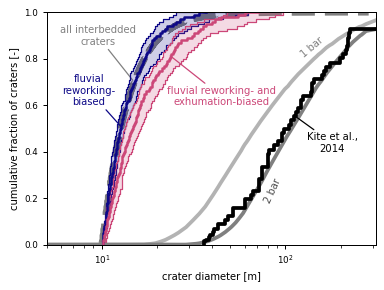

In [36]:
# cumulative distributions 

# modify the kite ecdfs for visiualization to reach edge of plot
kite_ecdf_mod = pd.concat([kite_ecdf, pd.DataFrame([[320, 0.93]], columns=['diameter [m]', 'measured ecdf [-]'])])
filtered_ecdf_mod = pd.concat([filtered_ecdf, pd.DataFrame([[275, 0.92, 0.95], [320, 0.93, 0.97]], columns=['diameter [m]', 'ecdf 1 bar [-]', 'ecdf 2 bar [-]'])])

np.random.seed(155) # doesn't matter, just for reproducibility of figures exactly as published

def ecdf(data):
    data_sorted = np.sort(data)
    # calculate the proportional values of samples
    p = 1. * np.arange(len(data), dtype=float) / float(len(data) - 1)
    return data_sorted, p

def filter_distribution_rules(distribution, variable, threshold, observable_diameter=30):
    threshed = distribution[~(distribution[variable] < threshold)]
    observed = threshed[threshed['diameter'] > observable_diameter]
    return observed['diameter']

fig, ax = plt.subplots(
    figsize=(4.25, 3), dpi=90,
    gridspec_kw=dict(
        hspace=0.075, wspace=0.3,
    left=0.12, right=0.98, top=0.98, bottom=0.12))

crater_flux_sort, crater_flux_p = ecdf(csfd_interbedded['diameter'])

# figure
ax.plot(
    crater_flux_sort, crater_flux_p, label='input distribution', color='0.5', ls='--', lw=5, zorder=0)
ax.plot(
    filtered_ecdf_mod['diameter [m]'], filtered_ecdf_mod['ecdf 1 bar [-]'],
    label='1 bar', color='0.5', lw=3) # 'mediumaquamarine'
ax.plot(
    filtered_ecdf_mod['diameter [m]'], filtered_ecdf_mod['ecdf 2 bar [-]'],
    label='2 bar', color='0.7', zorder=0, lw=3)
ax.step(
    kite_ecdf_mod['diameter [m]'], kite_ecdf_mod['measured ecdf [-]'],
    'k-', label='Kite et al., 2014', lw=3)

cdfs_cmap = plt.colormaps['plasma'].resampled(5)

# make a line for no exhumation correction, just fluvial preservation bias
n_mc = 50
mc_cdfs = np.zeros(shape=(101, n_mc))
for i in range(n_mc):
    mc_sample = np.random.choice(csfd_interbedded.index, size=56) # no probs, all equal
    sfd_mc_sample = csfd_interbedded.loc[mc_sample]
    sfd_mc_sample = sfd_mc_sample[sfd_mc_sample['rim_degree_consec'] >= 180]
    fi_sort, fi_p = ecdf(sfd_mc_sample.diameter)
    percs = np.linspace(0, 1, num=101)
    mc_cdfs[:, i] = np.interp(percs, fi_p, fi_sort)
ax.fill_betweenx(
    y=percs,
    x1=np.quantile(mc_cdfs, 0.16, axis=1),
    x2=np.quantile(mc_cdfs, 0.84, axis=1),
    step='pre',
    color=cdfs_cmap(0),
    alpha=1, facecolor='none')  # edgecolor='none'
ax.fill_betweenx(
    y=percs,
    x1=np.quantile(mc_cdfs, 0.16, axis=1),
    x2=np.quantile(mc_cdfs, 0.84, axis=1),
    step='pre',
    color=cdfs_cmap(0),
    alpha=0.2, edgecolor='none')
ax.step(
    np.median(mc_cdfs, axis=1), percs,
    label=f'median',
    color=cdfs_cmap(0), lw=2)



# make a CDF range with fluvial bias plus an exhumational correction proportional to diameter
size_min = csfd_interbedded.diameter.min()
size_max = csfd_interbedded.diameter.max()
# if linear proportional probablity
size_ratio = csfd_interbedded.diameter / size_min
probs = size_ratio / np.sum(size_ratio)
#   draw random samples at same n as Kite sample
mc_cdfs = np.zeros(shape=(101, n_mc))
for i in range(n_mc):
    mc_sample = np.random.choice(csfd_interbedded.index, size=56, p=probs)
    sfd_mc_sample = csfd_interbedded.loc[mc_sample]
    sfd_mc_sample = sfd_mc_sample[sfd_mc_sample['rim_degree_consec'] >= 180]
    fi_sort, fi_p = ecdf(sfd_mc_sample.diameter)
    percs = np.linspace(0, 1, num=101)
    mc_cdfs[:, i] = np.interp(percs, fi_p, fi_sort)
ax.fill_betweenx(
    y=percs,
    x1=np.quantile(mc_cdfs, 0.16, axis=1),
    x2=np.quantile(mc_cdfs, 0.84, axis=1),
    step='pre',
    color=dm.plot._scale_lightness(cdfs_cmap(2)[:3], 1),
    alpha=1, facecolor='none',)
ax.fill_betweenx(
    y=percs,
    x1=np.quantile(mc_cdfs, 0.16, axis=1),
    x2=np.quantile(mc_cdfs, 0.84, axis=1),
    step='pre',
    color=cdfs_cmap(2),
    alpha=0.2, edgecolor='none')
ax.step(
    np.median(mc_cdfs, axis=1), percs,
    label=f'median',
    color=cdfs_cmap(2), lw=2)


ax.annotate(
    'all interbedded\ncraters', 
    xy=(15, 0.7),
    xytext=(9.5, 0.86), fontsize=_label_fontsize, color='0.5', ha='center',
    arrowprops=dict(arrowpropsdict, edgecolor='0.5', linewidth=1), zorder=0)
ax.annotate(
    'fluvial\nreworking-\nbiased', 
    xy=(13, 0.5),
    xytext=(8.5, 0.60), fontsize=_label_fontsize, color=cdfs_cmap(0), ha='center',
    arrowprops=dict(arrowpropsdict, edgecolor=cdfs_cmap(0), linewidth=1), zorder=5)
ax.annotate(
    'fluvial reworking- and\nexhumation-biased', 
    xy=(23, 0.82),
    xytext=(45, 0.6), fontsize=_label_fontsize, color=cdfs_cmap(2), ha='center',
    arrowprops=dict(arrowpropsdict, edgecolor=cdfs_cmap(2), linewidth=1), zorder=0)
ax.annotate(
    'Kite et al.,\n2014', 
    xy=(110, 0.56), rotation=0,
    xytext=(180, 0.4), fontsize=_label_fontsize, color='k', ha='center',
    arrowprops=dict(arrowpropsdict, edgecolor='k', linewidth=1), zorder=2)
ax.text(
    85, 0.18, '2 bar', rotation=65,
    fontsize=_label_fontsize, color='0.3', 
    ha='center')
ax.text(
    140, 0.805, '1 bar', rotation=40,
    fontsize=_label_fontsize, color='0.5',
    ha='center')


ax.tick_params(labelsize=_tick_fontsize)

ax.set_ylabel('cumulative fraction of craters [-]', fontsize=_label_fontsize)
ax.set_xlabel('crater diameter [m]', fontsize=_label_fontsize)
ax.set_ylim(0, 1)
# ax.set_xlim(-10, 310)
ax.set_xscale('log')
ax.set_xlim(5, 310)

fig.set_facecolor('none')

fig.savefig(os.path.join(figure_root, 'csfd_preserved_cdfs.png'), dpi=300, transparent=False, facecolor='none')
fig.savefig(os.path.join(figure_root, 'csfd_preserved_cdfs.pdf'), dpi=300, transparent=False, facecolor='white')

plt.show()




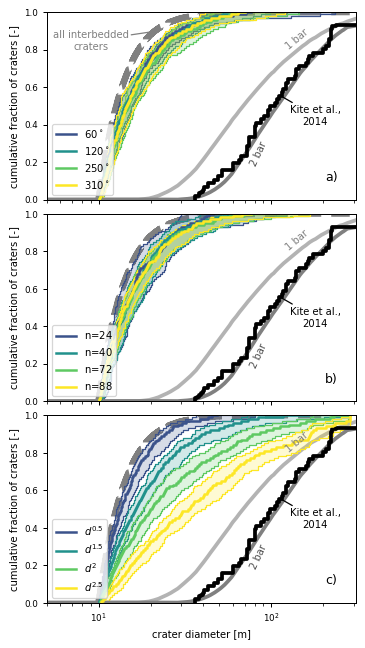

In [37]:
# what does exhumation look like if it is different proportionalities

np.random.seed(155) # doesn't matter, just for reproducibility of figures exactly as published

fig, ax = plt.subplots(3, 1,
    figsize=(4, 7.25), dpi=90, sharex=True,
    gridspec_kw=dict(
        hspace=0.075, wspace=0.3,
    left=0.12, right=0.98, top=0.98, bottom=0.075))

# figure
for axi in ax.ravel():
    axi.plot(
        crater_flux_sort, crater_flux_p, color='0.5', ls='--', lw=5, zorder=0)
    axi.plot(
        filtered_ecdf_mod['diameter [m]'], filtered_ecdf_mod['ecdf 1 bar [-]'],
        color='0.5', lw=3) # 'mediumaquamarine'
    axi.plot(
        filtered_ecdf_mod['diameter [m]'], filtered_ecdf_mod['ecdf 2 bar [-]'],
        color='0.7', zorder=0, lw=3)
    axi.step(
        kite_ecdf_mod['diameter [m]'], kite_ecdf_mod['measured ecdf [-]'],
        'k-', lw=3)

sensitivity_cmap = plt.colormaps['viridis'].resampled(5)

for p, threshold in enumerate([60, 120, 250, 310]):
    #   draw random samples at same n as Kite sample, with different fluvial reworked thresholds
    size_min = csfd_interbedded.diameter.min()
    size_max = csfd_interbedded.diameter.max()
    # if linear proportional probablity
    size_ratio = csfd_interbedded.diameter / size_min
    probs = size_ratio / np.sum(size_ratio)
    #   draw random samples at same n as Kite sample
    mc_cdfs = np.zeros(shape=(101, n_mc))
    mc_cdfs = np.zeros(shape=(101, n_mc))
    for i in range(n_mc):
        mc_sample = np.random.choice(csfd_interbedded.index, size=56, p=probs)
        sfd_mc_sample = csfd_interbedded.loc[mc_sample]
        sfd_mc_sample = sfd_mc_sample[sfd_mc_sample['rim_degree_consec'] >= threshold]
        fi_sort, fi_p = ecdf(sfd_mc_sample.diameter)
        percs = np.linspace(0, 1, num=101)
        mc_cdfs[:, i] = np.interp(percs, fi_p, fi_sort)
    ax[0].fill_betweenx(
        y=percs,
        x1=np.quantile(mc_cdfs, 0.16, axis=1),
        x2=np.quantile(mc_cdfs, 0.84, axis=1),
        step='pre',
        color=dm.plot._scale_lightness(sensitivity_cmap(1+p)[:3], 1),
        alpha=1, facecolor='none',)
    ax[0].fill_betweenx(
        y=percs,
        x1=np.quantile(mc_cdfs, 0.16, axis=1),
        x2=np.quantile(mc_cdfs, 0.84, axis=1),
        step='pre',
        color=sensitivity_cmap(1+p),
        alpha=0.2, edgecolor='none')
    ax[0].step(
        np.median(mc_cdfs, axis=1), percs,
        label=f'{threshold}$^\\circ$',
        color=sensitivity_cmap(1+p), lw=2)
    
for p, number in enumerate([24, 40, 72, 88]):
    #   draw random samples at different n from Kite sample, with 180 fluvial reworked threshold
    size_min = csfd_interbedded.diameter.min()
    size_max = csfd_interbedded.diameter.max()
    # if linear proportional probablity
    size_ratio = csfd_interbedded.diameter / size_min
    probs = size_ratio / np.sum(size_ratio)
    #   draw random samples at same n as Kite sample
    mc_cdfs = np.zeros(shape=(101, n_mc))
    for i in range(n_mc):
        mc_sample = np.random.choice(csfd_interbedded.index, size=number, p=probs)
        sfd_mc_sample = csfd_interbedded.loc[mc_sample]
        sfd_mc_sample = sfd_mc_sample[sfd_mc_sample['rim_degree_consec'] >= 180]
        fi_sort, fi_p = ecdf(sfd_mc_sample.diameter)
        percs = np.linspace(0, 1, num=101)
        mc_cdfs[:, i] = np.interp(percs, fi_p, fi_sort)
    ax[1].fill_betweenx(
        y=percs,
        x1=np.quantile(mc_cdfs, 0.16, axis=1),
        x2=np.quantile(mc_cdfs, 0.84, axis=1),
        step='pre',
        color=dm.plot._scale_lightness(sensitivity_cmap(1+p)[:3], 1),
        alpha=1, facecolor='none',)
    ax[1].fill_betweenx(
        y=percs,
        x1=np.quantile(mc_cdfs, 0.16, axis=1),
        x2=np.quantile(mc_cdfs, 0.84, axis=1),
        step='pre',
        color=sensitivity_cmap(1+p),
        alpha=0.2, edgecolor='none')
    ax[1].step(
        np.median(mc_cdfs, axis=1), percs,
        label=f'n=${number}$',
        color=sensitivity_cmap(1+p), lw=2)
    
for p, power in enumerate([0.5, 1.5, 2, 2.5]):
    #   draw random samples at different n from Kite sample, with 180 fluvial reworked threshold
    size_min = csfd_interbedded.diameter.min()
    size_max = csfd_interbedded.diameter.max()
    # if linear proportional probablity
    size_ratio = csfd_interbedded.diameter**power / size_min
    probs = size_ratio / np.sum(size_ratio)
    #   draw random samples at same n as Kite sample
    mc_cdfs = np.zeros(shape=(101, n_mc))
    for i in range(n_mc):
        mc_sample = np.random.choice(csfd_interbedded.index, size=number, p=probs)
        sfd_mc_sample = csfd_interbedded.loc[mc_sample]
        sfd_mc_sample = sfd_mc_sample[sfd_mc_sample['rim_degree_consec'] >= 180]
        fi_sort, fi_p = ecdf(sfd_mc_sample.diameter)
        percs = np.linspace(0, 1, num=101)
        mc_cdfs[:, i] = np.interp(percs, fi_p, fi_sort)
    ax[2].fill_betweenx(
        y=percs,
        x1=np.quantile(mc_cdfs, 0.16, axis=1),
        x2=np.quantile(mc_cdfs, 0.84, axis=1),
        step='pre',
        color=dm.plot._scale_lightness(sensitivity_cmap(1+p)[:3], 1),
        alpha=1, facecolor='none',)
    ax[2].fill_betweenx(
        y=percs,
        x1=np.quantile(mc_cdfs, 0.16, axis=1),
        x2=np.quantile(mc_cdfs, 0.84, axis=1),
        step='pre',
        color=sensitivity_cmap(1+p),
        alpha=0.2, edgecolor='none')
    ax[2].step(
        np.median(mc_cdfs, axis=1), percs,
        label=f'$d^{{{power}}}$',
        color=sensitivity_cmap(1+p), lw=2)

ax[0].annotate(
    'all interbedded\ncraters', 
    xy=(22, 0.9),
    xytext=(9, 0.8), fontsize=_label_fontsize, color='0.5', ha='center',
    arrowprops=dict(arrowpropsdict, edgecolor='0.5', linewidth=1), zorder=0)
    
for axi in ax.ravel():
    
    axi.annotate(
        'Kite et al.,\n2014', 
        xy=(110, 0.56), rotation=0,
        xytext=(180, 0.4), fontsize=_label_fontsize, color='k', ha='center',
        arrowprops=dict(arrowpropsdict, edgecolor='k', linewidth=1), zorder=2)
    axi.text(
        85, 0.18, '2 bar', rotation=65,
        fontsize=_label_fontsize, color='0.3', 
        ha='center')
    axi.text(
        140, 0.805, '1 bar', rotation=40,
        fontsize=_label_fontsize, color='0.5',
        ha='center')

    axi.legend(fontsize=_label_fontsize, loc='lower left')
    axi.tick_params(labelsize=_tick_fontsize)

    axi.set_ylabel('cumulative fraction of craters [-]', fontsize=_label_fontsize)

    axi.set_ylim(0, 1)
    # ax.set_xlim(-10, 310)
    axi.set_xscale('log')
    axi.set_xlim(5, 310)
    
ax[2].set_xlabel('crater diameter [m]', fontsize=_label_fontsize)

for i, axi in enumerate(ax.ravel()):
    axi.tick_params(labelsize=_tick_fontsize)
    _panel_labeler(i, axi, x=0.9, y=0.1, color='k')

fig.set_facecolor('none')

fig.savefig(os.path.join(figure_root, 'supp_csfd_preserved_cdfs_sensitivities.png'), dpi=300, transparent=False, facecolor='none')
fig.savefig(os.path.join(figure_root, 'supp_csfd_preserved_cdfs_sensitivities.pdf'), dpi=300, transparent=False, facecolor='white')

plt.show()


/tmp/ipykernel_79920/3578569606.py:12: RuntimeWarning: invalid value encountered in divide
  p = 1. * np.arange(len(data), dtype=float) / float(len(data) - 1)
/tmp/ipykernel_79920/3578569606.py:12: RuntimeWarning: invalid value encountered in divide
  p = 1. * np.arange(len(data), dtype=float) / float(len(data) - 1)
/tmp/ipykernel_79920/3578569606.py:12: RuntimeWarning: invalid value encountered in divide
  p = 1. * np.arange(len(data), dtype=float) / float(len(data) - 1)
/tmp/ipykernel_79920/3578569606.py:12: RuntimeWarning: invalid value encountered in divide
  p = 1. * np.arange(len(data), dtype=float) / float(len(data) - 1)
/tmp/ipykernel_79920/3578569606.py:12: RuntimeWarning: invalid value encountered in divide
  p = 1. * np.arange(len(data), dtype=float) / float(len(data) - 1)
/tmp/ipykernel_79920/3578569606.py:12: RuntimeWarning: invalid value encountered in divide
  p = 1. * np.arange(len(data), dtype=float) / float(len(data) - 1)


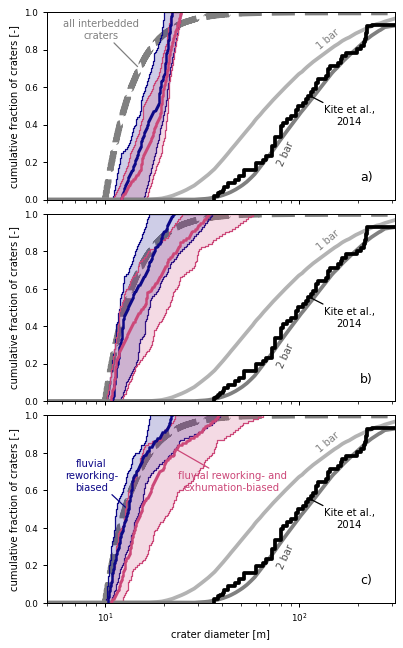

In [38]:
# single run from each timescale, what do cdfs look like?

np.random.seed(155) # doesn't matter, just for reproducibility of figures exactly as published

fig, ax = plt.subplots(3, 1,
    figsize=(4.5, 7.25), dpi=90, sharex=True,
    gridspec_kw=dict(
        hspace=0.075, wspace=0.3,
    left=0.12, right=0.98, top=0.98, bottom=0.075))

# elements on each plot
for axi in ax.ravel():
    
    axi.plot(
        crater_flux_sort, crater_flux_p, label='input distribution', color='0.5', ls='--', lw=5, zorder=0)
    axi.plot(
        filtered_ecdf_mod['diameter [m]'], filtered_ecdf_mod['ecdf 1 bar [-]'],
        label='1 bar', color='0.5', lw=3) # 'mediumaquamarine'
    axi.plot(
        filtered_ecdf_mod['diameter [m]'], filtered_ecdf_mod['ecdf 2 bar [-]'],
        label='2 bar', color='0.7', zorder=0, lw=3)
    axi.step(
        kite_ecdf_mod['diameter [m]'], kite_ecdf_mod['measured ecdf [-]'],
        'k-', label='Kite et al., 2014', lw=3)

cdfs_cmap = plt.colormaps['plasma'].resampled(5)

# loop for each timescale plot
for r, run_number in enumerate([1, 9, 19]):
    
    run_subset_cdf = csfd_interbedded[csfd_interbedded['log_ID'] == run_number]
    
    # make a line for no exhumation correction, just fluvial preservation bias
    n_mc = 50
    mc_cdfs = np.zeros(shape=(101, n_mc))
    for i in range(n_mc):
        mc_sample = np.random.choice(run_subset_cdf.index, size=np.minimum(11, len(run_subset_cdf)), replace=False) # no probs, all equal
        sfd_mc_sample = run_subset_cdf.loc[mc_sample]
        sfd_mc_sample = sfd_mc_sample[sfd_mc_sample['rim_degree_consec'] >= 180]
        fi_sort, fi_p = ecdf(sfd_mc_sample.diameter)
        percs = np.linspace(0, 1, num=101)
        # print(mc_sample, fi_p, fi_sort)
        mc_cdfs[:, i] = np.interp(percs, fi_p, fi_sort)
    ax[r].fill_betweenx(
        y=percs,
        x1=np.quantile(mc_cdfs, 0.16, axis=1),
        x2=np.quantile(mc_cdfs, 0.84, axis=1),
        step='pre',
        color=cdfs_cmap(0),
        alpha=1, facecolor='none')  # edgecolor='none'
    ax[r].fill_betweenx(
        y=percs,
        x1=np.quantile(mc_cdfs, 0.16, axis=1),
        x2=np.quantile(mc_cdfs, 0.84, axis=1),
        step='pre',
        color=cdfs_cmap(0),
        alpha=0.2, edgecolor='none')
    ax[r].step(
        np.median(mc_cdfs, axis=1), percs,
        label=f'median',
        color=cdfs_cmap(0), lw=2)

    # make a CDF range with fluvial bias plus an exhumational correction proportional to diameter
    size_min = run_subset_cdf.diameter.min()
    size_max = run_subset_cdf.diameter.max()
    # if linear proportional probablity
    size_ratio = run_subset_cdf.diameter / size_min
    probs = size_ratio / np.sum(size_ratio)
    #   draw random samples at same n as Kite sample
    mc_cdfs = np.zeros(shape=(101, n_mc))
    for i in range(n_mc):
        mc_sample = np.random.choice(run_subset_cdf.index, size=np.minimum(11, len(run_subset_cdf)), p=probs, replace=False)
        sfd_mc_sample = run_subset_cdf.loc[mc_sample]
        sfd_mc_sample = sfd_mc_sample[sfd_mc_sample['rim_degree_consec'] >= 180]
        fi_sort, fi_p = ecdf(sfd_mc_sample.diameter)
        percs = np.linspace(0, 1, num=101)
        mc_cdfs[:, i] = np.interp(percs, fi_p, fi_sort)
    ax[r].fill_betweenx(
        y=percs,
        x1=np.quantile(mc_cdfs, 0.16, axis=1),
        x2=np.quantile(mc_cdfs, 0.84, axis=1),
        step='pre',
        color=dm.plot._scale_lightness(cdfs_cmap(2)[:3], 1),
        alpha=1, facecolor='none',)
    ax[r].fill_betweenx(
        y=percs,
        x1=np.quantile(mc_cdfs, 0.16, axis=1),
        x2=np.quantile(mc_cdfs, 0.84, axis=1),
        step='pre',
        color=cdfs_cmap(2),
        alpha=0.2, edgecolor='none')
    ax[r].step(
        np.median(mc_cdfs, axis=1), percs,
        label=f'median',
        color=cdfs_cmap(2), lw=2)

ax[0].annotate(
        'all interbedded\ncraters', 
        xy=(15, 0.7),
        xytext=(9.5, 0.86), fontsize=_label_fontsize, color='0.5', ha='center',
        arrowprops=dict(arrowpropsdict, edgecolor='0.5', linewidth=1), zorder=0)
ax[2].annotate(
    'fluvial\nreworking-\nbiased', 
    xy=(13, 0.5),
    xytext=(8.5, 0.60), fontsize=_label_fontsize, color=cdfs_cmap(0), ha='center',
    arrowprops=dict(arrowpropsdict, edgecolor=cdfs_cmap(0), linewidth=1), zorder=5)
ax[2].annotate(
    'fluvial reworking- and\nexhumation-biased', 
    xy=(23, 0.82),
    xytext=(45, 0.6), fontsize=_label_fontsize, color=cdfs_cmap(2), ha='center',
    arrowprops=dict(arrowpropsdict, edgecolor=cdfs_cmap(2), linewidth=1), zorder=0)
for axi in ax.ravel():
    axi.annotate(
        'Kite et al.,\n2014', 
        xy=(110, 0.56), rotation=0,
        xytext=(180, 0.4), fontsize=_label_fontsize, color='k', ha='center',
        arrowprops=dict(arrowpropsdict, edgecolor='k', linewidth=1), zorder=2)
    axi.text(
        85, 0.18, '2 bar', rotation=65,
        fontsize=_label_fontsize, color='0.3', 
        ha='center')
    axi.text(
        140, 0.805, '1 bar', rotation=40,
        fontsize=_label_fontsize, color='0.5',
        ha='center')


    axi.tick_params(labelsize=_tick_fontsize)
    axi.set_ylabel('cumulative fraction of craters [-]', fontsize=_label_fontsize)
    axi.set_ylim(0, 1)
    # ax.set_xlim(-10, 310)
    axi.set_xscale('log')
    axi.set_xlim(5, 310)

ax[2].set_xlabel('crater diameter [m]', fontsize=_label_fontsize)

for i, axi in enumerate(ax.ravel()):
    axi.tick_params(labelsize=_tick_fontsize)
    _panel_labeler(i, axi, x=0.9, y=0.1, color='k')

fig.set_facecolor('none')

fig.savefig(os.path.join(figure_root, 'supp_csfd_preserved_cdfs_timescales.png'), dpi=300, transparent=False, facecolor='none')
fig.savefig(os.path.join(figure_root, 'supp_csfd_preserved_cdfs_timescales.pdf'), dpi=300, transparent=False, facecolor='white')

plt.show()

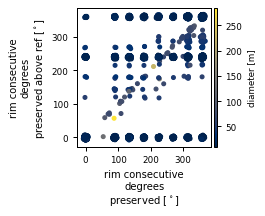

In [39]:
# check correlation between strat restricting metrics
fig, ax = plt.subplots(
    figsize=(2, 2),
    dpi=90)

xy_noise = np.random.normal(0, 2, size=len(csfd_interbedded))

sc = ax.scatter(
    csfd_interbedded['rim_degree_consec']-xy_noise,
    csfd_interbedded['rim_degree_consec_aboveref']+np.flipud(xy_noise),
    c=csfd_interbedded['diameter'],
    marker='.', cmap='cividis')
cb = dm.plot.append_colorbar(sc, ax=ax)
cb.ax.tick_params(labelsize=_tick_fontsize)
cb.set_label('diameter [m]', fontsize=_tick_fontsize)

# ax.axhline(y=-8, c='k', ls='--')

ax.set_xlabel('rim consecutive\ndegrees\npreserved [$^\\circ$]', fontsize=_label_fontsize)
ax.set_ylabel('rim consecutive\ndegrees\npreserved above ref [$^\\circ$]', fontsize=_label_fontsize)
ax.tick_params(labelsize=_tick_fontsize)
ax.xaxis.offsetText.set_fontsize(_tick_fontsize-1)


plt.show()


# process the uniform simulations

In [43]:
# parallel func
import time

def process_a_cube_to_df_stats(fldr, i):
    cube = dm.cube.DataCube(os.path.join(fldr, 'pyDeltaRCM_output.nc'), varset=varset)
    strat = dm.cube.StratigraphyCube.from_DataCube(cube, z=np.arange(-10, 15, step=0.1))
    strat.register_section('bound', dm.section.CircularSection(
        radius=1400, origin_idx=(0, cube.shape[2]//2))
        )

    lines = read_log(fldr)
    df_log = process_log(lines, log_ID=str(i))

    df_stats_i = compute_preservation_from_df_cubes(df_log, cube=cube, strat=strat)
    return df_stats_i

PROCESS_FLAG = False
PARALLEL_FLAG = True
if PROCESS_FLAG:
    if PARALLEL_FLAG:
        # process in parallel
        folders_to_process = uniform_matrix_fldrs
        list_df_stats = joblib.Parallel(
            n_jobs=3, backend='loky', prefer='processes',
            verbose=100)(
                joblib.delayed(process_a_cube_to_df_stats)(fldr, i) for fldr, i in zip(uniform_matrix_fldrs, range(len(folders_to_process))))
    else:
        list_df_stats = []
        for i, fldr in enumerate(uniform_matrix_fldrs):
            i_df_stats = process_a_cube_to_df_stats(fldr, i)
            list_df_stats.append(i_df_stats)
        
    uniform_df = pd.concat(list_df_stats, ignore_index=True)
    uniform_df.to_csv('./crater_data/uniform_preserved_metrics.csv', index=False)
else:
    # load the full df
    uniform_df = pd.read_csv('./crater_data/uniform_preserved_metrics.csv')

uniform_df

,timestep,time,crateridx,diameter,ref_elev,location_x,location_y,p_SLR,p_f_bedload,p_crater_accumulation_duration,...,log_ID,distance_inlet,interbedded,rim_frac,ejecta_frac,rim_frac_sfc,rim_degree_cov,rim_degree_consec,rim_degree_consec_aboveref,rim_degree_consec_top
0,17,181333.3,1,209.1,-6.0,4870.0,2990.0,1.000000e-08,0.8,1.0,...,0,3114.514408,False,0.953704,0.929012,0.000000,1.000000,360.0,360.0,NaN
1,24,256000.0,2,125.5,-6.0,7390.0,870.0,1.000000e-08,0.8,1.0,...,0,1616.230182,False,0.675000,0.791985,0.175000,0.722222,160.0,160.0,NaN
2,60,640000.0,3,108.6,-6.0,710.0,1270.0,1.000000e-08,0.8,1.0,...,0,5402.684518,False,1.000000,0.913750,0.041667,1.000000,360.0,360.0,NaN
3,137,1461333.3,4,66.9,-6.0,270.0,2610.0,1.000000e-08,0.8,1.0,...,0,6245.398306,False,1.000000,1.000000,1.000000,1.000000,360.0,360.0,NaN
4,175,1866666.7,5,103.0,-6.0,9490.0,1450.0,1.000000e-08,0.8,1.0,...,0,3767.890657,False,1.000000,0.990057,0.000000,1.000000,360.0,360.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8995,5858,62485333.3,246,11.7,-5.6,110.0,910.0,1.000000e-08,0.2,1.0,...,35,5928.389326,False,1.000000,NaN,0.000000,NaN,360.0,360.0,NaN
8996,5863,62538666.7,247,112.5,14.5,10630.0,4290.0,1.000000e-08,0.2,1.0,...,35,6272.686825,False,0.541667,0.757143,1.000000,0.625000,135.0,135.0,NaN
8997,5891,62837333.3,248,98.9,-2.2,3130.0,2110.0,1.000000e-08,0.2,1.0,...,35,3499.057016,False,1.000000,0.998447,1.000000,1.000000,360.0,360.0,NaN
8998,5916,63104000.0,249,250.9,-5.5,4030.0,3870.0,1.000000e-08,0.2,1.0,...,35,4262.229464,False,1.000000,0.942674,1.000000,1.000000,360.0,360.0,NaN


# examine the uniform simulation results

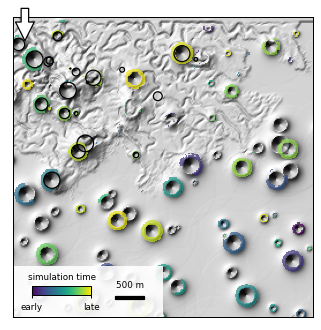

In [44]:
# one model result for the supplement

surface_cratered_final = determine_variable_at_surface(uniform_cube, 'crater_rim', -1, stasis_tol=1)
surface_cratered_final = surface_cratered_final.astype(float)
surface_cratered_final[surface_cratered_final == 0] = np.nan

ls = LightSource(azdeg=315, altdeg=45)
hs = ls.hillshade(np.array(uniform_cube['eta'][-1, :, :]).squeeze(), vert_exag=8, dx=20, dy=20)

_cidx_cmap, _cidx_norm = _make_crateridx_cmap(len(df_stats_single_uniform))

# configure
fig, ax = plt.subplots(
    figsize=(3.5, 3.75), dpi=90, gridspec_kw=dict(left=0.02, right=0.97, bottom=0.02, top=0.97)
)

ax.imshow(hs, cmap='gray', extent=uniform_cube.extent)
im = ax.imshow(
    surface_cratered_final, cmap=_cidx_cmap, norm=_cidx_norm, interpolation='none', alpha=0.7,
    extent=uniform_strat.extent)
sm = matplotlib.cm.ScalarMappable(cmap='viridis', norm=matplotlib.colors.Normalize(vmin=0, vmax=1))
ovax = inset_axes(ax, width="20%", height="3%", bbox_to_anchor=(.04, .05, 1, 1), bbox_transform=ax.transAxes, loc=3)
fmt = lambda x, pos: '{:g}'.format(x)
cb = fig.colorbar(
    sm, cax=ovax, orientation='horizontal', format=FuncFormatter(fmt))
ovax.set_xticks((0,1))
ovax.set_xticklabels(('early', 'late'))
ovax.set_title('simulation time', fontsize=_tick_fontsize, pad=6)
ovax.xaxis.set_tick_params(labelsize=_tick_fontsize, length=2)
scalebar = AnchoredSizeBar(
    ax.transData,
    500, '500 m', 'lower left', 
    bbox_to_anchor=(0.34, 0.06),
    bbox_transform=ax.transAxes,
    pad=0,
    sep=5,
    borderpad=0,
    color='k',
    frameon=False,
    size_vertical=50, label_top=True,
    fontproperties=dict(size=_tick_fontsize)
)
ax.add_artist(scalebar)
rect = patches.Rectangle(
    (0, 0), 0.5, 0.17,
    facecolor='white', alpha=0.9, transform=ax.transAxes)
ax.add_patch(rect)

patch_list = []
_circle_colors = np.zeros((len(df_stats_single_uniform), 3))
for index, row in df_stats_single_uniform.iterrows():
    index -= df_stats_single_uniform.index[0]  # adjust to zero-based  index
    _circle_colors[index, :] = (0. if row.interbedded else 1.)
    circ = patches.Circle(
        (row['location_x'], row['location_y']), radius=row['diameter']/2,
        edgecolor='k')
    if row.interbedded:
        patch_list.append(circ)
p = collections.PatchCollection(
    patch_list, facecolor='none', linewidth=1, linestyle='-', zorder=0)
ax.add_collection(p)

arrow = matplotlib.patches.FancyArrowPatch(
    (6000, -200), (6000, 450),
    mutation_scale=30, facecolor='w', edgecolor='k', clip_on=False, zorder=5)
ax.add_patch(arrow)

ax.set_xlim(5800, 11000)
ax.set_ylim(5200, 0)
ax.set_xticks([])
ax.set_yticks([])

# plt.tight_layout()
fig.set_facecolor('none')

plt.savefig(os.path.join(figure_root, 'hillshade_uniform_surface.png'), dpi=300)
plt.savefig(os.path.join(figure_root, 'hillshade_uniform_surface.pdf'), dpi=600)
plt.show()

In [45]:
# filter out the sfd runs
uniform_stats = uniform_df[(uniform_df['p_crater_size'] == -1)] #  & (df_stats['p_SLR'] == 1e-10) & (df_stats['p_crater_accumulation_duration'] == 100)]
# sfd_stats = df_stats[df_stats['log_ID'] == 33]

uniform_interbedded = uniform_df[uniform_df['interbedded']]
uniform_interbedded

,timestep,time,crateridx,diameter,ref_elev,location_x,location_y,p_SLR,p_f_bedload,p_crater_accumulation_duration,...,log_ID,distance_inlet,interbedded,rim_frac,ejecta_frac,rim_frac_sfc,rim_degree_cov,rim_degree_consec,rim_degree_consec_aboveref,rim_degree_consec_top
16,551,5877333.3,17,67.9,-1.7,6230.0,930.0,1.000000e-08,0.8,1.0,...,0,886.002257,True,0.000000,0.000000,0.062500,0.000000,0.000000,0.000000,NaN
17,590,6293333.3,18,286.7,-2.6,5650.0,1070.0,1.000000e-08,0.8,1.0,...,0,1043.551628,True,0.574468,0.446559,0.031915,0.818182,155.454545,147.272727,NaN
32,972,10368000.0,33,268.0,-0.9,4910.0,930.0,1.000000e-08,0.8,1.0,...,0,1366.528448,True,0.941860,0.720760,0.087209,1.000000,360.000000,360.000000,NaN
41,1201,12810666.7,42,221.3,0.6,4790.0,1210.0,1.000000e-08,0.8,1.0,...,0,1641.036258,True,0.956897,0.735780,0.094828,1.000000,360.000000,360.000000,NaN
42,1218,12992000.0,43,42.8,-0.6,4710.0,430.0,1.000000e-08,0.8,1.0,...,0,1317.345816,True,1.000000,0.867188,0.500000,NaN,360.000000,288.000000,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8946,4697,50101333.3,197,123.5,3.7,5310.0,1670.0,1.000000e-08,0.2,1.0,...,35,1725.398505,True,1.000000,0.598633,0.425000,1.000000,360.000000,360.000000,NaN
8952,4830,51520000.0,203,134.2,4.4,6150.0,1490.0,1.000000e-08,0.2,1.0,...,35,1420.211252,True,0.875000,0.797855,1.000000,0.950000,342.000000,342.000000,NaN
8964,5162,55061333.3,215,79.2,4.2,4390.0,1130.0,1.000000e-08,0.2,1.0,...,35,1905.413341,True,1.000000,0.841346,1.000000,0.900000,324.000000,324.000000,NaN
8967,5239,55882666.7,218,74.7,1.4,5370.0,530.0,1.000000e-08,0.2,1.0,...,35,758.023746,True,1.000000,0.697368,0.750000,0.900000,324.000000,324.000000,NaN


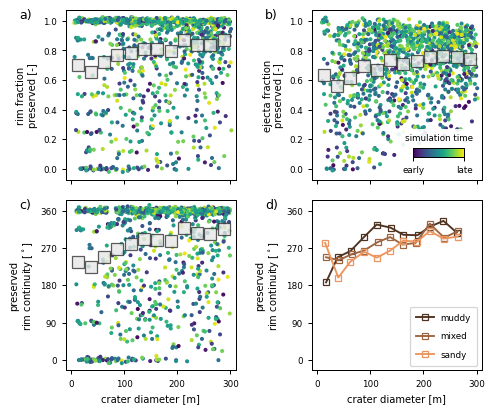

In [46]:
uniform_interbedded_shuffle = uniform_interbedded.sample(frac=1, random_state=1).reset_index()

fig, ax = plt.subplots(
    2, 2, figsize=(5.5, 4.5), dpi=90, sharex=True,
    gridspec_kw=dict(
        hspace=0.12, wspace=0.3,
        left=0.1, right=0.98, top=0.98, bottom=0.09))

y_noise = np.random.normal(0, 1 * 0.01, size=len(uniform_interbedded))
x_noise = np.random.normal(0, 300 * 0.01, size=len(uniform_interbedded))

groups = uniform_interbedded.groupby(pd.cut(uniform_interbedded.diameter, np.arange(0, 325, step=25)))
midpt = [(a.left + a.right)/2 for a in groups.mean().index]
mean_pts_kw = dict(mec='0.2', ls='none', mfc='0.9', marker='s', alpha=0.8, ms=10)

ax[0,0].scatter(
    uniform_interbedded_shuffle['diameter']+x_noise,
    uniform_interbedded_shuffle['rim_frac']+y_noise,
    c=uniform_interbedded_shuffle['crateridx'], marker='.', s=20, alpha=1)
ax[0,0].set_ylabel('rim fraction\npreserved [-]', fontsize=_label_fontsize)
# ax[0,0].set_xlabel('crater diameter [m]', fontsize=_label_fontsize)
ax[0,0].set_xlim(-10, 310)
ax[0,0].set_ylim(-0.075, 1.075)
ax[0,0].plot(
    midpt, groups.mean()['rim_frac'], **mean_pts_kw)

ax[0,1].scatter(
    uniform_interbedded_shuffle['diameter']+x_noise,
    uniform_interbedded_shuffle['ejecta_frac']+y_noise,
    c=uniform_interbedded_shuffle['crateridx'], s=20, marker='.')
ax[0,1].set_ylabel('ejecta fraction\npreserved [-]', fontsize=_label_fontsize)
# ax[0,1].set_xlabel('crater diameter [m]', fontsize=_label_fontsize)
ax[0,1].set_xlim(-10, 310)
ax[0,1].set_ylim(-0.075, 1.075)
ax[0,1].plot(
    midpt, groups.mean()['ejecta_frac'], **mean_pts_kw)

sm = matplotlib.cm.ScalarMappable(cmap='viridis', norm=matplotlib.colors.Normalize(vmin=0, vmax=1))
ovax = inset_axes(ax[0,1], width="30%", height="5%", bbox_to_anchor=(.56, .1, 1, 1), bbox_transform=ax[0,1].transAxes, loc=3)
fmt = lambda x, pos: '{:g}'.format(x)
cb = fig.colorbar(
    sm, cax=ovax, orientation='horizontal', format=FuncFormatter(fmt))
ovax.set_xticks((0,1))
ovax.set_xticklabels(('early', 'late'))
ovax.set_title('simulation time', fontsize=_tick_fontsize)
ovax.xaxis.set_tick_params(labelsize=_tick_fontsize)
rect = patches.Rectangle(
    (0.5, 0), 0.7, 0.3,
    facecolor='white', alpha=0.9, transform=ax[0,1].transAxes)
ax[0,1].add_patch(rect)

sc = ax[1,0].scatter(
    uniform_interbedded_shuffle['diameter'],
    uniform_interbedded_shuffle['rim_degree_consec']+y_noise*360,
    c=uniform_interbedded_shuffle['crateridx'], s=20, marker='.')
ax[1,0].set_ylabel('preserved\nrim continuity [$^\\circ$]', fontsize=_label_fontsize)
ax[1,0].set_xlabel('crater diameter [m]', fontsize=_label_fontsize)
ax[1,0].set_xlim(-10, 310)
ax[1,0].set_yticks(np.linspace(0, 360, endpoint=True, num=5))
ax[1,0].set_ylim(-25, 385)
ax[1,0].plot(
    midpt, groups.mean()['rim_degree_consec'],  **mean_pts_kw)


groups = uniform_interbedded.groupby([uniform_interbedded['p_f_bedload'], pd.cut(uniform_interbedded['diameter'], np.arange(0, 300, step=25))])
midpt = [(a.left + a.right)/2 for a in groups.mean(numeric_only=True).unstack(level=0).index]
sandfrac_labels = ['muddy', 'mixed', 'sandy']
cmap = matplotlib.colors.LinearSegmentedColormap.from_list(
    'trunc({n},{a:.2f},{b:.2f})'.format(n='sandymuddy', a=0.2, b=0.8),
    plt.colormaps['copper'].resampled(5)(np.linspace(0.2, 0.8, 100))).resampled(4)

grp_mean = groups.mean(numeric_only=True).unstack()
grp_std = groups.std(numeric_only=True).unstack()
for i, flux_group in enumerate(grp_mean['rim_degree_consec'].index):
    
    idata = grp_mean.iloc[i] #[grp_mean.index == flux_group]
    idata_mask = np.isfinite(idata['rim_degree_consec'].values)
    
    idata_diameter = idata['diameter'][idata_mask].values
    idata_value = idata['rim_degree_consec'][idata_mask].values
    idata_std = grp_std.iloc[i]['rim_degree_consec'][idata_mask].values

    ax[1,1].plot(
        idata_diameter,
        idata_value,
        marker='s', mec=cmap(i), linestyle='-', mfc='none', ms=5, color=cmap(i),
        label=sandfrac_labels[i])

ax[1,1].legend(fontsize=_tick_fontsize, loc='lower right', labelspacing=1.1, borderpad=0.75)
ax[1,1].tick_params(labelsize=_tick_fontsize)
ax[1,1].set_ylabel('preserved\nrim continuity [$^\\circ$]', fontsize=_label_fontsize)
ax[1,1].set_xlabel('crater diameter [m]', fontsize=_label_fontsize)
ax[1,1].set_yticks(np.linspace(0, 360, endpoint=True, num=5))
ax[1,1].set_ylim(ax[1,0].get_ylim())
ax[1,1].set_xlim(-10, 310)

for i, axi in enumerate(ax.ravel()):
    axi.tick_params(labelsize=_tick_fontsize)
    axi.set_aspect(1.0/axi.get_data_ratio())
    _panel_labeler(i, axi, x=-0.275, y=0.95, color='k', zorder=1)  # bbox=dict(facecolor='white', edgecolor='none', alpha=0.8)

fig.set_facecolor('none')

fig.savefig(os.path.join(figure_root, 'uniform_preserved_metrics.png'), dpi=300, transparent=False, facecolor='none')
fig.savefig(os.path.join(figure_root, 'uniform_preserved_metrics.pdf'), dpi=300, transparent=False, facecolor='white')

plt.show()

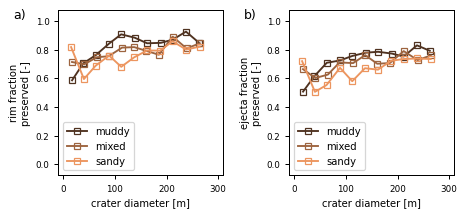

In [47]:
# divided by sand fraction for other two metrics
uniform_interbedded_shuffle = uniform_interbedded.sample(frac=1, random_state=1).reset_index()

fig, ax = plt.subplots(
    1, 2, figsize=(5, 2.5), dpi=90,
    gridspec_kw=dict(
        hspace=0.2, wspace=0.4,
    left=0.11, right=0.99, top=0.98, bottom=0.075))

y_noise = np.random.normal(0, 1 * 0.01, size=len(uniform_interbedded))
x_noise = np.random.normal(0, 300 * 0.01, size=len(uniform_interbedded))

groups = uniform_interbedded.groupby([uniform_interbedded['p_f_bedload'], pd.cut(uniform_interbedded['diameter'], np.arange(0, 300, step=25))])
midpt = [(a.left + a.right)/2 for a in groups.mean(numeric_only=True).unstack(level=0).index]
sandfrac_labels = ['muddy', 'mixed', 'sandy']

grp_mean = groups.mean(numeric_only=True).unstack()
grp_std = groups.std(numeric_only=True).unstack()
for i, flux_group in enumerate(grp_mean['rim_frac'].index):
    
    idata = grp_mean.iloc[i] #[grp_mean.index == flux_group]
    idata_mask = np.isfinite(idata['rim_frac'].values)
    
    idata_diameter = idata['diameter'][idata_mask].values
    idata_value = idata['rim_frac'][idata_mask].values
    idata_std = grp_std.iloc[i]['rim_frac'][idata_mask].values

    ax[0].plot(
        idata_diameter,
        idata_value,
        marker='s', mec=cmap(i), linestyle='-', mfc='none', ms=5, color=cmap(i),
        label=sandfrac_labels[i])

ax[0].legend(fontsize=_label_fontsize)
ax[0].tick_params(labelsize=_tick_fontsize)
ax[0].set_ylabel('rim fraction\npreserved [-]', fontsize=_label_fontsize)
ax[0].set_xlabel('crater diameter [m]', fontsize=_label_fontsize)
ax[0].set_ylim(-0.075, 1.075)
ax[0].set_xlim(-10, 310)

for i, flux_group in enumerate(grp_mean['ejecta_frac'].index):
    
    idata = grp_mean.iloc[i] #[grp_mean.index == flux_group]
    idata_mask = np.isfinite(idata['ejecta_frac'].values)
    
    idata_diameter = idata['diameter'][idata_mask].values
    idata_value = idata['ejecta_frac'][idata_mask].values
    idata_std = grp_std.iloc[i]['ejecta_frac'][idata_mask].values

    ax[1].plot(
        idata_diameter,
        idata_value,
        marker='s', mec=cmap(i), linestyle='-', mfc='none', ms=5, color=cmap(i),
        label=sandfrac_labels[i])

ax[1].legend(fontsize=_label_fontsize)
ax[1].tick_params(labelsize=_tick_fontsize)
ax[1].set_ylabel('ejecta fraction\npreserved [-]', fontsize=_label_fontsize)
ax[1].set_xlabel('crater diameter [m]', fontsize=_label_fontsize)
ax[1].set_ylim(ax[0].get_ylim())
ax[1].set_xlim(-10, 310)


for i, axi in enumerate(ax.ravel()):
    axi.tick_params(labelsize=_tick_fontsize)
    axi.set_aspect(1.0/axi.get_data_ratio())
    _panel_labeler(i, axi, x=-0.275, y=0.95, color='k', zorder=1)

fig.set_facecolor('none')

fig.savefig(os.path.join(figure_root, 'uniform_preserved_supplement_metrics.png'), dpi=300, transparent=False, facecolor='none')
fig.savefig(os.path.join(figure_root, 'uniform_preserved_supplement_metrics.pdf'), dpi=300, transparent=False, facecolor='white')

plt.show()


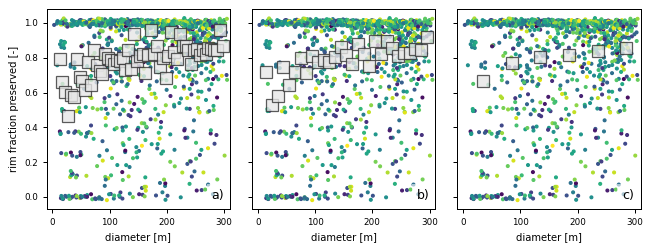

In [48]:
# make figure exploring the effect of bin size
fig, ax = plt.subplots(
    1, 3, figsize=(7.5, 2.5), dpi=90, sharex=True, sharey=True,
    gridspec_kw=dict(
        hspace=0.12, wspace=0.12,
        left=0.1, right=0.98, top=0.98, bottom=0.09))

y_noise = np.random.normal(0, 1 * 0.01, size=len(uniform_interbedded_shuffle))
x_noise = np.random.normal(0, 300 * 0.01, size=len(uniform_interbedded_shuffle))

for i, bin_size in enumerate([5, 10, 50]):
    groups = uniform_interbedded_shuffle.groupby(pd.cut(uniform_interbedded_shuffle.diameter, np.arange(10, 300+bin_size, step=bin_size)))
    midpt = [(a.left + a.right)/2 for a in groups.mean().index]
    mean_pts_kw = dict(mec='0.2', ls='none', mfc='0.9', marker='s', alpha=0.8, ms=10)

    ax[i].scatter(
        uniform_interbedded_shuffle['diameter']+x_noise,
        uniform_interbedded_shuffle['rim_frac']+y_noise,
        c=uniform_interbedded_shuffle['crateridx'], marker='.', s=20, alpha=1)
    # ax[0,0].set_xlabel('crater diameter [m]', fontsize=_label_fontsize)
    ax[i].set_xlim(-10, 310)
    ax[i].plot(
        midpt, groups.mean()['rim_frac'], **mean_pts_kw)
    ax[i].set_xlabel('diameter [m]', fontsize=_label_fontsize)
    if i ==0:
        ax[i].set_ylabel('rim fraction preserved [-]', fontsize=_label_fontsize)

for i, axi in enumerate(ax.ravel()):
    axi.tick_params(labelsize=_tick_fontsize)
    _panel_labeler(i, axi, x=0.9, y=0.05, color='k', bbox=dict(facecolor='white', edgecolor='none', alpha=0.6))

In [49]:
## Perform regression with the grouped data
mappable_groups = uniform_interbedded.groupby([uniform_interbedded['p_f_bedload'], pd.cut(uniform_interbedded.diameter, np.arange(0, 325, step=25))])
mappable_groups_filter = mappable_groups['rim_degree_consec'].apply(lambda x: (sum(x >= 180) / len(x)) if len(x) > 0 else np.nan)
mappable_groups_filter = mappable_groups_filter.dropna() # drop any rows that are NaN

muddy_group_fraction = mappable_groups_filter.loc[0.2]  # 0.2 is the mud fraction, gets converted to a float by pandas...
sandy_group_fraction = mappable_groups_filter.loc[0.8]

# diameter vector
x = np.linspace(1, 600, num=600)

# midpoint vector
muddy_midpt = np.array([(a.left + a.right)/2 for a in muddy_group_fraction.index])
sandy_midpt = np.array([(a.left + a.right)/2 for a in sandy_group_fraction.index])

# random number generate for reproducible bayesian model
rng = np.random.default_rng(999)

# exponential functions with added complications
def exp_function(d, d0, n):
    return 1 - (np.exp((d0 - d) / n))

def exp_function_nugget(d, c0, n):
    """Equation 1 in the paper, with d_0=0"""
    # I = d >= 0  # indicator variable
    return (1-c0) * (1 - (np.exp( ((-d) / (n))))) + (c0)

def exp_function_nugget_d0(d, d0, c0, n):
    """Equation 1 in the paper, with all variables"""
    # I = d >= 0  # indicator variable
    return (1-c0) * (1 - (np.exp( ((d0 - d) / (n))))) + (c0)

# perform freq regression with d_0=0 to get initial guesses
sandy_bestfit, sandy_besfit_cov = sp.optimize.curve_fit(
    exp_function_nugget,
    sandy_midpt,
    sandy_group_fraction,
    p0=[0.8, 80],
)
muddy_bestfit, muddy_besfit_cov = sp.optimize.curve_fit(
    exp_function_nugget,
    muddy_midpt,
    muddy_group_fraction,
    p0=[0.8, 80],
)

In [50]:
# prepare and write out the summaries of each fit

# sqrt(diag(variances)) / sqrt(number of observations)  # errors
# sqrt(diag(variances))  # stddevs
muddy_bestfit_errors = np.sqrt(np.diag(muddy_besfit_cov))
sandy_bestfit_errors = np.sqrt(np.diag(sandy_besfit_cov))

print(f"Muddy: c0 = {muddy_bestfit[0]:.2f} +/- {muddy_bestfit_errors[0]:.2f}; n = {muddy_bestfit[1]:.0f} +/- {muddy_bestfit_errors[1]:.0f}")
print(f"Sandy: c0 = {sandy_bestfit[0]:.2f} +/- {sandy_bestfit_errors[0]:.2f}; n = {sandy_bestfit[1]:.0f} +/- {sandy_bestfit_errors[1]:.0f}")

Muddy: c0 = 0.46 +/- 0.09; n = 78 +/- 18
Sandy: c0 = 0.63 +/- 0.04; n = 288 +/- 76


In [51]:
from uncertainties import ufloat
muddy_c0 = ufloat(muddy_bestfit[0], muddy_bestfit_errors[0])
muddy_n = ufloat(muddy_bestfit[1], muddy_bestfit_errors[1])

sandy_c0 = ufloat(sandy_bestfit[0], sandy_bestfit_errors[0])
sandy_n = ufloat(sandy_bestfit[1], sandy_bestfit_errors[1])

muddy_c0, muddy_n, sandy_c0, sandy_n

(0.45794729264427697+/-0.08771707690115511,
 77.5027019888762+/-17.721585556070746,
 0.6289899414943786+/-0.043283904996756814,
 288.33782370258405+/-75.69616668999878)

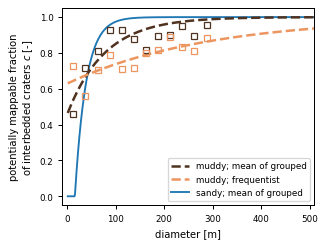

In [53]:
warren_evaluated = exp_function_nugget_d0(x, 15.7, 0, 23)

## FIGURE
fig, ax = plt.subplots(figsize=(4,3), gridspec_kw=dict(bottom=0.15, left=0.2), dpi=90)

w, = ax.plot(
    x, np.clip(warren_evaluated, 0, 1), '-', label='Warren et al., 2019; Meridiani'
)

muddy_best_evaluated = exp_function_nugget_d0(x, 0, *muddy_bestfit)  # unpack bestfit into last two args
sandy_best_evaluated = exp_function_nugget_d0(x, 0, *sandy_bestfit)

mgf, = ax.plot(
    x, muddy_best_evaluated, '--', label='muddy best fit', color=cmap(0), lw=2
)
sgf, = ax.plot(
    x, sandy_best_evaluated, '--', label='sandy best fit', color=cmap(2), lw=2
)

# data
ax.plot(
    muddy_midpt, muddy_group_fraction, 's', color=cmap(0), mec=cmap(0), linestyle='none', mfc='none', ms=5,
)
ax.plot(
    sandy_midpt, sandy_group_fraction, 's', color=cmap(2), mec=cmap(2), linestyle='none', mfc='none', ms=5,
)

ax.legend([mgf, sgf, w], ["muddy; mean of grouped", "muddy; frequentist", "sandy; mean of grouped", "sandy; frequentist", "Warren et al., 2019; Meridiani"], fontsize=_tick_fontsize)

ax.set_ylim(-0.05, 1.05)

ax.set_xlim(-10, 510)
ax.set_xlabel('diameter [m]', fontsize=_label_fontsize)
ax.set_ylabel('potentially mappable fraction\nof interbedded craters $c$ [-]', fontsize=_label_fontsize)

ax.tick_params(labelsize=_tick_fontsize)

fig.set_facecolor('none')

fig.savefig(os.path.join(figure_root, 'filter_compare.png'), dpi=300, transparent=False, facecolor='none')

plt.show()

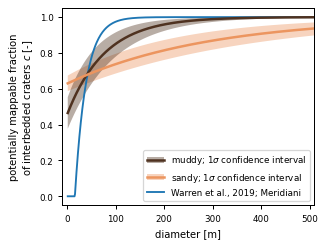

In [54]:
warren_evaluated = exp_function(x, 15.7, 23)
warren_evaluated_mawrth = exp_function(x, 21.2, 23)

## FIGURE
fig, ax = plt.subplots(figsize=(4,3), gridspec_kw=dict(bottom=0.15, left=0.2), dpi=90)

w, = ax.plot(
    x, np.clip(warren_evaluated, 0, 1), '-', label='Warren et al., 2019; Meridiani'
)

## this is pretty close to the original warren function, but with d0 and c0 both zero
# ax.plot(
#     x, exp_function_nugget_d0(x, 0, 0, 30))

# best fit
sa = ax.fill_between(
    x,
    exp_function_nugget_d0(x, 0, sandy_bestfit[0]-sandy_bestfit_errors[0], sandy_bestfit[1]+sandy_bestfit_errors[1]),
    exp_function_nugget_d0(x, 0, sandy_bestfit[0]+sandy_bestfit_errors[0], sandy_bestfit[1]-sandy_bestfit_errors[1]),
    color=cmap(2), alpha=0.4, edgecolor='none')
ma = ax.fill_between(
    x,
    exp_function_nugget_d0(x, 0, muddy_bestfit[0]-muddy_bestfit_errors[0], muddy_bestfit[1]+muddy_bestfit_errors[1]),
    exp_function_nugget_d0(x, 0, muddy_bestfit[0]+muddy_bestfit_errors[0], muddy_bestfit[1]-muddy_bestfit_errors[1]),
    color=cmap(0), alpha=0.4, edgecolor='none')

mm, = ax.plot(
    x, muddy_best_evaluated, '-', color=cmap(0), lw=2
)
sm, = ax.plot(
    x, sandy_best_evaluated, '-', color=cmap(2), lw=2
)

ax.legend([(mm, ma), (sm, sa), w], ["muddy; 1$\\sigma$ confidence interval", "sandy; 1$\\sigma$ confidence interval", "Warren et al., 2019; Meridiani"], fontsize=_tick_fontsize)

ax.set_ylim(-0.05, 1.05)

ax.set_xlim(-10, 510)
ax.set_xlabel('diameter [m]', fontsize=_label_fontsize)
ax.set_ylabel('potentially mappable fraction\nof interbedded craters $c$ [-]', fontsize=_label_fontsize)

ax.tick_params(labelsize=_tick_fontsize)

fig.set_facecolor('none')

fig.savefig(os.path.join(figure_root, 'filter_function.png'), dpi=300, transparent=False, facecolor='none')
fig.savefig(os.path.join(figure_root, 'filter_function.pdf'), dpi=300, transparent=False, facecolor='white')


plt.show()

# additional supplementary materials figures and analysis

/scratch/crater_csfd_matrix/job_008_set3


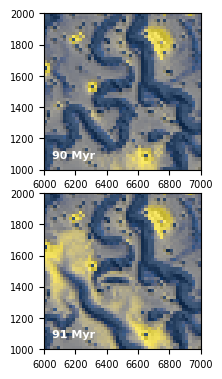

In [55]:
# example of steering and obliteration

steering_cube_folder = csfd_matrix_fldrs[-2]  # 5 for 1 Ma, 14 for 100 Ma
print(steering_cube_folder)
steering_cube = dm.cube.DataCube(os.path.join(steering_cube_folder, 'pyDeltaRCM_output.nc'), varset=varset)
# csfd_strat = dm.cube.StratigraphyCube.from_DataCube(csfd_cube, z=np.arange(-10, 15, step=0.1))

fig = plt.figure()

gs2 = fig.add_gridspec(
    2, 1,
    right=0.98, bottom=0.15, top=0.85, left=0.575, hspace=0.15, wspace=0.05)
gs2_ax = []

time_idxs_zoom = [181, 182]
near_left_ax = 2
zoom_range = ((6000, 7000), (2000, 1000))
for i, time_idx in enumerate(time_idxs_zoom):
    ls = LightSource(azdeg=315, altdeg=45)
    hs = ls.hillshade(
        np.array(steering_cube['eta'][time_idx, :, :]).squeeze(),
        vert_exag=8, dx=20, dy=20)

    axi = fig.add_subplot(gs2[i])
    axi.imshow(hs, cmap='gray', extent=csfd_cube.extent)
    im = axi.imshow(
        steering_cube['eta'][time_idx],
        extent=steering_cube.extent,
        cmap='cividis', vmin=-3, vmax=5, alpha=0.75)
    
    dt_interval = np.round((100 / steering_cube.shape[0]), 1)
    axi.text(
        0.05, 0.075, f'{dt_interval*time_idx:.0f} Myr',
        color='white', fontsize=_label_fontsize, weight='bold',
        transform=axi.transAxes)
    
    zoom_rect = patches.Rectangle(
        (zoom_range[0][0], zoom_range[1][0]),
        (zoom_range[0][1] - zoom_range[0][0]),
        (zoom_range[1][1] - zoom_range[1][0]), edgecolor='k', facecolor='none')
    # ax[near_left_ax].add_patch(zoom_rect)
    
    axi.tick_params(labelsize=_tick_fontsize)
    axi.set_xlim(zoom_range[0][0], zoom_range[0][1])
    axi.set_ylim(zoom_range[1][1], zoom_range[1][0])
    # axi.set_xticks([])
    # axi.set_yticks([])
    gs2_ax.append(axi)


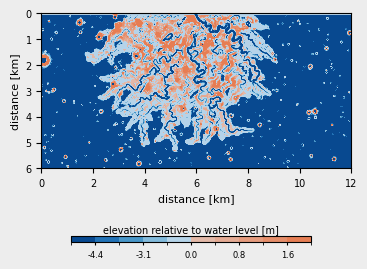

In [56]:
# make a gif of just one of the replicates
from matplotlib import animation

cube = csfd_cube
# cube = uniform_cube


def mars_cartographic_cmap(H_SL=0.0, h=4.5, n=1.0):
    blues = matplotlib.colormaps["Blues_r"].resampled(64)
    # greens = mpl.colormaps["YlGn_r"].resampled(64)
    greens = matplotlib.colors.LinearSegmentedColormap.from_list(
        'land', np.array([(227, 204, 195), (232, 108, 58)])/256, N=64)
    combined = np.vstack(
        (blues(np.linspace(0.1, 0.7, 5)), greens(np.linspace(0.2, 0.8, 5)))
    )
    delta = matplotlib.colors.ListedColormap(combined, name="delta")
    bounds = np.hstack(
        (np.linspace(H_SL - h, H_SL - (h / 2), 5), np.linspace(H_SL, H_SL + n, 6))
    )
    norm = matplotlib.colors.BoundaryNorm(bounds, len(bounds) - 1)
    return delta, norm


def update_field(i):
    H_SL = float(cube.meta['H_SL'][i]) - 0.5
    im.set_data(cube['eta'][i, :, :] - H_SL)


time_idxs = np.arange(0, cube.shape[0]-1)

cmap, norm = mars_cartographic_cmap(H_SL=0.0, h=5, n=2)

fig, ax = plt.subplots(
    figsize=(4, 3), gridspec_kw=dict(bottom=0.2, top=0.95))
im = ax.imshow(
    cube['eta'][-1, :, :],
    extent=cube.extent,
    cmap=cmap, norm=norm
    )
ax.tick_params(labelsize=_tick_fontsize)
ax.set_xlabel('distance [km]', fontsize=_label_fontsize)
ax.set_ylabel('distance [km]', fontsize=_label_fontsize)
dm.plot.style_axes_km(ax)
                
# colorbar for elevation array
ovax = fig.add_axes([0.2, 0.07, 3*0.2, 0.02])
fmt = lambda x, pos: '{:.1f}'.format(x)
plt.colorbar(
    im, cax=ovax, orientation='horizontal', format=FuncFormatter(fmt))
ovax.set_title('elevation relative to water level [m]', fontsize=_tick_fontsize, pad=3)
ovax.xaxis.set_tick_params(labelsize=_tick_fontsize-1, length=2)

fig.set_facecolor('0.93')

anim = animation.FuncAnimation(
    fig, update_field,
    frames=cube.shape[0]-1)
# anim.save('uniform_cratering_example.gif', fps=10, dpi=300)
anim.save('csfd_cratering_example.gif', fps=10, dpi=300)

plt.show()

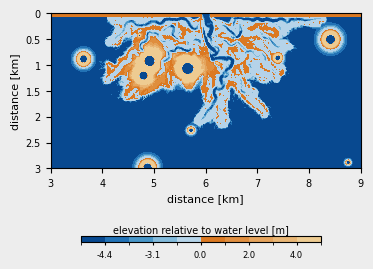

In [57]:
# make a gif of just one of the replicates
from matplotlib import animation

# cube = dm.cube.DataCube('/scratch/movies/job_003/pyDeltaRCM_output.nc')
# cube = dm.cube.DataCube('/scratch/crater_csfd_matrix/job_007/pyDeltaRCM_output.nc')
# cube = dm.cube.DataCube('/scratch/movies2/job_002/pyDeltaRCM_output.nc')
# cube = dm.cube.DataCube('/scratch/crater_uniform_matrix/job_034/pyDeltaRCM_output.nc') # muddy
cube = dm.cube.DataCube('/scratch/crater_uniform_matrix/job_000/pyDeltaRCM_output.nc') # sandy
# cube = uniform_cube


def mars_cartographic_cmap(H_SL=0.0, h=4.5, n=1.0):
    blues = matplotlib.colormaps["Blues_r"].resampled(64)
    # greens = matplotlib.colormaps["YlGn_r"].resampled(64)
    greens = matplotlib.colors.LinearSegmentedColormap.from_list(
        # 'land', np.array([(227, 204, 195), (232, 108, 58)])/256, N=64)
        # 'land', np.array([(191, 86, 0), (255, 214, 99)])/256, N=64)
        'land', np.array([(214, 96, 0), (245, 230, 181)])/256, N=64)
    combined = np.vstack(
        (blues(np.linspace(0.1, 0.7, 5)), greens(np.linspace(0.2, 0.8, 5)))
    )
    delta = matplotlib.colors.ListedColormap(combined, name="delta")
    bounds = np.hstack(
        (np.linspace(H_SL - h, H_SL - (h / 2), 5), np.linspace(H_SL, H_SL + n, 6))
    )
    norm = matplotlib.colors.BoundaryNorm(bounds, len(bounds) - 1)
    return delta, norm


def update_field(i):
    H_SL = float(cube.meta['H_SL'][i]) - 0.5
    im.set_data(cube['eta'][i, :, :] - H_SL)


time_idxs = np.arange(0, cube.shape[0]-1)

cmap, norm = mars_cartographic_cmap(H_SL=0.0, h=5, n=5)

fig, ax = plt.subplots(
    figsize=(4, 3), gridspec_kw=dict(bottom=0.2, top=0.95))
im = ax.imshow(
    cube['eta'][-1, :, :],
    extent=cube.extent,
    cmap=cmap, norm=norm
    )
ax.tick_params(labelsize=_tick_fontsize)
ax.set_xlabel('distance [km]', fontsize=_label_fontsize)
ax.set_ylabel('distance [km]', fontsize=_label_fontsize)
dm.plot.style_axes_km(ax)

ax.set_xlim(3000, 9000)
ax.set_ylim(3000, 0)

# colorbar for elevation array
ovax = fig.add_axes([0.2, 0.07, 3*0.2, 0.02])
fmt = lambda x, pos: '{:.1f}'.format(x)
plt.colorbar(
    im, cax=ovax, orientation='horizontal', format=FuncFormatter(fmt))
ovax.set_title('elevation relative to water level [m]', fontsize=_tick_fontsize, pad=3)
ovax.xaxis.set_tick_params(labelsize=_tick_fontsize-1, length=2)

fig.set_facecolor('0.93')

anim = animation.FuncAnimation(
    fig, update_field,
    frames=(cube.shape[0]-1)//4)
# anim.save('uniform_cratering_example.gif', fps=10, dpi=300)
anim.save('movie_sandy_slow.gif', fps=4, dpi=300)

plt.show()

# Sensitivity testing with the CraterModel

In [ ]:
from CraterModel import CraterModel

sensitivity_param_dict = {
        'Length': 4000.,
        'Width': 6000.,
        'dx': 20,
        'verbose': 1,
        'N0_meters': 50,
        'L0_meters': 50,
        'Np_water': 500,
        'Np_sed': 100,
        'u0': 1.0,
        'h0': 5,
        'SLR': 5e-8,
        'f_bedload': 0.7,
        'itermax': 1,
        'clobber_netcdf': True,
        'out_dir': './crater_test_subgrid_display_3',
        'save_dt': 250000,
        'add_craters': True}

sensitivity_param_dict['seed'] = 33
# sensitivity_param_dict['p_crater_flux'] = 0.125

In [ ]:
# what is the rules needed to make sure all craters are recorded in crater_rim model output?

fixed_Ds = np.linspace(5, 100, num=7)

fixed_dict = sensitivity_param_dict.copy()
fixed_dict['Length'] = 600.
fixed_dict['Width'] = 1200.
fixed_dict['seed'] = 40
fixed_dict['p_howard_min_multiple'] = 1.
# fixed_dict['p_crater_flux'] = 1/((fixed_dict['Length'] * fixed_dict['Width'])/1e6)

fig, ax = plt.subplots(
    len(fixed_Ds), 2,
    figsize=(4, 8),
    gridspec_kw=dict(
        wspace=0, hspace=0.05),
    dpi=200
    )

for axi in ax.ravel():
    axi.set_xticks([])
    axi.set_yticks([])
    
eta_section = (9, (15, 32))
etas_sections = np.zeros((eta_section[1][1] - eta_section[1][0], len(fixed_Ds)))

# how does changing the diameter to switch to geometric cratering effect answer?
for i, size in enumerate(fixed_Ds):
    
    fixed_dict['p_crater_size'] = float(size)
    mdl = CraterModel(input_file=None, **fixed_dict)
    
    for _ in range(2):
        mdl._crater_surface(diameter=size)
        
    mdl.finalize()

    ax[i,0].set_ylabel(f'd = {size:.2f} m', fontsize=7)
    ax[i,0].imshow(
        mdl.eta,
        vmin=-6,  cmap='cividis',
        interpolation='none')
    ax[i,1].imshow(
        mdl.cratered_rim_sincesave,
        interpolation='none')
    ax[i,0].plot(
        [eta_section[1][0], eta_section[1][1]],
        [eta_section[0], eta_section[0]], 'k--')
    
    # save etas from section
    etas_sections[:, i] = mdl.eta[eta_section[0], eta_section[1][0]:eta_section[1][1]]
    

fig.set_facecolor('none')
fig.savefig(os.path.join(figure_root, 'supp_craters_footprint.png'), dpi=300, transparent=False, facecolor='none')
fig.savefig(os.path.join(figure_root, 'supp_craters_footprint.pdf'), dpi=300, transparent=False, facecolor='white')
plt.show()

In [ ]:
%%capture
# what is the sclaing between craters and depth and rim height from the Howard model discretized to the grid?

scaling_Ds = np.logspace(0, np.log10(100), num=50)
scaling_dict = fixed_dict.copy()

# how does changing the diameter affect crater dims?
max_elevation = np.zeros((len(scaling_Ds),), dtype=float)
min_elevation = np.zeros((len(scaling_Ds),), dtype=float)

for i, size in enumerate(scaling_Ds):
    
    scaling_dict['p_crater_size'] = float()
    scaling_dict['p_howard_min_multiple'] = 1
    
    scaling_dict['seed'] = 25
    
    mdl = CraterModel(input_file=None, **scaling_dict);
    mdl._crater_surface(float(size));
    mdl.finalize()
    
    # grab below L0 and find the max and min elevations
    etas_interest = mdl.eta[mdl.L0+1:, :]
    max_elevation[i] = np.max((etas_interest)) - (-mdl.hb)
    min_elevation[i] = np.abs( np.min(etas_interest) - (-mdl.hb) )


In [ ]:
max_elevation
print(mdl.h0)

In [ ]:
# combined fiugre with crater cross sections and theoretical values
fig = plt.figure(figsize=(4.25, 4))

ax0 = fig.add_axes([0.125, 0.65, 0.85, 0.35])
ax1 = fig.add_axes([0.125, 0.1, 0.85, 0.425])

ax0.plot(
    np.arange(etas_sections.shape[0])*fixed_dict['dx'],
    -5 * np.ones(etas_sections.shape[0]), 'k--')
cs = ax0.plot(
    np.arange(etas_sections.shape[0])*fixed_dict['dx'],
    etas_sections)
ax0.legend(
    cs,
    [f'{d:.2f}' for d in fixed_Ds],
    ncols=4, fontsize=_label_fontsize)

ax0.set_xlabel('distance [m]', fontsize=_label_fontsize)
ax0.set_ylabel('elevation [m]', fontsize=_label_fontsize)
ax0.tick_params(labelsize=_tick_fontsize)

ax0.set_aspect('equal')
ax0.set_ylim(-85, 25)


# analytical solve for depth and height from code

analytical_depth = np.zeros((len(scaling_Ds),), dtype=float)
analytical_height = np.zeros((len(scaling_Ds),), dtype=float)

for i, size in enumerate(scaling_Ds):
    analytical_depth[i], analytical_height[i] = _crater_depth_rim_height(size)

# figure

# fig, ax = plt.subplots(
#     figsize=(3, 2.75),
    # dpi=100, gridspec_kw=dict(left=0.15, right=0.95, bottom=0.15, top=0.95),
    # )
ax1.plot(
    scaling_Ds, max_elevation, '.-', label='discretized rim height')
ax1.plot(
    scaling_Ds, min_elevation, '-', label='discretized crater depth')

ax1.plot(
    scaling_Ds, analytical_height, ':', label='analytical rim height')
ax1.plot(
    scaling_Ds, analytical_depth, ':', label='analytical crater depth')
ax1.plot(
    scaling_Ds, scaling_Ds*0.04, '--', label='4% approx. rim height')


# ax1.fill_between([-100, 500], 13, 7, color='0.9')
ax1.set_xlim(5, 500)
ax1.set_ylim(1e-2, 50)

ax1.legend(fontsize=_tick_fontsize)
ax1.tick_params(labelsize=_tick_fontsize)
ax1.set_xlabel('crater diameter [m]', fontsize=_label_fontsize)
ax1.set_ylabel('dimension length [m]', fontsize=_label_fontsize)

ax1.set_yscale('log')
ax1.set_xscale('log')
ax1.set_xlim(0, 100)
ax1.set_ylim(0, 100)

for i, axi in enumerate([ax0, ax1]):
    axi.tick_params(labelsize=_tick_fontsize)
    _panel_labeler(i, axi, x=0.05, y=0.85, color='k')

fig.set_facecolor('none')
fig.savefig(os.path.join(figure_root, 'supp_craters_xsect_heightdepth.png'), dpi=300, transparent=False, facecolor='none')
fig.savefig(os.path.join(figure_root, 'supp_craters_xsect_heightdepth.pdf'), dpi=300, transparent=False, facecolor='white')


plt.show()

In [ ]:
# how many craters are in each of the sfd realizations
num_craters_realization = np.zeros(len(csfd_interbedded['log_ID'].unique()),)
for i, log_ID in enumerate(csfd_interbedded['log_ID'].unique()):
    num_craters_realization[i] = len(csfd_interbedded[csfd_interbedded['log_ID'] == log_ID])

num_craters_realization = num_craters_realization[:5]
num_craters_realization

In [ ]:
from pyDeltaRCM.preprocessor import Preprocessor
# what is the reworking potential of craters from the sfd?
#  note: this is an experiment to determine what our metrics look like due to crater obliteration.

obliteration_dict = sensitivity_param_dict.copy()
obliteration_dict.pop('seed')
obliteration_dict['p_crater_size'] = 'sfd'
obliteration_dict['p_crater_accumulation_duration'] = 100  # Ma
obliteration_dict['p_timesteps'] = 10000
timesteps = obliteration_dict['p_timesteps']  # also needed for preprocessor
obliteration_dict['Length'] = 6000
obliteration_dict['Width'] = 12000
obliteration_dict['dx'] = 20
obliteration_dict['N0_meters'] = 150
obliteration_dict['L0_meters'] = 75
obliteration_dict['Np_water'] = 1250
obliteration_dict['Np_sed'] = 250
obliteration_dict['f_bedload'] = 0.5
obliteration_dict['itermax'] = 1
obliteration_dict['save_dt'] = 500000
obliteration_dict['save_eta_grids'] = True
obliteration_dict['save_sandfrac_grids'] = True
obliteration_dict['verbose'] = 0
obliteration_dict['ensemble'] = 9
obliteration_dict['out_dir'] = '/scratch/crater_nosediment_set'

class NoSedimentCraterModel(CraterModel):
    """CraterModel subclass with no sediment input.
    
    A simple subclass of the crater model with the
    water and sediment routing steps removed, so that
    we can isolate the reworking only due to cratering.
    
    This implements `route_water` and `route_sediment`
    rather than `solve_water_sediment_timestep`, because
    the cratering functions are called in
    `hook_after_route_sediment`, so this remains in place.
    """
    def __init__(self, input_file, **kwargs):
        # inherit from base model
        super().__init__(input_file, **kwargs)
        
    def route_water(self):
        """Do nothing!"""
        pass
    
    def route_sediment(self):
        """Do nothing!"""
        pass

pp = Preprocessor(
    obliteration_dict,
    defer_output=True,
    timesteps=timesteps,
    parallel=False)
    
pp.run_jobs(DeltaModel=NoSedimentCraterModel)


In [ ]:
obliteration_model_set = '/scratch/crater_nosediment_set'
# folder list of cubes to use, used below too

obliteration_path = os.path.join(obliteration_model_set)
obliteration_fldrs = [f.path for f in os.scandir(obliteration_path) if f.is_dir()]
obliteration_fldrs.sort()

PROCESS_FLAG = False
if PROCESS_FLAG:
    # process in parallel
    list_df_stats = joblib.Parallel(
        n_jobs=1, backend='loky', prefer='processes',
        verbose=100)(
            joblib.delayed(process_a_cube_to_df_stats)(fldr, i) for fldr, i in zip(obliteration_fldrs, range(len(obliteration_fldrs))))
    df_obliteration = pd.concat(list_df_stats, ignore_index=True)
    df_obliteration.to_csv('./crater_data/obliteration.csv', index=False)
else:
    # load the full df
    df_obliteration = pd.read_csv('./crater_data/obliteration.csv')

In [ ]:
obliteration_shuffle = df_obliteration.sample(frac=1, random_state=1).reset_index()

fig, ax = plt.subplots(
    2, 2, figsize=(5, 5), dpi=90,
    gridspec_kw=dict(
        hspace=0.2, wspace=0.3,
    left=0.1, right=0.98, top=0.98, bottom=0.075))

y_noise = np.random.normal(0, 1 * 0.01, size=len(obliteration_shuffle))
x_noise = np.random.normal(0, 300 * 0.01, size=len(obliteration_shuffle))

groups = df_obliteration.groupby(pd.cut(df_obliteration.diameter, np.arange(0, 325, step=25)))
midpt = [(a.left + a.right)/2 for a in groups.mean().index]
mean_pts_kw = dict(mec='0.2', ls='none', mfc='0.9', marker='s', alpha=0.8, ms=10)

ax[0,0].scatter(
    obliteration_shuffle['diameter']+x_noise,
    obliteration_shuffle['rim_frac']+y_noise,
    c=obliteration_shuffle['crateridx'], marker='.', s=20, alpha=1)
ax[0,0].set_ylabel('rim fraction preserved [-]', fontsize=_label_fontsize)
ax[0,0].set_xlabel('crater diameter [m]', fontsize=_label_fontsize)
ax[0,0].set_xlim(-10, 310)
ax[0,0].plot(
    midpt, groups.mean()['rim_frac'], **mean_pts_kw)

ax[0,1].scatter(
    obliteration_shuffle['diameter']+x_noise,
    obliteration_shuffle['ejecta_frac']+y_noise,
    c=obliteration_shuffle['crateridx'], s=20, marker='.')
ax[0,1].set_ylabel('ejecta fraction preserved [-]', fontsize=_label_fontsize)
ax[0,1].set_xlabel('crater diameter [m]', fontsize=_label_fontsize)
ax[0,1].set_xlim(-10, 310)
ax[0,1].plot(
    midpt, groups.mean()['ejecta_frac'], **mean_pts_kw)

sm = matplotlib.cm.ScalarMappable(cmap='viridis', norm=matplotlib.colors.Normalize(vmin=0, vmax=1))
ovax = inset_axes(ax[0,1], width="30%", height="5%", bbox_to_anchor=(.56, .3, 1, 1), bbox_transform=ax[0,1].transAxes, loc=3)
fmt = lambda x, pos: '{:g}'.format(x)
cb = fig.colorbar(
    sm, cax=ovax, orientation='horizontal', format=FuncFormatter(fmt))
ovax.set_xticks((0,1))
ovax.set_xticklabels(('early', 'late'))
ovax.set_title('simulation time', fontsize=_tick_fontsize)
ovax.xaxis.set_tick_params(labelsize=_tick_fontsize)
rect = patches.Rectangle(
    (0.5, 0), 0.7, 0.3,
    facecolor='white', alpha=0.9, transform=ax[0,1].transAxes)
ax[0,1].add_patch(rect)

sc = ax[1,0].scatter(
    obliteration_shuffle['diameter'],
    obliteration_shuffle['rim_degree_consec']+y_noise*360,
    c=obliteration_shuffle['crateridx'], s=20, marker='.')
ax[1,0].set_ylabel('preserved rim continuity [$^\\circ$]', fontsize=_label_fontsize)
ax[1,0].set_xlabel('crater diameter [m]', fontsize=_label_fontsize)
ax[1,0].set_xlim(-10, 310)
ax[1,0].set_yticks(np.linspace(0, 360, endpoint=True, num=5))
ax[1,0].plot(
    midpt, groups.mean()['rim_degree_consec'],  **mean_pts_kw)

ax[1,1].axis('off')

for axi in ax.ravel():
    axi.tick_params(labelsize=_tick_fontsize)
    axi.set_aspect(1.0/axi.get_data_ratio())

for i, axi in enumerate(ax.ravel()[:3]):
    axi.tick_params(labelsize=_tick_fontsize)
    _panel_labeler(i, axi, x=0.85, y=0.1, color='k')
    
fig.set_facecolor('none')

fig.savefig(os.path.join(figure_root, 'supp_obliteration_preserved_metrics.png'), dpi=300, transparent=False, facecolor='none')
fig.savefig(os.path.join(figure_root, 'supp_obliteration_preserved_metrics.pdf'), dpi=300, transparent=False, facecolor='white')

plt.show()

In [ ]:
# what is the empirical exhumation bias

exhumation_dict = sensitivity_param_dict.copy()
exhumation_dict.pop('seed')
exhumation_dict['p_crater_size'] = 'sfd'
exhumation_dict['p_crater_accumulation_duration'] = 100  # Ma
exhumation_dict['p_sfd_range'] = [10, 1000]  # increased upper range!!
exhumation_dict['p_timesteps'] = 1000
timesteps = exhumation_dict['p_timesteps']  # also needed for preprocessor
exhumation_dict['Length'] = 6000
exhumation_dict['Width'] = 12000
exhumation_dict['dx'] = 20
exhumation_dict['N0_meters'] = 150
exhumation_dict['L0_meters'] = 75
exhumation_dict['Np_water'] = 1250
exhumation_dict['Np_sed'] = 250
# exhumation_dict['f_bedload'] = 0.5
exhumation_dict['itermax'] = 1
exhumation_dict['save_dt'] = 200000 # was 500000
exhumation_dict['save_eta_grids'] = True
exhumation_dict['save_sandfrac_grids'] = True
exhumation_dict['verbose'] = 0
exhumation_dict['out_dir'] = '/scratch/crater_constantsediment'

# hack for two runs, use to set aggradation rate in model without custom input parameters (would override CraterModel's implementation of custom inputs)
exhumation_dict.pop('f_bedload')
exhumation_dict['matrix'] = {'f_bedload': [0.0, 1.0]}

# slow (equal to our simulations) and faster aggradation rates
aggradation_rates = [0.006, 0.1]

class ConstantSedimentCraterModel(CraterModel):
    """CraterModel subclass with constant spatiotemporal aggradation from sediment input.
    
    A simple subclass of the crater model with the
    water and sediment routing steps replaced with
    constant aggradation across the whole area, so
    that we can work out what the exhumation bias
    for flat cross sections really is.
    
    This implements `route_water` and `route_sediment`
    rather than `solve_water_sediment_timestep`, because
    the cratering functions are called in
    `hook_after_route_sediment`, so this remains in place.
    """
    def __init__(self, input_file, **kwargs):
        # inherit from base model
        super().__init__(input_file, **kwargs)
        
        # how many meters to change minimum elevation on every timestep
        if self.f_bedload == 0.0:
            self._agg_diff = aggradation_rates[0]
        if self.f_bedload == 1.0:
            self._agg_diff = aggradation_rates[1]
        
        # initial minimum elevation is basin
        self._eta_min = np.min(self.eta)
        
    def route_water(self):
        """Do nothing!"""
        pass
    
    def route_sediment(self):
        """aggrade eta to a new fixed level *as a minimum* eta"""
        self._eta_min = self._eta_min + self._agg_diff
        self.eta = np.maximum(self.eta, self._eta_min)

pp = Preprocessor(
    exhumation_dict,
    defer_output=True,
    timesteps=timesteps,
    parallel=False)
    
pp.run_jobs(DeltaModel=ConstantSedimentCraterModel)


In [ ]:
# process the two simulations to cubes
slow_agg_folder = '/scratch/crater_constantsediment/job_000'
slow_cube = dm.cube.DataCube(os.path.join(slow_agg_folder, 'pyDeltaRCM_output.nc'))
slow_strat = dm.cube.StratigraphyCube.from_DataCube(slow_cube, z=np.arange(-5, 6.1, step=0.1))
slow_strat_crater_rim = slow_strat.export_frozen_variable('crater_rim')

fast_agg_folder = '/scratch/crater_constantsediment/job_001'
fast_cube = dm.cube.DataCube(os.path.join(fast_agg_folder, 'pyDeltaRCM_output.nc'))
fast_strat = dm.cube.StratigraphyCube.from_DataCube(fast_cube, z=np.arange(-5, 0.1*1000, step=0.1))
fast_strat_crater_rim = fast_strat.export_frozen_variable('crater_rim')

In [ ]:
# calculate the distributions and models

# random number generate for reproducible bayesian model
rng = np.random.default_rng(123)

# read logs for total size of intersected craters
#  slow total distribution 
_lines = read_log(slow_agg_folder)
slow_df_agg = process_log(_lines, log_ID='0')
slow_sorted_diam = np.sort(slow_df_agg['diameter'])

#   fast total distribution
_lines = read_log(fast_agg_folder)
fast_df_agg = process_log(_lines, log_ID='0')
fast_sorted_diam = np.sort(fast_df_agg['diameter'])

d = np.hstack((slow_sorted_diam, fast_sorted_diam))
ns = np.hstack((np.arange(len(slow_sorted_diam), 0, step=-1), np.arange(len(fast_sorted_diam), 0, step=-1)))
with pm.Model() as total_model:
    # model
    a = pm.Normal("a", mu=2e7, sigma=1e5)
    b = pm.Normal("b", mu=-3, sigma=0.5)
    sigma = pm.Exponential("sigma", lam=3)
    lam = a*d**b  # expected
    obs = pm.Normal("obs", mu=lam, sigma=sigma, observed=ns)  # observed
    # trace
    total_trace = pm.sample(500, chains=2, random_seed=rng)
    pm.sample_posterior_predictive(total_trace, extend_inferencedata=True, random_seed=rng)

total_summ = az.summary(total_trace, kind="stats", hdi_prob=0.95, round_to=2)


# monte carlo parameters
n_mc = 51

# ensemble of slices through stratigraphy (i.e., empirical bias)
#   slow intersectional distribution
planform_idxs = np.random.choice(np.arange(np.where(slow_strat.z>-slow_cube.meta['hb'])[0][0], slow_strat.shape[0]), size=n_mc)
slow_mc_intersected_diameter = []
slow_mc_intersected_number = []
for i in range(n_mc):
    mc_crater_idx = np.unique(slow_strat_crater_rim[planform_idxs[i]])  # find which crater rims were intersected
    mc_df_intersected = slow_df_agg.loc[np.isin(slow_df_agg.crateridx, mc_crater_idx)]  # get those rows from the df
    intersected_diameters = mc_df_intersected['diameter']  # get those diameters
    intersected_sorted = np.sort(intersected_diameters)
    slow_mc_intersected_diameter.append(intersected_sorted)
    slow_mc_intersected_number.append(np.arange(len(intersected_sorted), 0, step=-1))
d = np.hstack(slow_mc_intersected_diameter)
ns = np.hstack(slow_mc_intersected_number)
with pm.Model() as intersected_model:
    # model
    a = pm.Normal("a", mu=10000, sigma=1e3)
    b = pm.Normal("b", mu=-2, sigma=0.5)
    sigma = pm.Exponential("sigma", lam=3)
    lam = a*d**b  # expected
    obs = pm.Normal("obs", mu=lam, sigma=sigma, observed=ns)  # observed
    # trace
    intersected_trace = pm.sample(500, chains=2, random_seed=rng)
    pm.sample_posterior_predictive(intersected_trace, extend_inferencedata=True, random_seed=rng)
slow_intersected_summ = az.summary(intersected_trace, kind="stats", hdi_prob=0.95, round_to=2)

#   fast intersectional distribution
planform_idxs = np.random.choice(np.arange(np.where(fast_strat.z>-fast_cube.meta['hb'])[0][0], fast_strat.shape[0]), size=n_mc)
fast_mc_intersected_diameter = []
fast_mc_intersected_number = []
for i in range(n_mc):
    mc_crater_idx = np.unique(fast_strat_crater_rim[planform_idxs[i]])  # find which crater rims were intersected
    mc_df_intersected = fast_df_agg.loc[np.isin(fast_df_agg.crateridx, mc_crater_idx)]  # get those rows from the df
    intersected_diameters = mc_df_intersected['diameter']  # get those diameters
    intersected_sorted = np.sort(intersected_diameters)
    fast_mc_intersected_diameter.append(intersected_sorted)
    fast_mc_intersected_number.append(np.arange(len(intersected_sorted), 0, step=-1))
d = np.hstack(fast_mc_intersected_diameter)
ns = np.hstack(fast_mc_intersected_number)
with pm.Model() as intersected_model:
    # model
    a = pm.Normal("a", mu=10000, sigma=1e3)
    b = pm.Normal("b", mu=-2, sigma=0.5)
    sigma = pm.Exponential("sigma", lam=3)
    lam = a*d**b  # expected
    obs = pm.Normal("obs", mu=lam, sigma=sigma, observed=ns)  # observed
    # trace
    intersected_trace = pm.sample(500, chains=2, random_seed=rng)
    pm.sample_posterior_predictive(intersected_trace, extend_inferencedata=True, random_seed=rng)
fast_intersected_summ = az.summary(intersected_trace, kind="stats", hdi_prob=0.95, round_to=2)


# make a distribution with my probability based approach for exhumational bias (to compare with empirical)CDF range with fluvial bias plus an exhumational correction proportional to diameter
size_min = slow_df_agg['diameter'].min()
size_max = slow_df_agg['diameter'].max()
power = 1
size_ratio = slow_df_agg['diameter'] **power / size_min  # proportionality
probs = size_ratio / np.sum(size_ratio)
mc_exhumed = np.zeros(shape=(56, n_mc))
for i in range(n_mc):
    mc_sample = np.random.choice(slow_df_agg.index, size=56, p=probs)
    sfd_mc_sample = slow_df_agg.loc[mc_sample]
    mc_exhumed[:, i] = np.sort(sfd_mc_sample['diameter']) # np.interp(percs, fi_p, fi_sort)
    # ax.plot(mc_exhumed[:, i], np.arange(len(mc_sample), 0, step=-1), alpha=0.1, color='C2')

ns = np.tile(np.arange(len(mc_sample), 0, step=-1), (n_mc, 1)).T.flatten()
d = mc_exhumed.flatten()
with pm.Model() as exhumed_model:
    # model
    a = pm.Normal("a", mu=5000, sigma=1e3)
    b = pm.Normal("b", mu=-2, sigma=0.5)
    sigma = pm.Exponential("sigma", lam=3)
    lam = a*d**b  # expected
    obs = pm.Normal("obs", mu=lam, sigma=sigma, observed=ns)  # observed
    # trace
    exhumed_trace = pm.sample(500, chains=2, random_seed=rng)
    pm.sample_posterior_predictive(exhumed_trace, extend_inferencedata=True, random_seed=rng)
    
exhumed_summ = az.summary(exhumed_trace, kind="stats", hdi_prob=0.95, round_to=2)

In [ ]:
# cumulative prob plot

# set up figure
fig, ax = plt.subplots(figsize=(5, 4))

plot_ds = np.linspace(9, 250)

# total lines
ax.plot(slow_sorted_diam, np.arange(len(slow_sorted_diam), 0, step=-1), alpha=0.5, color='C0')
ax.plot(fast_sorted_diam, np.arange(len(fast_sorted_diam), 0, step=-1), alpha=0.5, color='C0')
ax.plot(plot_ds, total_summ['mean']['a'] * plot_ds ** total_summ['mean']['b'], color='C0', label=f"total distribution; $k={total_summ['mean']['b']} \\pm {total_summ['sd']['b']}$")
# ax.plot(plot_ds, 2e7 * plot_ds ** -3, color='k')

# intersected lines
for i in range(n_mc):
    ax.plot(slow_mc_intersected_diameter[i], slow_mc_intersected_number[i], alpha=0.1, color='C1')
ax.plot(plot_ds, slow_intersected_summ['mean']['a'] * plot_ds ** slow_intersected_summ['mean']['b'], color='C1', label=f"slow aggradation, intersectional exhumation; $k={slow_intersected_summ['mean']['b']} \\pm {slow_intersected_summ['sd']['b']}$")
for i in range(n_mc):
    ax.plot(fast_mc_intersected_diameter[i], fast_mc_intersected_number[i], alpha=0.1, color='C2')
ax.plot(plot_ds, fast_intersected_summ['mean']['a'] * plot_ds ** fast_intersected_summ['mean']['b'], color='C2', label=f"fast aggradation, intersectional exhumation; $k={fast_intersected_summ['mean']['b']} \\pm {fast_intersected_summ['sd']['b']}$")

# make a distribution with my probability based approach for exhumational bias (to compare with empirical)CDF range with fluvial bias plus an exhumational correction proportional to diameter
for i in range(n_mc):
    ax.plot(mc_exhumed[:, i], np.arange(len(mc_exhumed[:, i]), 0, step=-1), alpha=0.1, color='C3')
ax.plot(plot_ds, exhumed_summ['mean']['a'] * plot_ds ** exhumed_summ['mean']['b'], color='C3', label=f"probabalistic exhumation; $k={exhumed_summ['mean']['b']} \\pm {exhumed_summ['sd']['b']}$")


ax.legend(fontsize=_tick_fontsize, loc='upper right')
ax.tick_params(labelsize=_tick_fontsize)

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim(1, 1e6)

ax.set_xlabel('diameter [m]', fontsize=_label_fontsize)
ax.set_ylabel('number of craters smaller than $d$ [-]', fontsize=_label_fontsize)

fig.set_facecolor('none')

fig.savefig(os.path.join(figure_root, 'supp_exhumation_scaling.png'), dpi=300, transparent=False, facecolor='none')
fig.savefig(os.path.join(figure_root, 'supp_exhumation_scaling.pdf'), dpi=300, transparent=False, facecolor='white')